# Predictive Modelling on Lending Club's Loan Application Dataset
-----------------------

## Project Overview
Lending Club is seeking the expertise of a data science consultant to perform comprehensive data cleaning, exploratory data analysis (EDA), and predictive modeling on their loan application dataset. The project will also explore the potential for deploying a real-time scoring application. The primary objective is to prepare the dataset for accurate analysis and modeling, understand the key variables influencing loan approval, and recommend a predictive model for classifying loan applications.

## Dataset Description
The dataset consists of loan application records stored in a CSV file.
The dataset contains various attributes such as applicant information, loan details, financial metrics, and application status.
A data dictionary is also provided.
The dataset can be found on Kaggle by clicking this [link](https://www.kaggle.com/datasets/ethon0426/lending-club-20072020q1).

## Objectives
1. Data Preparation and Data Cleaning
2. Exploratory Data Analysis
3. Modelling

## Deliverables
1. Insights and Recommendations based on EDA
2. Predictive Model
3. Real-Time Scoring App (dependent on outcome of predictive model)
4. Report

## Key Metrics and Acceptance Criteria
- Accuracy
- Precision
- Recall
- ROC-AUC
- The model should achieve an Acuuracy and ROC-AUC score above 80%
---------------------------------------------------------

## 0. Check for Nvidia GPU

We'll use the GPU to accelerate model training with Tensorflow. We could also use it for speeding up pandas but there's a few compatibility issues so we'll comment it out for now.

In [1]:
!nvidia-smi

Sun Nov  3 18:33:07 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 561.09         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   47C    P8              5W /  115W |     697MiB /  16376MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# %load_ext cudf.pandas 
# pandas API is now GPU accelerated

## 1. Import Libraries

Import the common libraries that we'll need for this project

In [274]:
# Regular EDA and plotting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import ipywidgets as widgets
from scipy import stats
from IPython.display import display, clear_output
import hvplot.pandas
import joblib

# Data cleaning and preprocessing libraries
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.tree import plot_tree


# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.feature_selection import RFE

pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', None)

In [4]:
pd # check that pandas will make use of GPU

<module 'pandas' from '/home/cheydb/anaconda3/envs/dsif-acc/lib/python3.12/site-packages/pandas/__init__.py'>

## 2. Load in Data

We'll load in the data and data dictionary using pandas. 

**Note:** `openpyxl` is a dependency for reading in excel files with pandas.

In [5]:
project_directory_path = ".."

In [6]:
# Read in loan data as dataframe
loan_data = pd.read_csv(rf"{project_directory_path}/data/1-raw/Loan_status_2007-2020Q3-100ksample.csv")
loan_data.head(10)

Unnamed: 0.1  Unnamed: 0         id  loan_amnt  funded_amnt  \
0       1746494       25450  167338079     4000.0       4000.0   
1       2370717       81861   71016917    24000.0      24000.0   
2       2264870      397109   39589826     5000.0       5000.0   
3        595422       15492  134798709    24000.0      24000.0   
4        562657       90591  127097355    14000.0      14000.0   
5       1915457       47696   65735255     4000.0       4000.0   
6       1711153      225738   10694669     7200.0       7200.0   
7       2315716       26860   75280801    19500.0      19500.0   
8       1730556        9512  168168948     8925.0       8925.0   
9       1141387       58404  151880276    38275.0      38275.0   

   funded_amnt_inv        term int_rate  installment grade sub_grade  \
0           4000.0   36 months   13.08%       134.93     B        B5   
1          24000.0   60 months    9.16%       500.07     B        B2   
2           5000.0   36 months   10.49%       162.49     B        B3   
3          24000.0   60 months   11.05%       522.42     B        B4   
4          14000.0   60 months   13.59%       322.79     C        C2   
5           4000.0   36 months   11.49%       131.89     B        B5   
6           7200.0   36 months   13.98%       246.01     C        C1   
7          19500.0   36 months   17.27%       697.86     D        D2   
8           8925.0   36 months   11.71%       295.21     B        B3   
9          38275.0   60 months    8.19%       779.57     A        A4   

        emp_title emp_length home_ownership  annual_inc verification_status  \
0         cashier  10+ years       MORTGAGE     48000.0     Source Verified   
1             ABM    6 years           RENT     57000.0     Source Verified   
2          driver  10+ years       MORTGAGE     55000.0        Not Verified   
3             NaN        NaN       MORTGAGE     43500.0        Not Verified   
4  Shipping Clerk  10+ years       MORTGAGE     48000.0     Source Verified   
5             CSR  10+ years           RENT     46000.0            Verified   
6         CDC lll    6 years       MORTGAGE     33000.0        Not Verified   
7   Snr Scientist    2 years           RENT     99000.0        Not Verified   
8             NaN        NaN       MORTGAGE     30026.0            Verified   
9      Pharmacist    4 years           RENT    129514.0        Not Verified   

    issue_d  loan_status pymnt_plan  \
0  Mar-2020      Current          n   
1  Feb-2016      Current          n   
2  Jan-2015   Fully Paid          n   
3  Jun-2018      Current          n   
4  Jan-2018   Fully Paid          n   
5  Nov-2015  Charged Off          n   
6  Jan-2014   Fully Paid          n   
7  Mar-2016   Fully Paid          n   
8  Mar-2020       Issued          n   
9  May-2019      Current          n   

                                                 url             purpose  \
0  https://lendingclub.com/browse/loanDetail.acti...    home_improvement   
1  https://lendingclub.com/browse/loanDetail.acti...         credit_card   
2  https://lendingclub.com/browse/loanDetail.acti...         credit_card   
3  https://lendingclub.com/browse/loanDetail.acti...  debt_consolidation   
4  https://lendingclub.com/browse/loanDetail.acti...  debt_consolidation   
5  https://lendingclub.com/browse/loanDetail.acti...              moving   
6  https://lendingclub.com/browse/loanDetail.acti...    home_improvement   
7  https://lendingclub.com/browse/loanDetail.acti...  debt_consolidation   
8  https://lendingclub.com/browse/loanDetail.acti...  debt_consolidation   
9  https://lendingclub.com/browse/loanDetail.acti...  debt_consolidation   

                     title zip_code addr_state    dti  delinq_2yrs  \
0         Home improvement    115xx         NY  20.25          1.0   
1  Credit card refinancing    708xx         LA  25.33          0.0   
2  Credit card refinancing    347xx         FL   7.22          0.0   
3       Debt consolidation    443xx         OH  24.55          0.0

In [7]:
# Read in data dictionary as dataframe
data_dict = pd.read_excel(rf"{project_directory_path}/data/1-raw/LCDataDictionary (1).xlsx")
data_dict.head(10)

LoanStatNew                                        Description
0        acc_now_delinq  The number of accounts on which the borrower i...
1  acc_open_past_24mths         Number of trades opened in past 24 months.
2            addr_state  The state provided by the borrower in the loan...
3              all_util              Balance to credit limit on all trades
4            annual_inc  The self-reported annual income provided by th...
5      annual_inc_joint  The combined self-reported annual income provi...
6      application_type  Indicates whether the loan is an individual ap...
7           avg_cur_bal            Average current balance of all accounts
8        bc_open_to_buy          Total open to buy on revolving bankcards.
9               bc_util  Ratio of total current balance to high credit/...

## 3. EDA (Exploratory Data Analysis)

Main purpose here is to become one with the data and get a general idea of what we're working with and see what insights we can derive from it through visualisations.

It's important to note, that we don't exactly know what we're looking for, hence why we're "exploring".

Some questions we might ask ourselves as we explore the data are:
* What question am I trying to answer? (What problem am I trying to solve?)
* What are some of the important (and not so important) features? (Which columns should I drop?)
* Do I need to normalize/standardize some of the numerical columns?
* What columns need encoding and what method is best suited? (label/one-hot)
* What is my target variable and is it in the right format?
* What is the distribution like between the classes of the target variable, if it's imbalanced what can I do about that?
* Are there any meaningful correlations that I should look in to?

In [8]:
# Let's get an idea of the data we're working with
loan_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 143 columns):
 #    Column                                      Dtype  
---   ------                                      -----  
 0    Unnamed: 0.1                                int64  
 1    Unnamed: 0                                  int64  
 2    id                                          int64  
 3    loan_amnt                                   float64
 4    funded_amnt                                 float64
 5    funded_amnt_inv                             float64
 6    term                                        object 
 7    int_rate                                    object 
 8    installment                                 float64
 9    grade                                       object 
 10   sub_grade                                   object 
 11   emp_title                                   object 
 12   emp_length                                  object 
 13   home_ownershi

In [9]:
# Let's see a summary of the numerical attributes
loan_data.describe().T

count          mean  \
Unnamed: 0.1                                100000.0  1.462098e+06   
Unnamed: 0                                  100000.0  8.673779e+04   
id                                          100000.0  9.789485e+07   
loan_amnt                                   100000.0  1.533237e+04   
funded_amnt                                 100000.0  1.532822e+04   
funded_amnt_inv                             100000.0  1.531324e+04   
installment                                 100000.0  4.517085e+02   
annual_inc                                  100000.0  8.002918e+04   
dti                                          99898.0  1.933225e+01   
delinq_2yrs                                 100000.0  2.847300e-01   
fico_range_low                              100000.0  7.006392e+02   
fico_range_high                             100000.0  7.046394e+02   
inq_last_6mths                              100000.0  5.543100e-01   
mths_since_last_delinq                       47186.0  3.503427e+01   
mths_since_last_record                       14630.0  7.494511e+01   
open_acc                                    100000.0  1.168869e+01   
pub_rec                                     100000.0  1.777000e-01   
revol_bal                                   100000.0  1.689349e+04   
total_acc                                   100000.0  2.404039e+01   
out_prncp                                   100000.0  4.032025e+03   
out_prncp_inv                               100000.0  4.031436e+03   
total_pymnt                                 100000.0  1.255949e+04   
total_pymnt_inv                             100000.0  1.254453e+04   
total_rec_prncp                             100000.0  9.911414e+03   
total_rec_int                               100000.0  2.479308e+03   
total_rec_late_fee                          100000.0  1.750509e+00   
recoveries                                  100000.0  1.670225e+02   
collection_recovery_fee                     100000.0  2.860512e+01   
last_pymnt_amnt                             100000.0  3.512910e+03   
last_fico_range_high                        100000.0  6.904762e+02   
last_fico_range_low                         100000.0  6.776604e+02   
collections_12_mths_ex_med                   99994.0  1.765106e-02   
mths_since_last_major_derog                  24602.0  4.463332e+01   
policy_code                                 100000.0  1.000000e+00   
annual_inc_joint                              7166.0  1.295764e+05   
dti_joint                                     7166.0  1.940833e+01   
acc_now_delinq                              100000.0  3.460000e-03   
tot_coll_amt                                 97562.0  2.080569e+02   
tot_cur_bal                                  97562.0  1.459264e+05   
open_acc_6m                                  70356.0  9.280374e-01   
open_act_il                                  70356.0  2.839175e+00   
open_il_12m                                  70356.0  7.039059e-01   
open_il_24m                                  70356.0  1.616351e+00   
mths_since_rcnt_il                           68227.0  2.032326e+01   
total_bal_il                                 70356.0  3.692716e+04   
il_util                                      60315.0  6.898884e+01   
open_rv_12m                                  70356.0  1.250881e+00   
open_rv_24m                                  70356.0  2.645076e+00   
max_bal_bc                                   70356.0  5.999964e+03   
all_util                                     70343.0  5.615412e+01   
total_rev_hi_lim                             97562.0  3.639794e+04   
inq_fi                                       70356.0  1.075232e+00   
total_cu_tl                                  70356.0  1.517497e+00   
inq_last_12m                                 70356.0  1.998707e+00   
acc_open_past_24mths                         98222.0  4.512166e+00   
avg_cur_bal                                  97560.0  1.375723e+04   
bc_open_to_buy                               97152.0  1.2

In [10]:
# Let's check the shape of our dataset
loan_data.shape

(100000, 143)

In [11]:
data_dict.shape

(153, 2)

The data dictionary seems to have more features than the dataset.

Let's look into this.

In [12]:
# Create list of features in data dict
data_dict_nomenclature = data_dict["LoanStatNew"].to_list()

In [13]:
# Create list of features in data dict that are not present in dataset
nomenclature_not_in_df = [feature for feature in data_dict_nomenclature if feature not in loan_data.columns]
len(nomenclature_not_in_df)

25

In [14]:
# Let's see the features in the data dict that are not in the dataset
for index, feature in enumerate(nomenclature_not_in_df):
    print(f"{index + 1}: {feature}")

1: desc
2: member_id
3: total_rev_hi_lim  
4: verified_status_joint
5: revol_bal_joint 
6: sec_app_fico_range_low 
7: sec_app_fico_range_high 
8: sec_app_earliest_cr_line 
9: sec_app_inq_last_6mths 
10: sec_app_mort_acc 
11: sec_app_open_acc 
12: sec_app_revol_util 
13: sec_app_num_rev_accts 
14: sec_app_chargeoff_within_12_mths 
15: sec_app_collections_12_mths_ex_med 
16: sec_app_mths_since_last_major_derog 
17: disbursement_method
18: debt_settlement_flag_date
19: settlement_status
20: settlement_date
21: settlement_amount
22: settlement_percentage
23: settlement_term
24: nan
25: nan


**Note:** There are 23 (last two seem to be empty) features present in the data dictionary that are not present in the dataset.
> We should follow up with the business on this

In [264]:
# Let's identify the columns with no variability
non_variable_features = loan_data.loc[:, loan_data.nunique() == 1]
non_variable_features.columns

Index(['pymnt_plan', 'policy_code'], dtype='object')

In [265]:
non_variable_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   pymnt_plan   100000 non-null  object 
 1   policy_code  100000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.5+ MB


In [266]:
non_variable_features.pymnt_plan.value_counts()

pymnt_plan
n    100000
Name: count, dtype: int64

No payment plan was created regardless of loan status.
* Is this data accurate?
* If this data is accurate, perhaps the company could look into creating payment plans for those who are late on their payments to prevent defaults.
* Is there a reason why this was not done?

In [15]:
# Let's take a look at our target variable
loan_data.loan_status.value_counts()

loan_status
Fully Paid                                             51189
Current                                                35294
Charged Off                                            12384
Late (31-120 days)                                       535
In Grace Period                                          329
Late (16-30 days)                                         90
Does not meet the credit policy. Status:Fully Paid        69
Issued                                                    63
Does not meet the credit policy. Status:Charged Off       33
Default                                                   14
Name: count, dtype: int64

### Turning our target variable into binary
We'll need to process our target variable to make it suitable for binary classification i.e. "Fully Paid" or "Charged Off".

In [16]:
# Define the loan statuses we want to drop
statuses_to_drop = [
    "Current",
    "Late (31-120 days)",
    "In Grace Period",
    "Late (16-30 days)",
    "Issued"
]

# Drop all rows where 'loan_status' matches any value in statuses_to_drop
loan_data_cleaned = loan_data.drop(loan_data[loan_data["loan_status"].isin(statuses_to_drop)].index)
loan_data.shape, loan_data_cleaned.shape

((100000, 143), (63689, 143))

In [17]:
loan_data_cleaned["loan_status"].value_counts()

loan_status
Fully Paid                                             51189
Charged Off                                            12384
Does not meet the credit policy. Status:Fully Paid        69
Does not meet the credit policy. Status:Charged Off       33
Default                                                   14
Name: count, dtype: int64

Now that we've gotten rid of the rows that are outside the scope of this project, let's combine the rest so that we only have two classes for `loan_status`; "Fully Paid" or "Charged Off".

In [18]:
# Define a mapping for combining loan statuses
status_mapping = {
    'Fully Paid': 'Fully Paid',
    'Does not meet the credit policy. Status:Fully Paid': 'Fully Paid',
    'Charged Off': 'Charged Off',
    'Does not meet the credit policy. Status:Charged Off': 'Charged Off',
    'Default': 'Charged Off'  # Group 'Default' with 'Charged Off'
}

# Apply the mapping to the 'loan_status' column
loan_data_cleaned['loan_status'] = loan_data_cleaned['loan_status'].replace(status_mapping)

In [19]:
loan_data_cleaned.loan_status.value_counts()

loan_status
Fully Paid     51258
Charged Off    12431
Name: count, dtype: int64

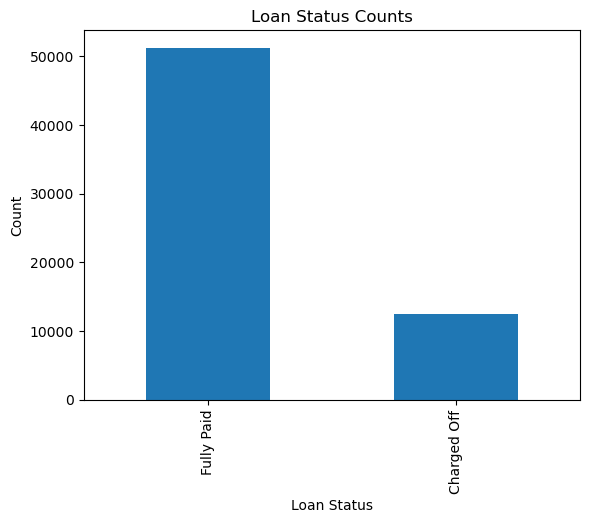

In [20]:
# Let's visualise the counts of the two classes
loan_data_cleaned['loan_status'].value_counts().plot.bar(
    title="Loan Status Counts", xlabel='Loan Status', ylabel='Count'
);

In [21]:
# Create a dict of features to missing values
null_values_per_column = pd.isna(loan_data_cleaned).sum().to_dict()

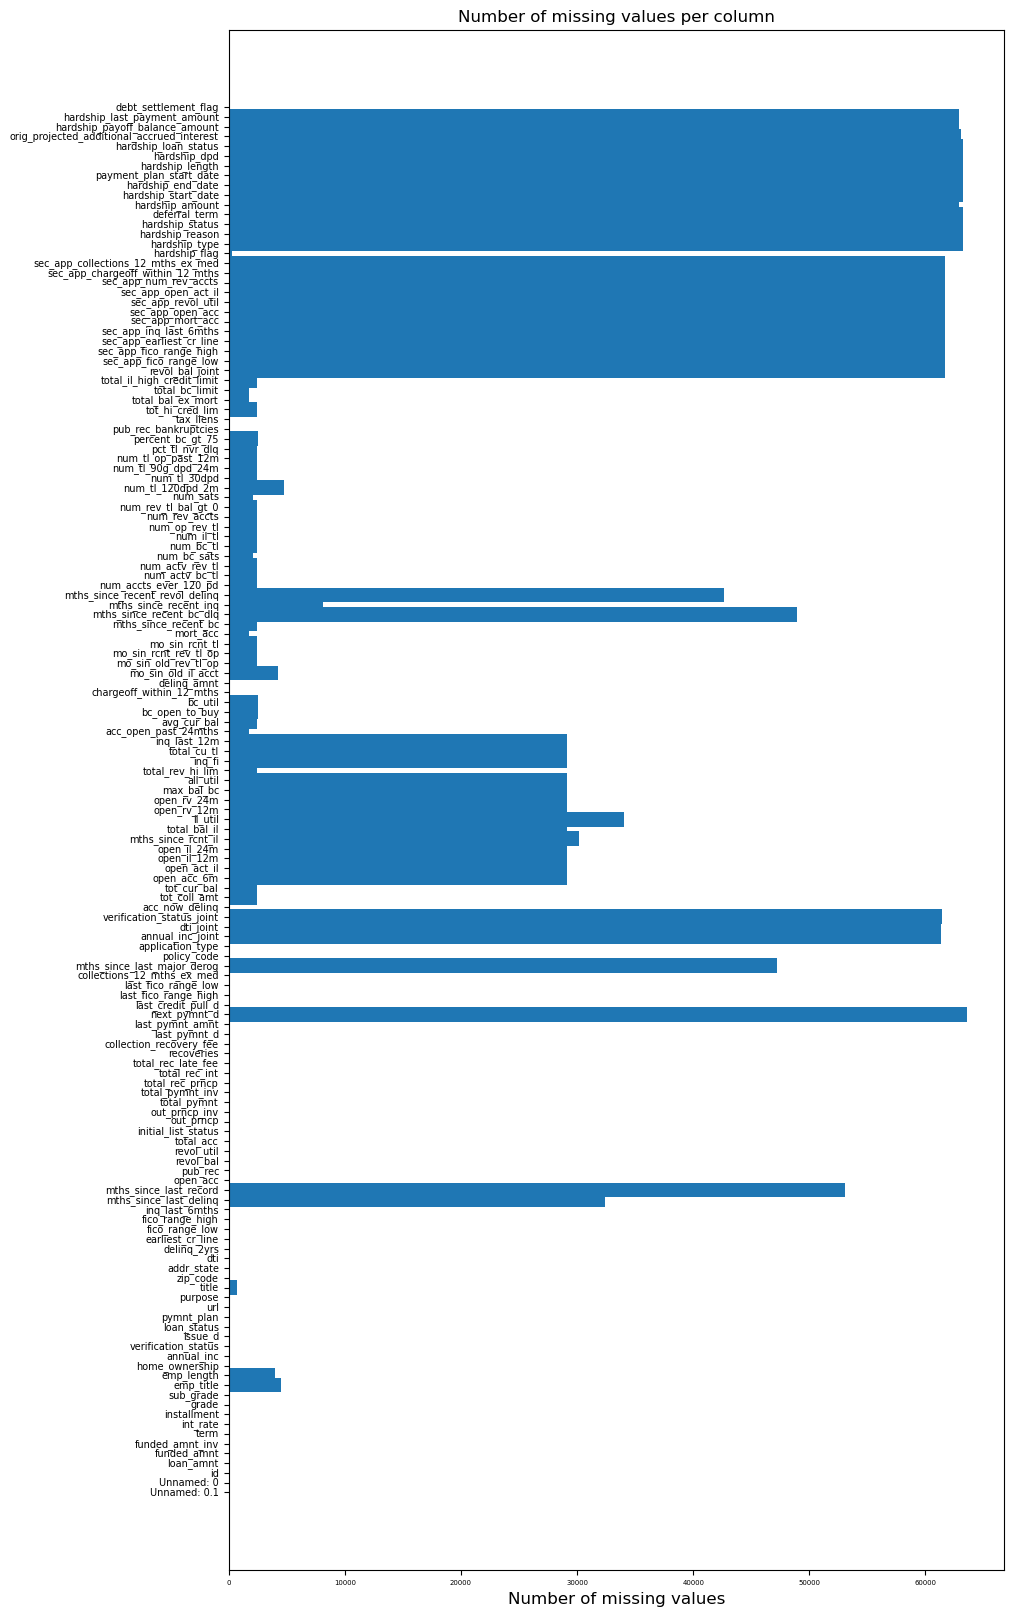

In [22]:
# Let's visualise the null values per feature
x = null_values_per_column.keys()
y = null_values_per_column.values()
plt.figure(figsize=(10, 20))
plt.barh(x,y, height=1.5)
plt.xticks(size=5)
plt.yticks(size=7, va="center")
plt.xlabel("Number of missing values", size="large")
plt.title("Number of missing values per column")
plt.show();

There's quite a few columns with large number of values missing!

Why don't we make a note of those with 50%+ values missing? We can decide what to do with them later. 

More importantly we can ask the business about this as this may be a data quality issue that can impact how well the model performs.

In [23]:
# List of columns with 50% or more missing valules
columns_over_50_percent_missing = [column for column, missing_values in null_values_per_column.items() if missing_values >= 50000]
print("Number of features with 50% or more missing values:", len(columns_over_50_percent_missing))

Number of features with 50% or more missing values: 31


### Visualisations 

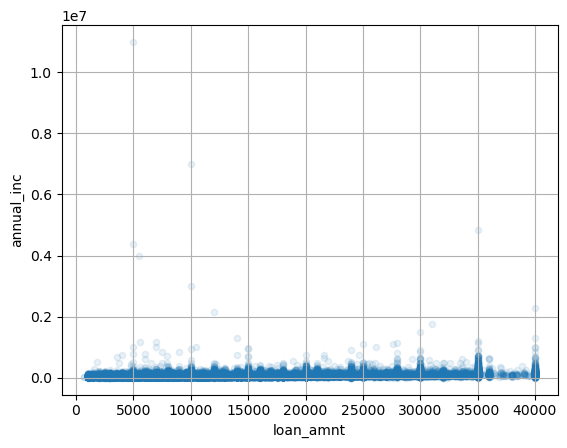

In [24]:
loan_data_cleaned.plot(kind="scatter", x="loan_amnt", y="annual_inc", alpha=0.1, grid=True)
plt.show();

In [25]:
def plot_boxplot(dataframe, column, title='Boxplot', figsize=(10, 6)):
    """
    Plots a boxplot for a specified column in a DataFrame.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing the data.
    - column (str): The column to plot the boxplot for.
    - title (str): The title of the plot. Defaults to 'Boxplot'.
    - figsize (tuple): The figure size. Defaults to (10, 6).
    """
    plt.figure(figsize=figsize)
    sns.boxplot(dataframe[column])

    # Customize the plot
    plt.title(title)
    plt.xlabel(column)
    
    # Display the plot
    plt.show()

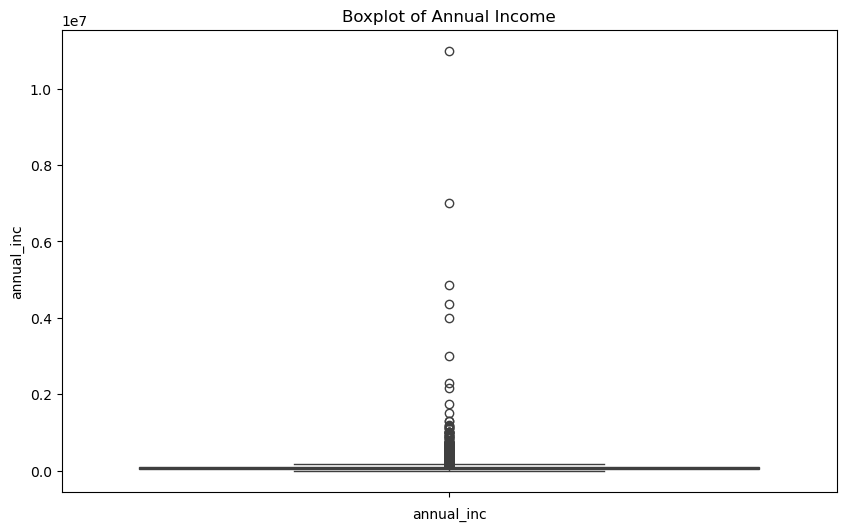

In [26]:
plot_boxplot(loan_data_cleaned, "annual_inc", title="Boxplot of Annual Income")

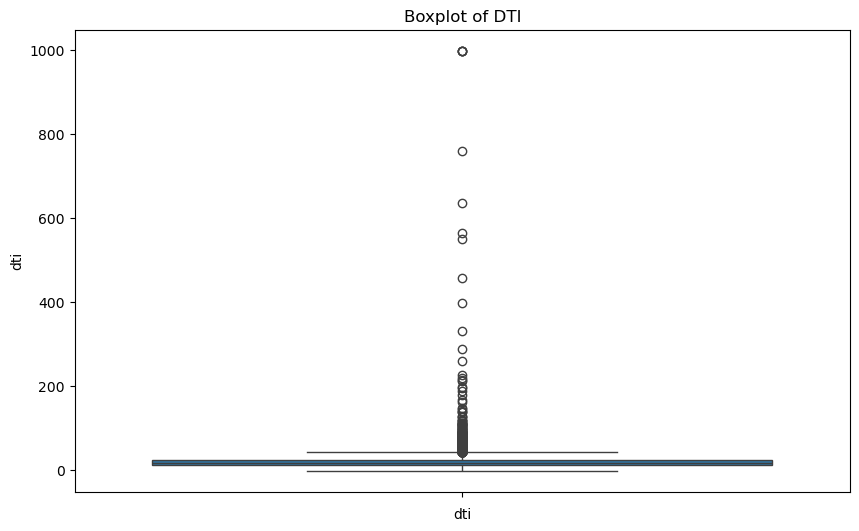

In [27]:
plot_boxplot(loan_data_cleaned, "dti", title="Boxplot of DTI")

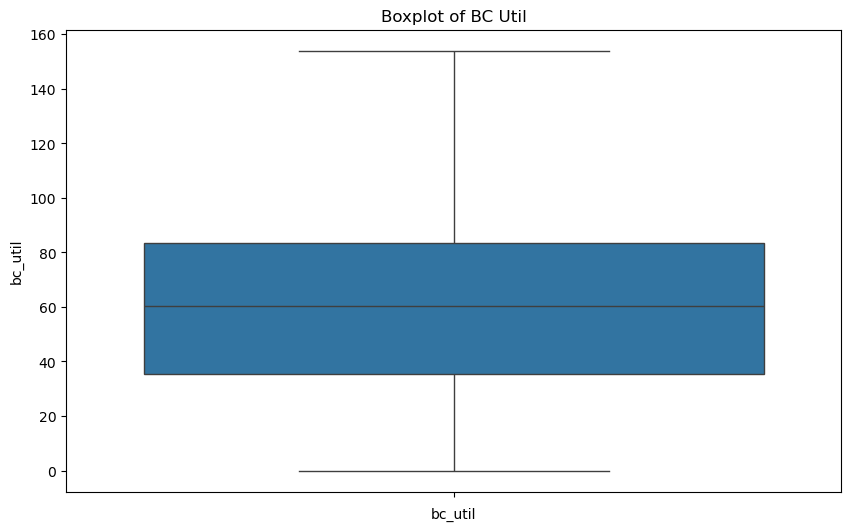

In [28]:
plot_boxplot(loan_data_cleaned, "bc_util", title="Boxplot of BC Util")

The "annual_inc" feature definitely has some outliers that we may need to handle to get the data ready for modelling.

In [29]:
# Let's create a function to plot a crosstab
def plot_crosstab(dataframe, index_col, columns_col, title='Distribution of Values Across Categories',
                  xlabel='Category', ylabel='Count', normalize='index', stacked=True):
    """
    Plots a crosstab of a DataFrame column against another column.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing the data.
    - index_col (str): The column to use for the crosstab index.
    - columns_col (str): The column to use for the crosstab columns.
    - title (str): The title of the plot.
    - xlabel (str): The label for the x-axis.
    - ylabel (str): The label for the y-axis.
    - normalize (str or bool): Whether to normalize the crosstab, defaults to 'index'.
    - stacked (bool): Whether to stack the bar plot, defaults to True.
    """
    # Create the crosstab
    crosstab_result = pd.crosstab(dataframe[index_col], dataframe[columns_col], normalize=normalize)
    
    # Plot the crosstab
    crosstab_result.plot(kind='bar', stacked=stacked, figsize=(10, 6))

    # Customize the plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title=columns_col, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()  # Adjust layout for better fit
    
    # Display the plot
    plt.show()

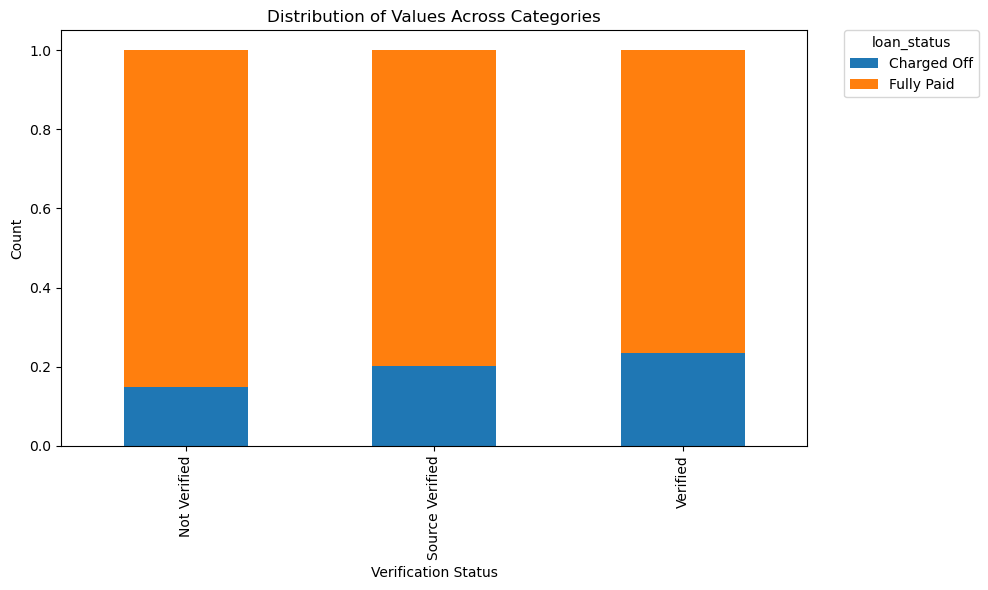

In [30]:
plot_crosstab(loan_data_cleaned, "verification_status", "loan_status", xlabel="Verification Status")

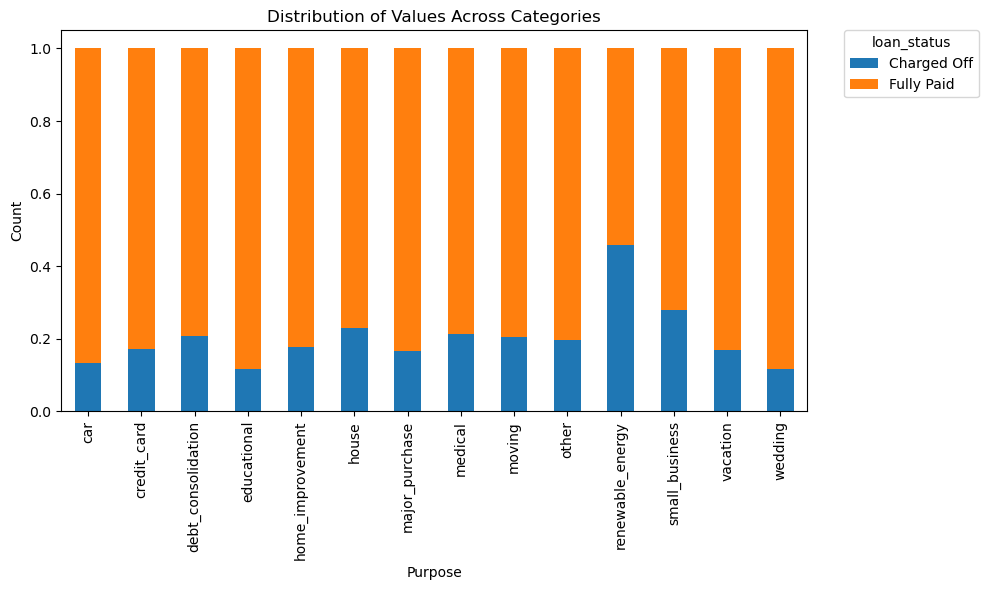

In [31]:
plot_crosstab(loan_data_cleaned, "purpose", "loan_status", xlabel="Purpose")

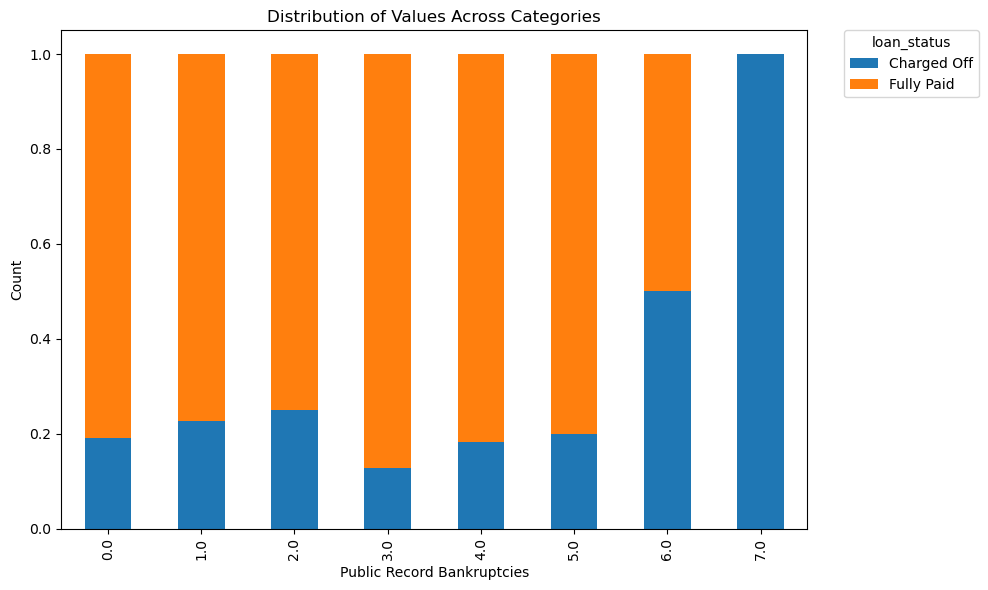

In [32]:
plot_crosstab(loan_data_cleaned, "pub_rec_bankruptcies", "loan_status", xlabel="Public Record Bankruptcies")

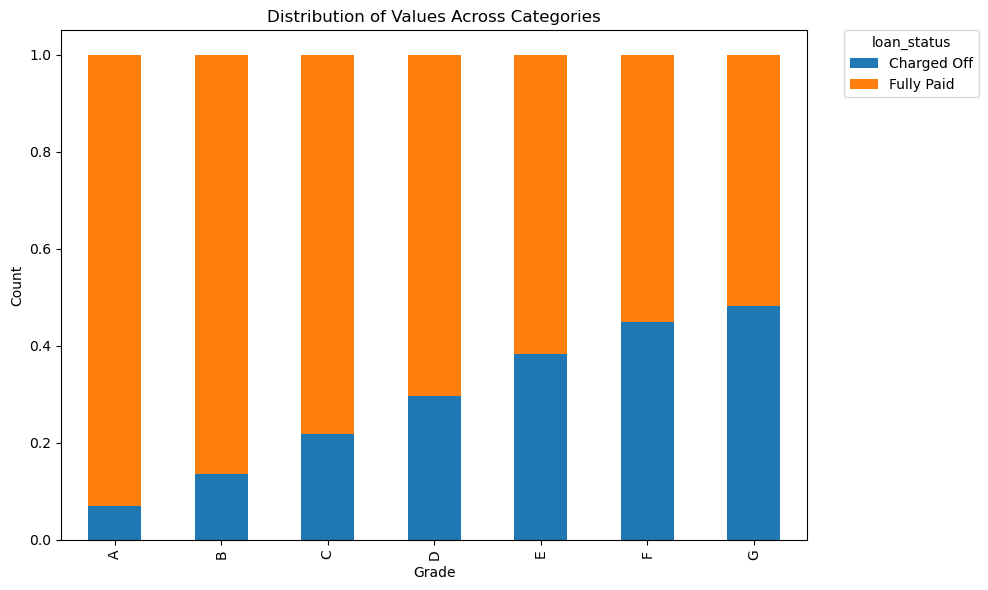

In [33]:
plot_crosstab(loan_data_cleaned, "grade", "loan_status", xlabel="Grade")

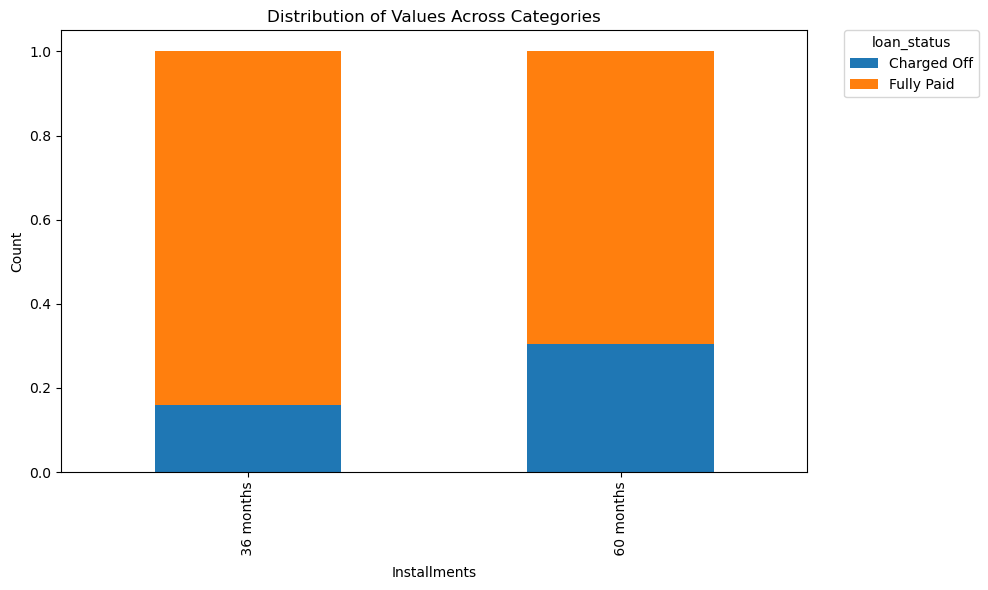

In [34]:
plot_crosstab(loan_data_cleaned, "term", "loan_status", xlabel="Installments")

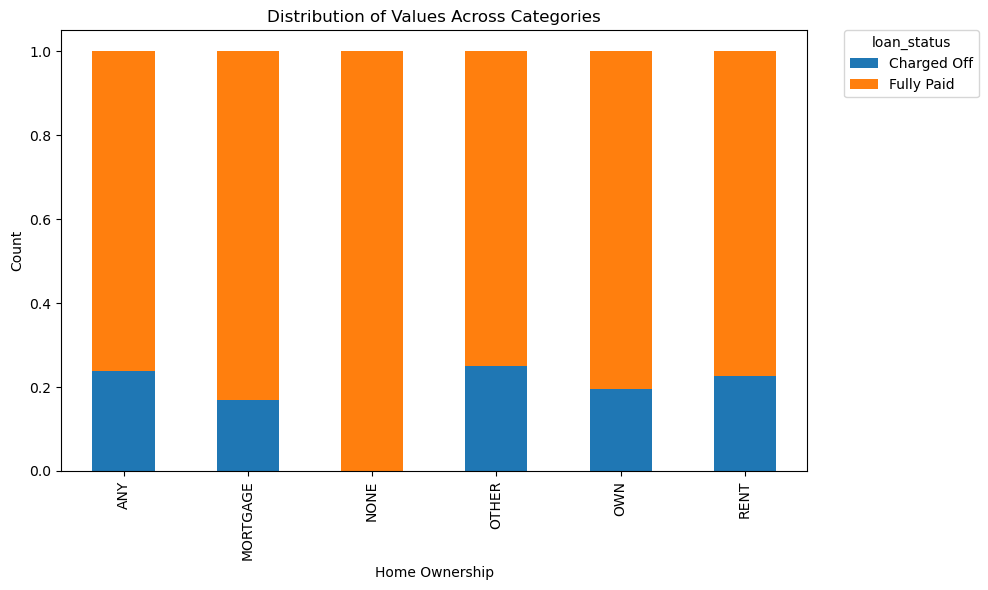

In [35]:
plot_crosstab(loan_data_cleaned, "home_ownership", "loan_status", xlabel="Home Ownership")

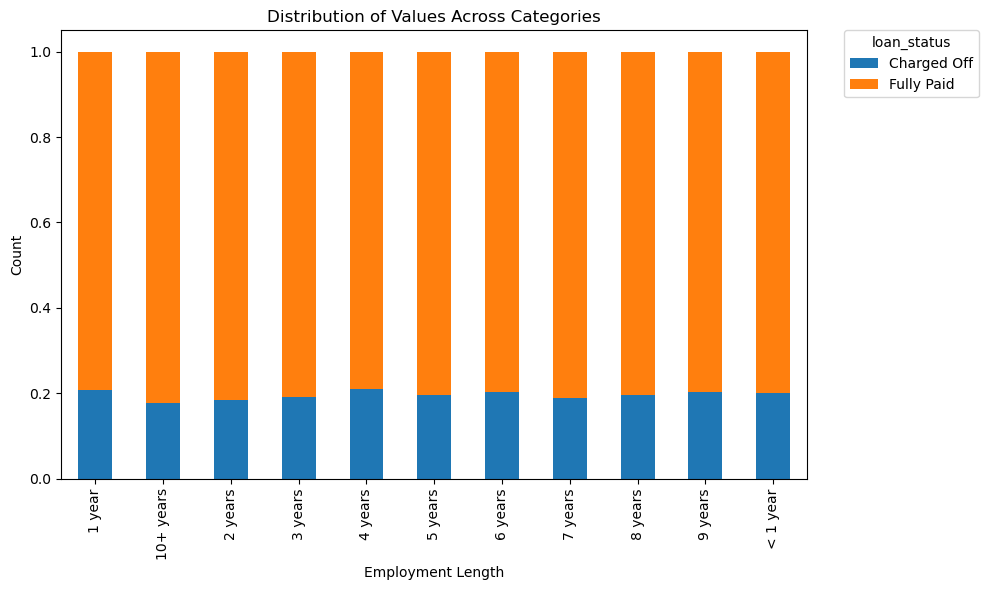

In [36]:
plot_crosstab(loan_data_cleaned, "emp_length", "loan_status", xlabel="Employment Length")

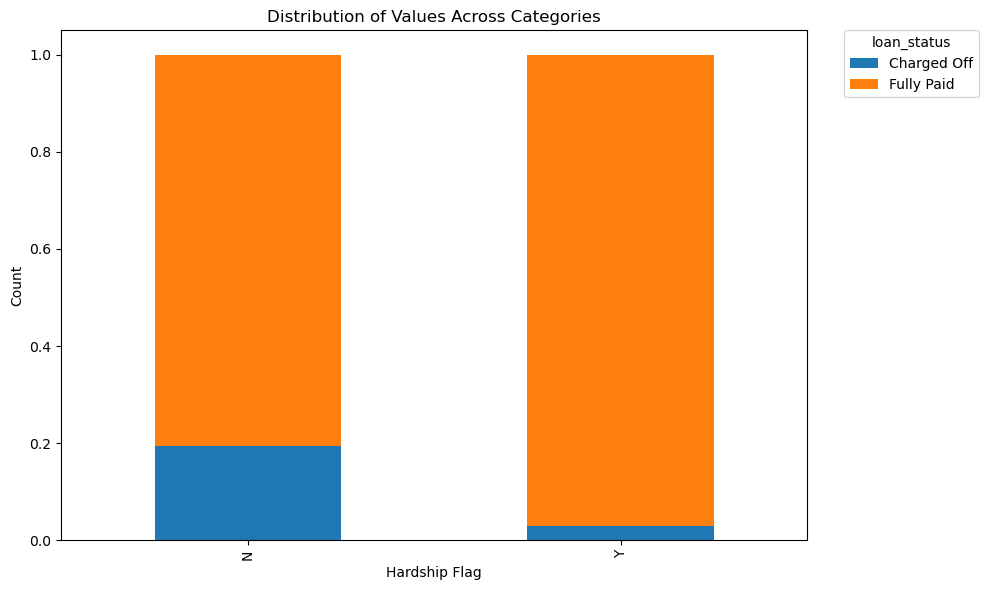

In [37]:
plot_crosstab(loan_data_cleaned, "hardship_flag", "loan_status", xlabel="Hardship Flag")

In [38]:
def plot_corr_heatmap(dataframe, features, title='Heatmap of Selected Features', figsize=(12, 8), cmap='viridis'):
    """
    Plots a heatmap of correlations for a specified list of features in a DataFrame.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing the data.
    - features (list): The list of column names to include in the heatmap.
    - title (str): The title of the plot. Defaults to 'Heatmap of Selected Features'.
    - figsize (tuple): The figure size. Defaults to (12, 8).
    - cmap (str): The colormap for the heatmap. Defaults to 'viridis'.
    """
    # Filter the DataFrame to only include the selected features
    data_subset = dataframe[features]
    
    # Calculate the correlation matrix
    correlation_matrix = data_subset.corr()
    
    # Plot the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix, annot=True, cmap=cmap, vmin=-1, vmax=1, linewidths=0.5)
    
    # Customize the plot
    plt.title(title)
    plt.tight_layout()  # Ensure the plot fits well within the figure area
    
    # Display the plot
    plt.show()

This function will come in handy later on when our data is a bit more polished

In [39]:
# Calculate the correlation matrix
correlation_matrix = loan_data_cleaned.select_dtypes(exclude="object").corr()

# Set threshold
correlation_threshold = 0.9

# Create a mask to identify correlations above the threshold (absolute value)
high_corr_var = np.where((abs(correlation_matrix) > correlation_threshold) & (correlation_matrix != 1))

# Create a DataFrame of highly correlated pairs
high_corr_pairs = pd.DataFrame({
    'Feature 1': correlation_matrix.columns[high_corr_var[0]],
    'Feature 2': correlation_matrix.columns[high_corr_var[1]],
    'Correlation': correlation_matrix.values[high_corr_var]
})

# Remove duplicates, where A -> B is the same as B -> A
high_corr_pairs = high_corr_pairs[high_corr_pairs['Feature 1'] != high_corr_pairs['Feature 2']].drop_duplicates()
high_corr_pairs

Feature 1  \
0                                    loan_amnt   
1                                    loan_amnt   
2                                    loan_amnt   
3                                  funded_amnt   
4                                  funded_amnt   
5                                  funded_amnt   
6                              funded_amnt_inv   
7                              funded_amnt_inv   
8                              funded_amnt_inv   
9                                  installment   
10                                 installment   
11                                 installment   
12                              fico_range_low   
13                             fico_range_high   
14                                    open_acc   
15                                 total_pymnt   
16                                 total_pymnt   
17                             total_pymnt_inv   
18                             total_pymnt_inv   
19                             total_rec_prncp   
20                             total_rec_prncp   
21                                  recoveries   
22                     collection_recovery_fee   
23                                 tot_cur_bal   
24                                total_bal_il   
25                                total_bal_il   
26                             num_actv_rev_tl   
27                         num_rev_tl_bal_gt_0   
28                                    num_sats   
29                             tot_hi_cred_lim   
30                           total_bal_ex_mort   
31                  total_il_high_credit_limit   
32  orig_projected_additional_accrued_interest   
33              hardship_payoff_balance_amount   

                                     Feature 2  Correlation  
0                                  funded_amnt     0.999701  
1                              funded_amnt_inv     0.998775  
2                                  installment     0.951622  
3                                    loan_amnt     0.999701  
4                              funded_amnt_inv     0.999147  
5                                  installment     0.952060  
6                                    loan_amnt     0.998775  
7                                  funded_amnt     0.999147  
8                                  installment     0.951042  
9                                    loan_amnt     0.951622  
10                                 funded_amnt     0.952060  
11                             funded_amnt_inv     0.951042  
12                             fico_range_high     1.000000  
13                              fico_range_low     1.000000  
14                                    num_sats     0.998891  
15                             total_pymnt_inv     0.999364  
16                             total_rec_prncp     0.965912  
17                                 total_pymnt     0.999364  
18                             total_rec_prncp     0.965284  
19                                 total_pymnt     0.965912  
20                             total_pymnt_inv     0.965284  
21                     collection_recovery_fee     0.985361  
22                                  recoveries     0.985361  
23                             tot_hi_cred_lim     0.983967  
24                           total_bal_ex_mort     0.910876  
25                  total_il_high_credit_limit     0.956929  
26                         num_rev_tl_bal_gt_0     0.982885  
27                             num_actv_rev_tl     0.982885  
28                                    open_acc     0.998891  
29                                 tot_cur_bal     0.983967  
30                                total_bal_il     0.910876  
31                                total_bal_il     0.956929  
32              hardship_payoff_balance_amount     0.905897  
33  orig_projected_additional_accrued_interest     0.905897

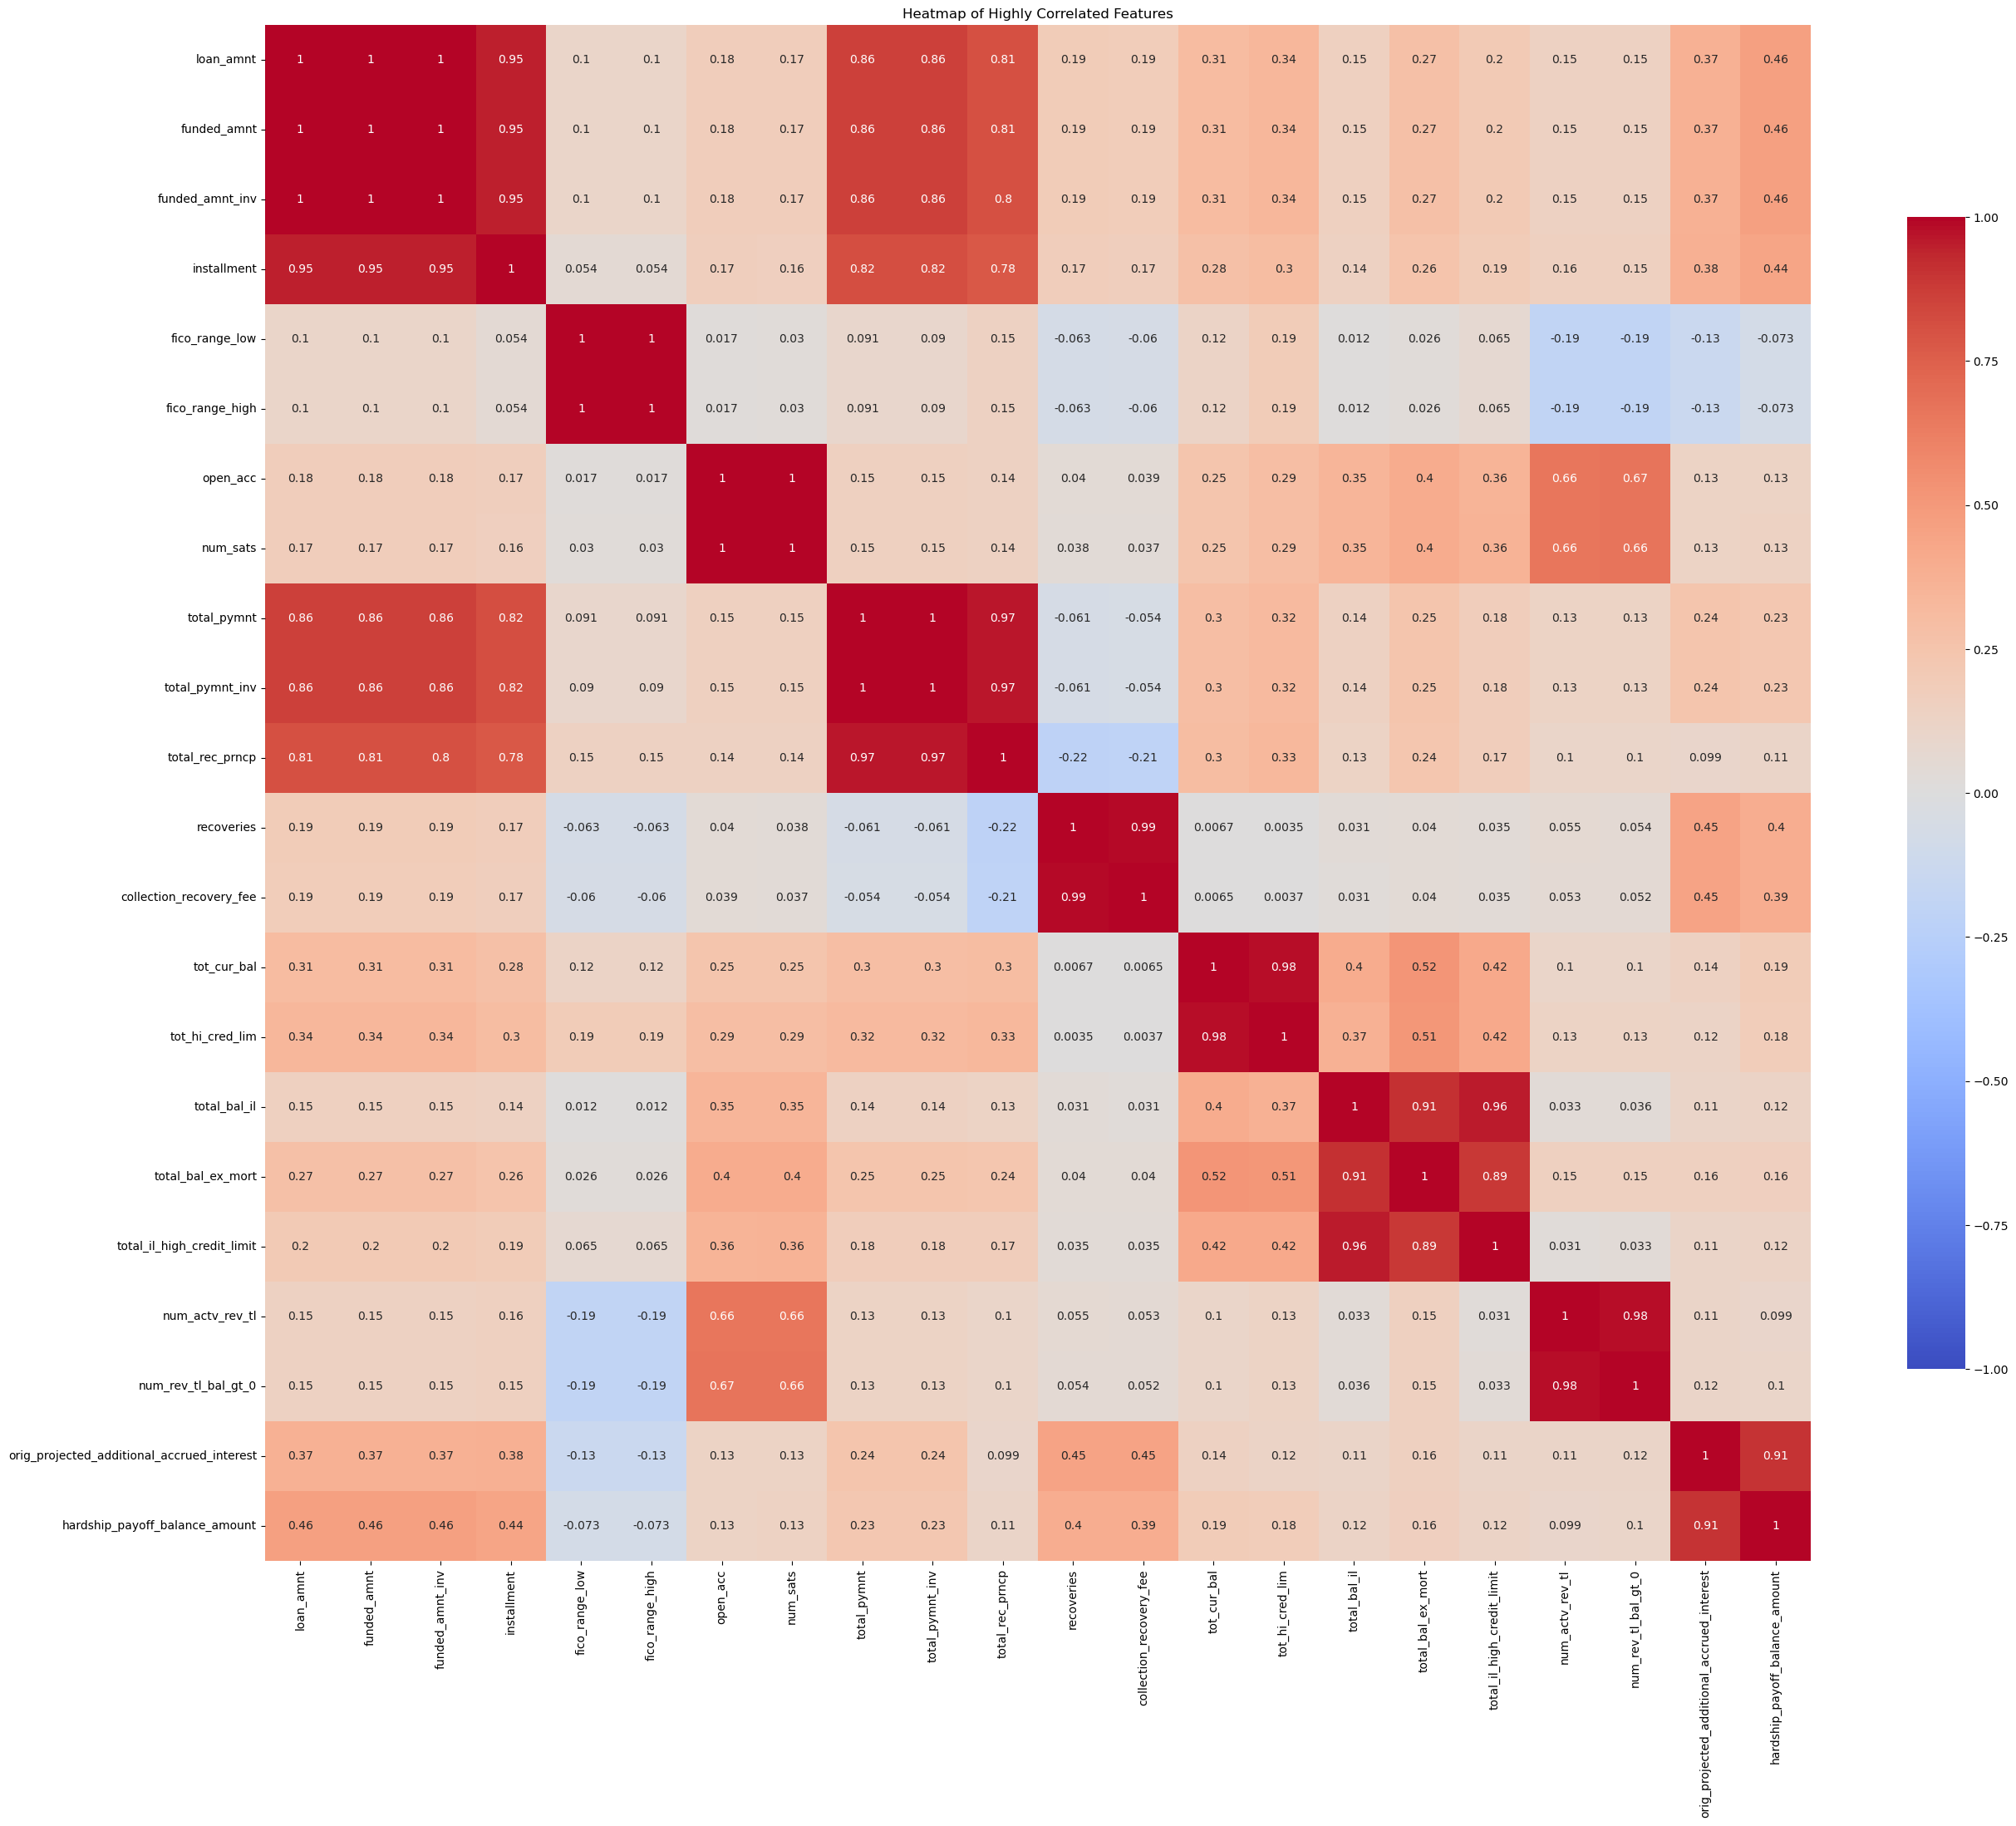

In [40]:
# Extract unique features from the high_corr_pairs DataFrame
high_corr_features = pd.unique(high_corr_pairs[['Feature 1', 'Feature 2']].values.ravel())

# Filter the original correlation matrix for these features
filtered_corr_matrix = correlation_matrix.loc[high_corr_features, high_corr_features]

# Set up the matplotlib figure
plt.figure(figsize=(30,24))

# Plot the heatmap
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={"shrink": 0.75}, center=0)

# Add a title
plt.title('Heatmap of Highly Correlated Features');

In [41]:
def plot_histograms(dataframe, bins=10, plots_per_row=4, figsize=(20, 15)):
    """
    Plots histograms for all columns in a DataFrame with a specified number of plots per row.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing the data.
    - bins (int): Number of bins for the histograms.
    - plots_per_row (int): Number of plots per row.
    - figsize (tuple): Overall figure size.
    """
    num_cols = len(dataframe.columns)
    num_rows = (num_cols // plots_per_row) + (num_cols % plots_per_row > 0)

    fig, axes = plt.subplots(nrows=num_rows, ncols=plots_per_row, figsize=figsize)
    axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

    for i, col in enumerate(dataframe.columns):
        ax = axes[i]
        dataframe[col].hist(bins=bins, ax=ax)
        ax.set_title(col)

    # Remove unused subplots
    for i in range(num_cols, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

We'll use the function above later on.

## 4. Feature Selection
Through research, we've been able to ascertain which features are most relevant. This will help us to reduce the number of features and prevent the curse of dimensionality. This is helpful for a POC or for rapid prototyping.

Features were dropped based on:
- redundancy
- irrelevancy
- high correlation
- low variability
- data leakage prevention

In [42]:
features = [
    'loan_amnt',
    'term', 
    'int_rate', 
    'installment', 
    'sub_grade',
    'emp_length',
    'home_ownership',
    'annual_inc',
    'verification_status',
    'purpose',
    'dti',
    'open_acc',
    'pub_rec',
    'revol_bal',
    'revol_util',
    'total_acc',
    'loan_status'
]

In [43]:
loan_data_selected = loan_data_cleaned[features].reset_index(drop=True)
print("Shape of dataset:", loan_data_selected.shape)
loan_data_selected.head()

Shape of dataset: (63689, 17)


loan_amnt        term int_rate  installment sub_grade emp_length  \
0     5000.0   36 months   10.49%       162.49        B3  10+ years   
1    14000.0   60 months   13.59%       322.79        C2  10+ years   
2     4000.0   36 months   11.49%       131.89        B5  10+ years   
3     7200.0   36 months   13.98%       246.01        C1    6 years   
4    19500.0   36 months   17.27%       697.86        D2    2 years   

  home_ownership  annual_inc verification_status             purpose    dti  \
0       MORTGAGE     55000.0        Not Verified         credit_card   7.22   
1       MORTGAGE     48000.0     Source Verified  debt_consolidation  24.30   
2           RENT     46000.0            Verified              moving  11.56   
3       MORTGAGE     33000.0        Not Verified    home_improvement  10.58   
4           RENT     99000.0        Not Verified  debt_consolidation  16.12   

   open_acc  pub_rec  revol_bal revol_util  total_acc  loan_status  
0       7.0      1.0     6001.0      52.6%        9.0   Fully Paid  
1      16.0      0.0    11894.0      27.1%       23.0   Fully Paid  
2       4.0      1.0     3556.0      38.7%        7.0  Charged Off  
3      14.0      1.0     3466.0        22%       35.0   Fully Paid  
4       6.0      0.0     3959.0      82.5%       19.0   Fully Paid

In [44]:
loan_data_selected.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63689 entries, 0 to 63688
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_amnt            63689 non-null  float64
 1   term                 63689 non-null  object 
 2   int_rate             63689 non-null  object 
 3   installment          63689 non-null  float64
 4   sub_grade            63689 non-null  object 
 5   emp_length           59733 non-null  object 
 6   home_ownership       63689 non-null  object 
 7   annual_inc           63689 non-null  float64
 8   verification_status  63689 non-null  object 
 9   purpose              63689 non-null  object 
 10  dti                  63655 non-null  float64
 11  open_acc             63689 non-null  float64
 12  pub_rec              63689 non-null  float64
 13  revol_bal            63689 non-null  float64
 14  revol_util           63649 non-null  object 
 15  total_acc            63689 non-null 

In [45]:
loan_data_selected.describe().T

count          mean           std     min       25%       50%  \
loan_amnt    63689.0  14556.430074   8968.550389  700.00   7925.00  12000.00   
installment  63689.0    439.316889    266.743276   22.51    246.05    372.13   
annual_inc   63689.0  77372.113982  82071.141697    0.00  46000.00  65000.00   
dti          63655.0     18.612213     13.602131   -1.00     11.84     17.79   
open_acc     63689.0     11.618710      5.581696    0.00      8.00     11.00   
pub_rec      63689.0      0.210036      0.622069    0.00      0.00      0.00   
revol_bal    63689.0  16155.352494  21205.925316    0.00   5837.00  11028.00   
total_acc    63689.0     24.634474     12.018237    1.00     16.00     23.00   

                  75%          max  
loan_amnt    20000.00     40000.00  
installment    582.87      1719.83  
annual_inc   92000.00  10999200.00  
dti             24.34       999.00  
open_acc        14.00        86.00  
pub_rec          0.00        52.00  
revol_bal    19671.00    654134.00  
total_acc       31.00       115.00

## 5. Data Cleaning

- Handling missing values (imputation)
- Data type conversion

In [46]:
categorical_features = loan_data_selected.select_dtypes(include="object")
categorical_features.head()

term int_rate sub_grade emp_length home_ownership  \
0   36 months   10.49%        B3  10+ years       MORTGAGE   
1   60 months   13.59%        C2  10+ years       MORTGAGE   
2   36 months   11.49%        B5  10+ years           RENT   
3   36 months   13.98%        C1    6 years       MORTGAGE   
4   36 months   17.27%        D2    2 years           RENT   

  verification_status             purpose revol_util  loan_status  
0        Not Verified         credit_card      52.6%   Fully Paid  
1     Source Verified  debt_consolidation      27.1%   Fully Paid  
2            Verified              moving      38.7%  Charged Off  
3        Not Verified    home_improvement        22%   Fully Paid  
4        Not Verified  debt_consolidation      82.5%   Fully Paid

In [47]:
categorical_features.term.info()

<class 'pandas.core.series.Series'>
RangeIndex: 63689 entries, 0 to 63688
Series name: term
Non-Null Count  Dtype 
--------------  ----- 
63689 non-null  object
dtypes: object(1)
memory usage: 497.7+ KB


In [48]:
term_mapping = {
    '36 months': 36,
    '60 months': 60
}

In [49]:
categorical_features['term'] = categorical_features['term'].str.strip()

In [50]:
categorical_features['term'] = categorical_features['term'].map(term_mapping)
categorical_features.head()

term int_rate sub_grade emp_length home_ownership verification_status  \
0    36   10.49%        B3  10+ years       MORTGAGE        Not Verified   
1    60   13.59%        C2  10+ years       MORTGAGE     Source Verified   
2    36   11.49%        B5  10+ years           RENT            Verified   
3    36   13.98%        C1    6 years       MORTGAGE        Not Verified   
4    36   17.27%        D2    2 years           RENT        Not Verified   

              purpose revol_util  loan_status  
0         credit_card      52.6%   Fully Paid  
1  debt_consolidation      27.1%   Fully Paid  
2              moving      38.7%  Charged Off  
3    home_improvement        22%   Fully Paid  
4  debt_consolidation      82.5%   Fully Paid

In [51]:
def convert_percentage_to_float(dataframe, column_name):
    """
    Converts a column with percentage strings to float values.
    
    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing the column.
    - column_name (str): The name of the column to convert.
    """
    

    dataframe[column_name] = dataframe[column_name].str.replace('%', '').astype(float)

In [52]:
convert_percentage_to_float(categorical_features, "int_rate")

In [53]:
convert_percentage_to_float(categorical_features, "revol_util")

In [54]:
categorical_features.head()

term  int_rate sub_grade emp_length home_ownership verification_status  \
0    36     10.49        B3  10+ years       MORTGAGE        Not Verified   
1    60     13.59        C2  10+ years       MORTGAGE     Source Verified   
2    36     11.49        B5  10+ years           RENT            Verified   
3    36     13.98        C1    6 years       MORTGAGE        Not Verified   
4    36     17.27        D2    2 years           RENT        Not Verified   

              purpose  revol_util  loan_status  
0         credit_card        52.6   Fully Paid  
1  debt_consolidation        27.1   Fully Paid  
2              moving        38.7  Charged Off  
3    home_improvement        22.0   Fully Paid  
4  debt_consolidation        82.5   Fully Paid

In [55]:
emp_length_mapping = {
    '< 1 year': 0.5,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10,
    'n/a': np.nan  # You can replace NaN with 0 if it makes sense in your use case
}

In [56]:
categorical_features['emp_length'] = categorical_features['emp_length'].map(emp_length_mapping)

In [57]:
categorical_features.head()

term  int_rate sub_grade  emp_length home_ownership verification_status  \
0    36     10.49        B3        10.0       MORTGAGE        Not Verified   
1    60     13.59        C2        10.0       MORTGAGE     Source Verified   
2    36     11.49        B5        10.0           RENT            Verified   
3    36     13.98        C1         6.0       MORTGAGE        Not Verified   
4    36     17.27        D2         2.0           RENT        Not Verified   

              purpose  revol_util  loan_status  
0         credit_card        52.6   Fully Paid  
1  debt_consolidation        27.1   Fully Paid  
2              moving        38.7  Charged Off  
3    home_improvement        22.0   Fully Paid  
4  debt_consolidation        82.5   Fully Paid

In [58]:
categorical_features.isna().sum()

term                      0
int_rate                  0
sub_grade                 0
emp_length             3956
home_ownership            0
verification_status       0
purpose                   0
revol_util               40
loan_status               0
dtype: int64

In [59]:
categorical_features.emp_length.describe()

count    59733.000000
mean         5.973055
std          3.635637
min          0.500000
25%          2.000000
50%          6.000000
75%         10.000000
max         10.000000
Name: emp_length, dtype: float64

In [60]:
categorical_features["emp_length"] = categorical_features["emp_length"].fillna(categorical_features["emp_length"].mode()[0])

In [61]:
categorical_features.emp_length.info()

<class 'pandas.core.series.Series'>
RangeIndex: 63689 entries, 0 to 63688
Series name: emp_length
Non-Null Count  Dtype  
--------------  -----  
63689 non-null  float64
dtypes: float64(1)
memory usage: 497.7 KB


In [62]:
categorical_features.revol_util.describe()

count    63649.000000
mean        50.264011
std         24.759847
min          0.000000
25%         31.300000
50%         50.300000
75%         69.400000
max        144.300000
Name: revol_util, dtype: float64

In [63]:
categorical_features['revol_util']=categorical_features['revol_util'].fillna(categorical_features['revol_util'].median())

In [64]:
categorical_features.revol_util.info()

<class 'pandas.core.series.Series'>
RangeIndex: 63689 entries, 0 to 63688
Series name: revol_util
Non-Null Count  Dtype  
--------------  -----  
63689 non-null  float64
dtypes: float64(1)
memory usage: 497.7 KB


In [65]:
categorical_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63689 entries, 0 to 63688
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   term                 63689 non-null  int64  
 1   int_rate             63689 non-null  float64
 2   sub_grade            63689 non-null  object 
 3   emp_length           63689 non-null  float64
 4   home_ownership       63689 non-null  object 
 5   verification_status  63689 non-null  object 
 6   purpose              63689 non-null  object 
 7   revol_util           63689 non-null  float64
 8   loan_status          63689 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 4.4+ MB


In [66]:
numerical_features = loan_data_selected.select_dtypes(exclude="object")
numerical_features.head()

loan_amnt  installment  annual_inc    dti  open_acc  pub_rec  revol_bal  \
0     5000.0       162.49     55000.0   7.22       7.0      1.0     6001.0   
1    14000.0       322.79     48000.0  24.30      16.0      0.0    11894.0   
2     4000.0       131.89     46000.0  11.56       4.0      1.0     3556.0   
3     7200.0       246.01     33000.0  10.58      14.0      1.0     3466.0   
4    19500.0       697.86     99000.0  16.12       6.0      0.0     3959.0   

   total_acc  
0        9.0  
1       23.0  
2        7.0  
3       35.0  
4       19.0

In [67]:
numerical_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63689 entries, 0 to 63688
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   loan_amnt    63689 non-null  float64
 1   installment  63689 non-null  float64
 2   annual_inc   63689 non-null  float64
 3   dti          63655 non-null  float64
 4   open_acc     63689 non-null  float64
 5   pub_rec      63689 non-null  float64
 6   revol_bal    63689 non-null  float64
 7   total_acc    63689 non-null  float64
dtypes: float64(8)
memory usage: 3.9 MB


In [68]:
numerical_features.dti.info()

<class 'pandas.core.series.Series'>
RangeIndex: 63689 entries, 0 to 63688
Series name: dti
Non-Null Count  Dtype  
--------------  -----  
63655 non-null  float64
dtypes: float64(1)
memory usage: 497.7 KB


In [69]:
numerical_features.dti.describe()

count    63655.000000
mean        18.612213
std         13.602131
min         -1.000000
25%         11.840000
50%         17.790000
75%         24.340000
max        999.000000
Name: dti, dtype: float64

In [70]:
numerical_features['dti']=numerical_features['dti'].fillna(numerical_features['dti'].median())

In [71]:
numerical_features.dti.info()

<class 'pandas.core.series.Series'>
RangeIndex: 63689 entries, 0 to 63688
Series name: dti
Non-Null Count  Dtype  
--------------  -----  
63689 non-null  float64
dtypes: float64(1)
memory usage: 497.7 KB


In [72]:
numerical_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63689 entries, 0 to 63688
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   loan_amnt    63689 non-null  float64
 1   installment  63689 non-null  float64
 2   annual_inc   63689 non-null  float64
 3   dti          63689 non-null  float64
 4   open_acc     63689 non-null  float64
 5   pub_rec      63689 non-null  float64
 6   revol_bal    63689 non-null  float64
 7   total_acc    63689 non-null  float64
dtypes: float64(8)
memory usage: 3.9 MB


## 6. Data Preprocessing

* Encoding categorical features
* Standardisation
* Feature transformations to reduce skewness
* Outlier detection and handling

In [73]:
categorical_features.head()

term  int_rate sub_grade  emp_length home_ownership verification_status  \
0    36     10.49        B3        10.0       MORTGAGE        Not Verified   
1    60     13.59        C2        10.0       MORTGAGE     Source Verified   
2    36     11.49        B5        10.0           RENT            Verified   
3    36     13.98        C1         6.0       MORTGAGE        Not Verified   
4    36     17.27        D2         2.0           RENT        Not Verified   

              purpose  revol_util  loan_status  
0         credit_card        52.6   Fully Paid  
1  debt_consolidation        27.1   Fully Paid  
2              moving        38.7  Charged Off  
3    home_improvement        22.0   Fully Paid  
4  debt_consolidation        82.5   Fully Paid

In [74]:
categorical_features.sub_grade.unique()

array(['B3', 'C2', 'B5', 'C1', 'D2', 'A5', 'A4', 'D4', 'C3', 'B1', 'D5',
       'E4', 'C4', 'B2', 'A2', 'E1', 'E3', 'D3', 'B4', 'F5', 'A1', 'A3',
       'F1', 'E2', 'C5', 'F4', 'D1', 'F2', 'G3', 'E5', 'F3', 'G1', 'G2',
       'G5', 'G4'], dtype=object)

In [75]:
sub_grade_mapping = {}
counter = 1  # Start from 1 for the first sub-grade

for grade in 'ABCDEFG':  # Loop through each grade
    for num in range(1, 6):  # Loop through sub-grade numbers 1 to 5
        sub_grade_mapping[f"{grade}{num}"] = counter
        counter += 1

In [76]:
print("Sub-grade Mapping:", sub_grade_mapping)

Sub-grade Mapping: {'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5, 'B1': 6, 'B2': 7, 'B3': 8, 'B4': 9, 'B5': 10, 'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 'C5': 15, 'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20, 'E1': 21, 'E2': 22, 'E3': 23, 'E4': 24, 'E5': 25, 'F1': 26, 'F2': 27, 'F3': 28, 'F4': 29, 'F5': 30, 'G1': 31, 'G2': 32, 'G3': 33, 'G4': 34, 'G5': 35}


In [77]:
categorical_features['sub_grade_encoded'] = categorical_features['sub_grade'].map(sub_grade_mapping)

In [78]:
categorical_features.sub_grade_encoded.unique()

array([ 8, 12, 10, 11, 17,  5,  4, 19, 13,  6, 20, 24, 14,  7,  2, 21, 23,
       18,  9, 30,  1,  3, 26, 22, 15, 29, 16, 27, 33, 25, 28, 31, 32, 35,
       34])

In [79]:
categorical_features.home_ownership.unique()

array(['MORTGAGE', 'RENT', 'OWN', 'ANY', 'OTHER', 'NONE'], dtype=object)

In [80]:
categorical_features.home_ownership.value_counts()

home_ownership
MORTGAGE    31287
RENT        25318
OWN          7026
ANY            42
OTHER          12
NONE            4
Name: count, dtype: int64

In [81]:
# Combine the less common categories into 'OTHER'
categorical_features['home_ownership'] = categorical_features['home_ownership'].replace(['ANY', 'OTHER', 'NONE'], 'OTHER')

# Check the updated counts
print(categorical_features['home_ownership'].value_counts())


home_ownership
MORTGAGE    31287
RENT        25318
OWN          7026
OTHER          58
Name: count, dtype: int64


In [82]:
categorical_features = pd.get_dummies(categorical_features, columns=['home_ownership'], prefix='home')

In [83]:
# Apply one-hot encoding to 'verification_status' and 'purpose' columns
categorical_features = pd.get_dummies(categorical_features, columns=['verification_status', 'purpose'], prefix=['verification', 'purpose'])

In [84]:
# Check the DataFrame to ensure the encoding worked
categorical_features.head()

term  int_rate sub_grade  emp_length  revol_util  loan_status  \
0    36     10.49        B3        10.0        52.6   Fully Paid   
1    60     13.59        C2        10.0        27.1   Fully Paid   
2    36     11.49        B5        10.0        38.7  Charged Off   
3    36     13.98        C1         6.0        22.0   Fully Paid   
4    36     17.27        D2         2.0        82.5   Fully Paid   

   sub_grade_encoded  home_MORTGAGE  home_OTHER  home_OWN  home_RENT  \
0                  8           True       False     False      False   
1                 12           True       False     False      False   
2                 10          False       False     False       True   
3                 11           True       False     False      False   
4                 17          False       False     False       True   

   verification_Not Verified  verification_Source Verified  \
0                       True                         False   
1                      False                          True   
2                      False                         False   
3                       True                         False   
4                       True                         False   

   verification_Verified  purpose_car  purpose_credit_card  \
0                  False        False                 True   
1                  False        False                False   
2                   True        False                False   
3                  False        False                False   
4                  False        False                False   

   purpose_debt_consolidation  purpose_educational  purpose_home_improvement  \
0                       False                False                     False   
1                        True                False                     False   
2                       False                False                     False   
3                       False                False                      True   
4                        True                False                     False   

   purpose_house  purpose_major_purchase  purpose_medical  purpose_moving  \
0          False                   False            False           False   
1          False                   False            False           False   
2          False                   False            False            True   
3          False                   False            False           False   
4          False                   False            False           False   

   purpose_other  purpose_renewable_energy  purpose_small_business  \
0          False                     False                   False   
1          False                     False                   False   
2          False                     False                   False   
3          False                     False                   False   
4          False                     False                   False   

   purpose_vacation  purpose_wedding  
0             False            False  
1             False            False  
2             False            False  
3             False            False  
4             False            False

In [85]:
# Overwrite the 'loan_status' column with binary values
categorical_features['loan_status'] = categorical_features['loan_status'].map({
    'Fully Paid': 0,
    'Charged Off': 1
})

In [86]:
categorical_features.head()

term  int_rate sub_grade  emp_length  revol_util  loan_status  \
0    36     10.49        B3        10.0        52.6            0   
1    60     13.59        C2        10.0        27.1            0   
2    36     11.49        B5        10.0        38.7            1   
3    36     13.98        C1         6.0        22.0            0   
4    36     17.27        D2         2.0        82.5            0   

   sub_grade_encoded  home_MORTGAGE  home_OTHER  home_OWN  home_RENT  \
0                  8           True       False     False      False   
1                 12           True       False     False      False   
2                 10          False       False     False       True   
3                 11           True       False     False      False   
4                 17          False       False     False       True   

   verification_Not Verified  verification_Source Verified  \
0                       True                         False   
1                      False                          True   
2                      False                         False   
3                       True                         False   
4                       True                         False   

   verification_Verified  purpose_car  purpose_credit_card  \
0                  False        False                 True   
1                  False        False                False   
2                   True        False                False   
3                  False        False                False   
4                  False        False                False   

   purpose_debt_consolidation  purpose_educational  purpose_home_improvement  \
0                       False                False                     False   
1                        True                False                     False   
2                       False                False                     False   
3                       False                False                      True   
4                        True                False                     False   

   purpose_house  purpose_major_purchase  purpose_medical  purpose_moving  \
0          False                   False            False           False   
1          False                   False            False           False   
2          False                   False            False            True   
3          False                   False            False           False   
4          False                   False            False           False   

   purpose_other  purpose_renewable_energy  purpose_small_business  \
0          False                     False                   False   
1          False                     False                   False   
2          False                     False                   False   
3          False                     False                   False   
4          False                     False                   False   

   purpose_vacation  purpose_wedding  
0             False            False  
1             False            False  
2             False            False  
3             False            False  
4             False            False

In [87]:
# Identify numerical columns in the categorical features DataFrame
numerical_from_categorical = categorical_features[["emp_length", "sub_grade_encoded", "int_rate", "revol_util"]]

# Add these columns to the numerical features DataFrame
numerical_features = pd.concat([numerical_features, numerical_from_categorical], axis=1)

# Drop these columns from the original categorical features DataFrame to avoid duplication
categorical_features = categorical_features.drop(columns=numerical_from_categorical.columns)
categorical_features = categorical_features.drop(columns=["sub_grade"])

# Print the shape of the updated categorical numerical features DataFrame to verify
print("Updated shape of categorical features DataFrame:", categorical_features.shape)
print("Updated shape of numerical features DataFrame:", numerical_features.shape)

Updated shape of categorical features DataFrame: (63689, 23)
Updated shape of numerical features DataFrame: (63689, 12)


In [88]:
categorical_features.head()

term  loan_status  home_MORTGAGE  home_OTHER  home_OWN  home_RENT  \
0    36            0           True       False     False      False   
1    60            0           True       False     False      False   
2    36            1          False       False     False       True   
3    36            0           True       False     False      False   
4    36            0          False       False     False       True   

   verification_Not Verified  verification_Source Verified  \
0                       True                         False   
1                      False                          True   
2                      False                         False   
3                       True                         False   
4                       True                         False   

   verification_Verified  purpose_car  purpose_credit_card  \
0                  False        False                 True   
1                  False        False                False   
2                   True        False                False   
3                  False        False                False   
4                  False        False                False   

   purpose_debt_consolidation  purpose_educational  purpose_home_improvement  \
0                       False                False                     False   
1                        True                False                     False   
2                       False                False                     False   
3                       False                False                      True   
4                        True                False                     False   

   purpose_house  purpose_major_purchase  purpose_medical  purpose_moving  \
0          False                   False            False           False   
1          False                   False            False           False   
2          False                   False            False            True   
3          False                   False            False           False   
4          False                   False            False           False   

   purpose_other  purpose_renewable_energy  purpose_small_business  \
0          False                     False                   False   
1          False                     False                   False   
2          False                     False                   False   
3          False                     False                   False   
4          False                     False                   False   

   purpose_vacation  purpose_wedding  
0             False            False  
1             False            False  
2             False            False  
3             False            False  
4             False            False

In [89]:
numerical_features.head()

loan_amnt  installment  annual_inc    dti  open_acc  pub_rec  revol_bal  \
0     5000.0       162.49     55000.0   7.22       7.0      1.0     6001.0   
1    14000.0       322.79     48000.0  24.30      16.0      0.0    11894.0   
2     4000.0       131.89     46000.0  11.56       4.0      1.0     3556.0   
3     7200.0       246.01     33000.0  10.58      14.0      1.0     3466.0   
4    19500.0       697.86     99000.0  16.12       6.0      0.0     3959.0   

   total_acc  emp_length  sub_grade_encoded  int_rate  revol_util  
0        9.0        10.0                  8     10.49        52.6  
1       23.0        10.0                 12     13.59        27.1  
2        7.0        10.0                 10     11.49        38.7  
3       35.0         6.0                 11     13.98        22.0  
4       19.0         2.0                 17     17.27        82.5

Let's visualise the distribution

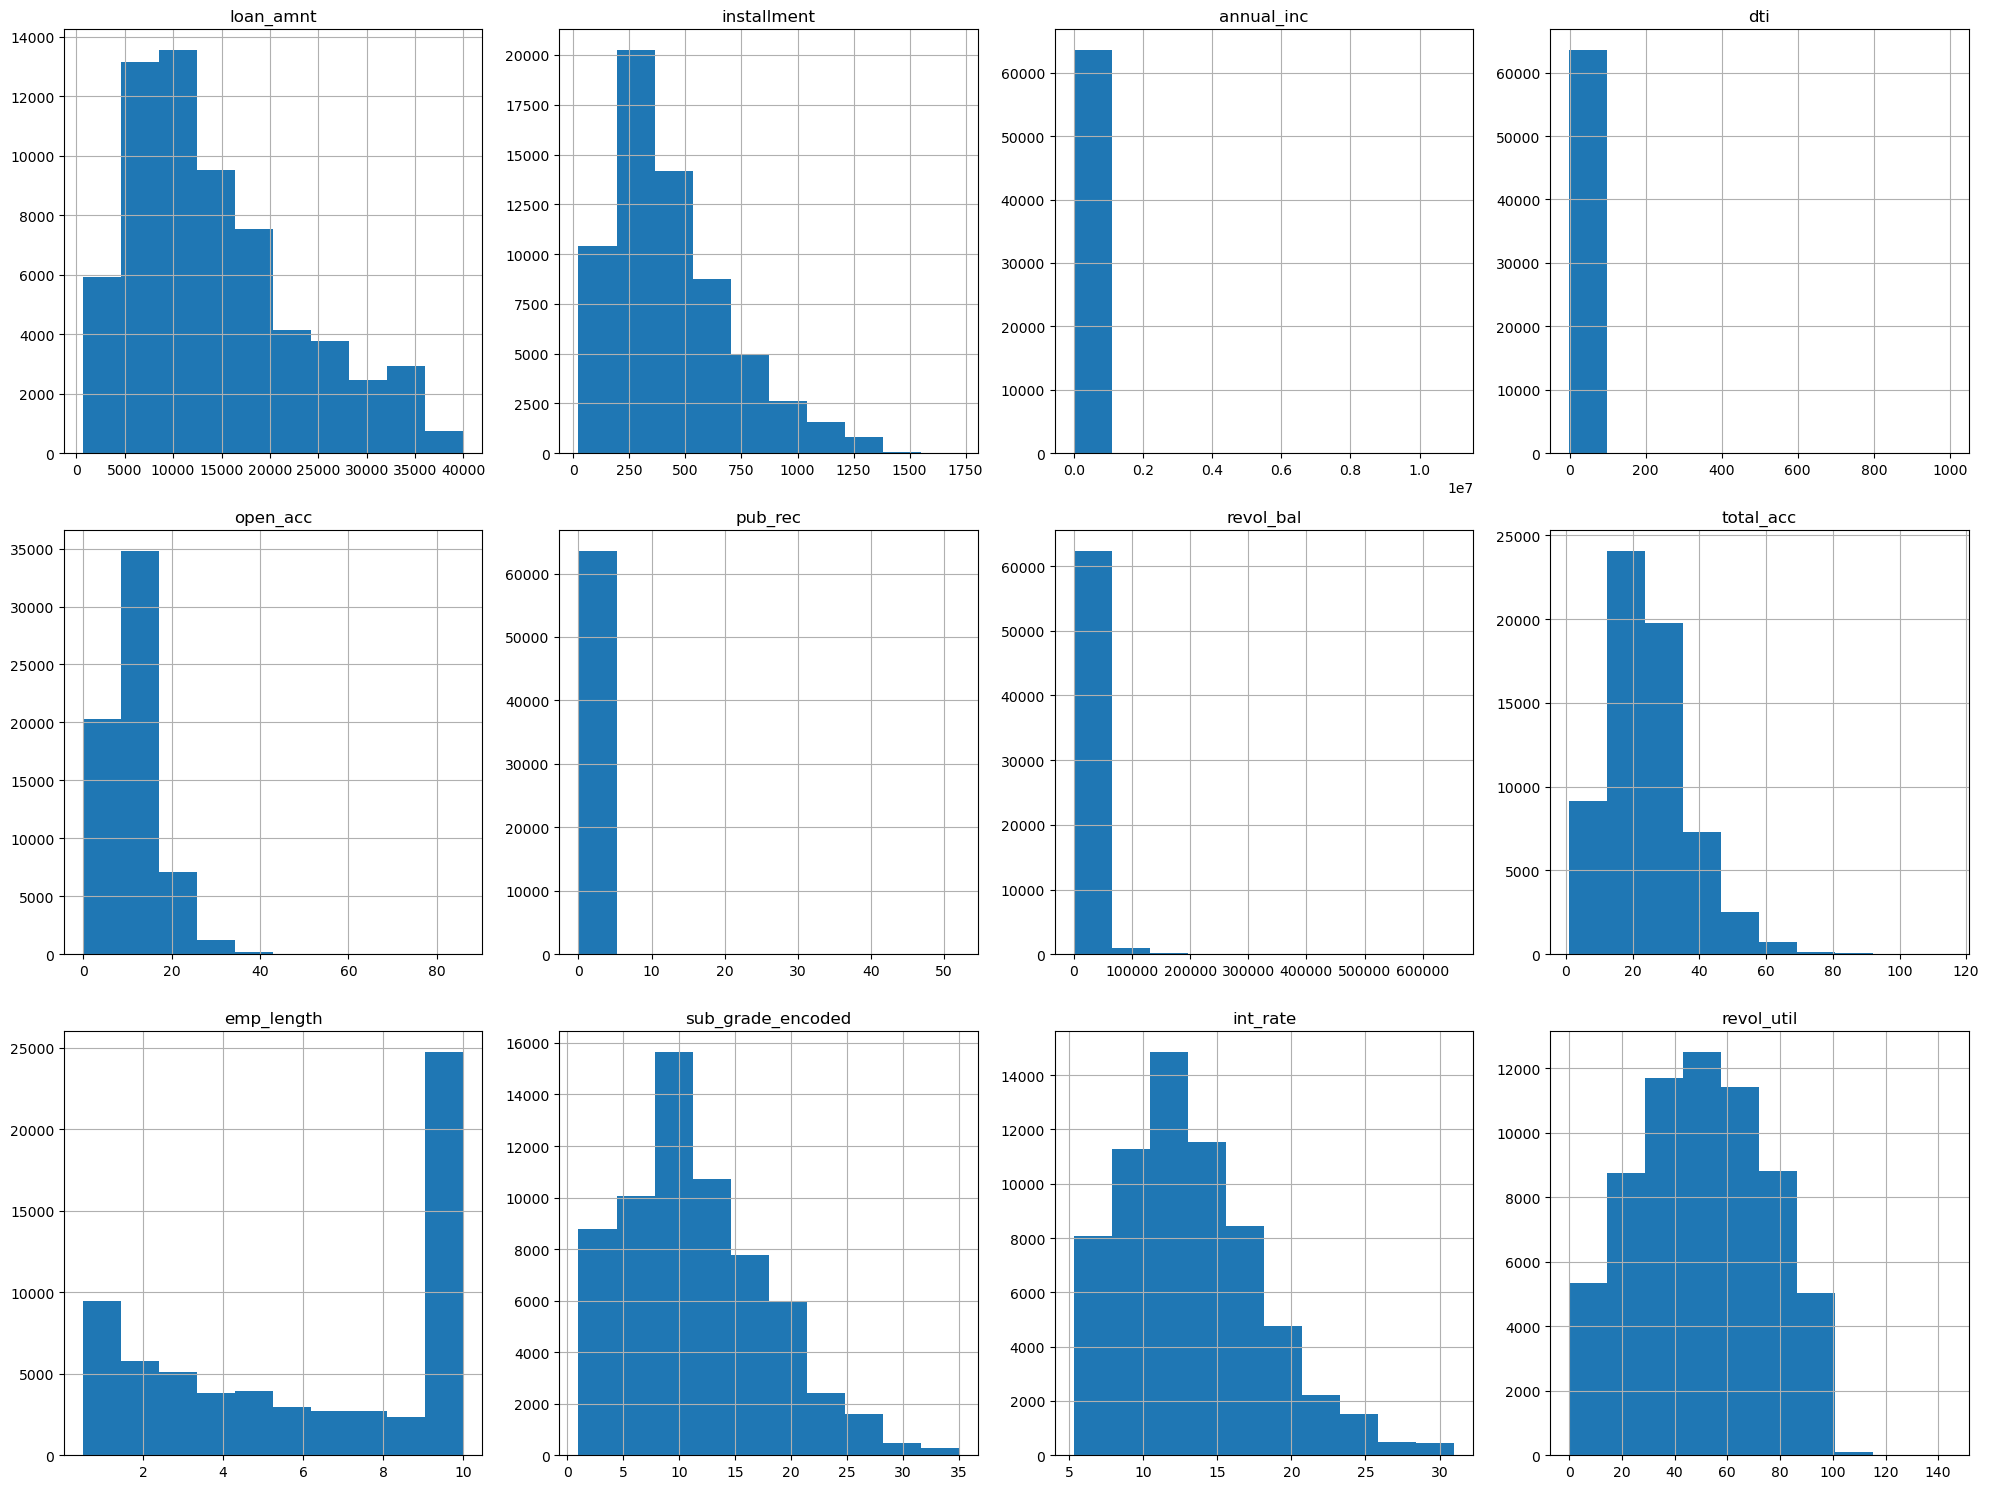

In [90]:
plot_histograms(numerical_features)

### Outlier Detection and Handling

In [91]:
def identify_outliers(df, threshold=3):
    """
    Identifies the number of outliers in each numerical column of a DataFrame based on Z-scores.

    Parameters:
    - df (pd.DataFrame): The DataFrame to analyze.
    - threshold (float): The Z-score threshold to identify outliers. Defaults to 3.

    Returns:
    - pd.DataFrame: A DataFrame with numerical columns and the count of outliers for each.
    """
    # Calculate Z-scores for numerical columns
    z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))

    # Identify where Z-scores exceed the threshold
    gt_thresh = z_scores > threshold

    # Count the number of outliers for each column
    outlier_volume = pd.DataFrame(gt_thresh.sum(), columns=["num_outliers"])

    # Sort the DataFrame by the number of outliers in descending order
    outlier_volume_sorted = outlier_volume.sort_values(by="num_outliers", ascending=False)

    return outlier_volume_sorted

In [92]:
identify_outliers(numerical_features)

num_outliers
revol_bal                   876
open_acc                    766
total_acc                   632
installment                 623
pub_rec                     571
int_rate                    505
sub_grade_encoded           382
annual_inc                  349
dti                         178
revol_util                    4
loan_amnt                     0
emp_length                    0

In [93]:
def plot_zscore_distribution(df):
    # Filter for numeric columns only
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    
    # Set up the figure for subplots
    num_columns = len(numeric_columns)
    fig, axes = plt.subplots(nrows=num_columns, ncols=1, figsize=(8, num_columns * 4))

    # Check if there's only one numeric column to avoid indexing issues
    if num_columns == 1:
        axes = [axes]

    # Loop through each numeric column
    for i, col in enumerate(numeric_columns):
        # Calculate the z-scores for the current column
        z_scores = stats.zscore(df[col].dropna())  # Remove NaN values to avoid errors

        # Create the distribution plot on the respective subplot axis
        sns.histplot(z_scores, bins=10, ax=axes[i])

        # Set titles and labels
        axes[i].set_title(f'Z-score Distribution for {col}')
        axes[i].set_xlabel('Z-score')
        axes[i].set_ylabel('Frequency')

    # Automatically adjust the layout for readability
    plt.tight_layout()
    plt.show();

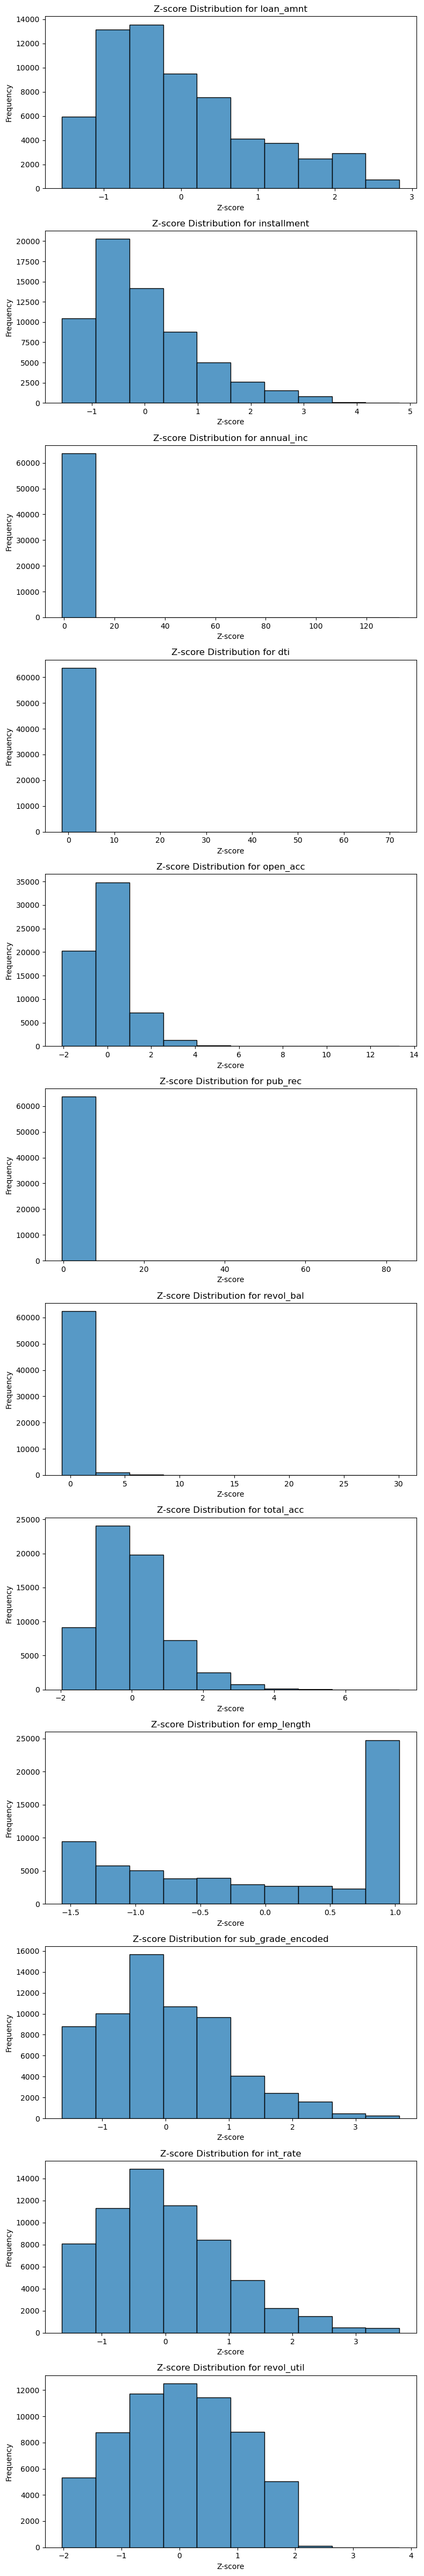

In [94]:
plot_zscore_distribution(numerical_features)

In [95]:
# Cap values beyond the 95th percentile and below the 5th percentile
df_winsorized = numerical_features.copy()

for col in df_winsorized.select_dtypes(include=[np.number]).columns:
    upper_limit = df_winsorized[col].quantile(0.95)
    lower_limit = df_winsorized[col].quantile(0.05)
    
    # Cap values both above and below in separate statements but with consistent references
    df_winsorized[col] = np.where(df_winsorized[col] > upper_limit, upper_limit, df_winsorized[col])
    df_winsorized[col] = np.where(df_winsorized[col] < lower_limit, lower_limit, df_winsorized[col])

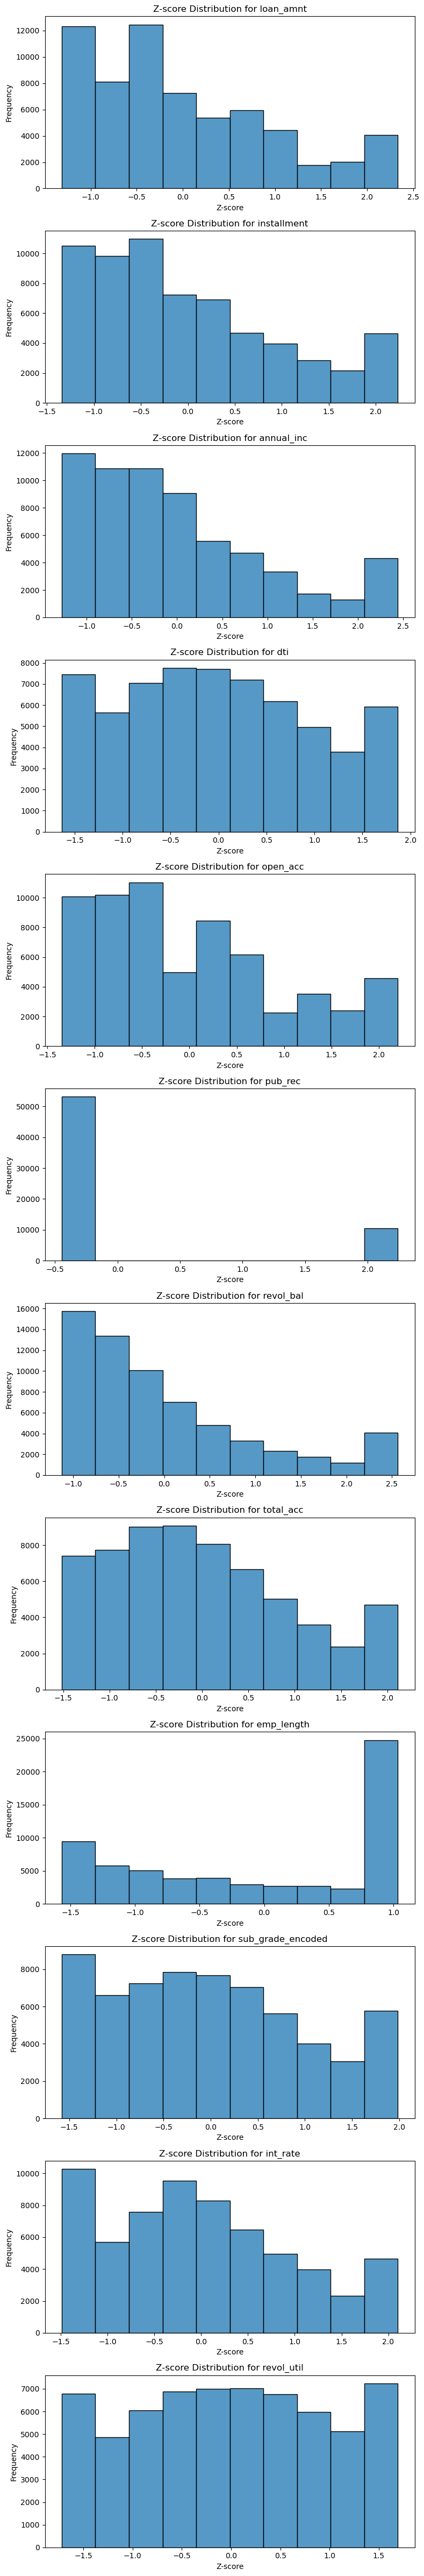

In [96]:
plot_zscore_distribution(df_winsorized)

In [97]:
df_winsorized.describe().T

count          mean           std       min       25%  \
loan_amnt          63689.0  14538.125108   8766.126194   3025.00   7925.00   
installment        63689.0    432.549458    243.003012    106.28    246.05   
annual_inc         63689.0  73289.107452  35504.849126  28000.00  46000.00   
dti                63689.0     18.258533      8.167695      4.91     11.85   
open_acc           63689.0     11.456437      4.793027      5.00      8.00   
pub_rec            63689.0      0.166073      0.372149      0.00      0.00   
revol_bal          63689.0  14422.633971  11428.840402   1564.40   5837.00   
total_acc          63689.0     24.289171     10.750858      8.00     16.00   
emp_length         63689.0      6.223186      3.652607      0.50      3.00   
sub_grade_encoded  63689.0     11.306348      5.891836      2.00      7.00   
int_rate           63689.0     13.073129      4.413735      6.49      9.58   
revol_util         63689.0     50.278211     23.881505      9.20     31.30   

                        50%       75%        max  
loan_amnt          12000.00  20000.00   35000.00  
installment          372.13    582.87     975.71  
annual_inc         65000.00  92000.00  160000.00  
dti                   17.79     24.33      33.52  
open_acc              11.00     14.00      22.00  
pub_rec                0.00      0.00       1.00  
revol_bal          11028.00  19671.00   43725.40  
total_acc             23.00     31.00      47.00  
emp_length             7.00     10.00      10.00  
sub_grade_encoded     11.00     15.00      23.00  
int_rate              12.69     15.99      22.35  
revol_util            50.30     69.40      90.70

In [98]:
for col in ['loan_amnt', 'installment', 'annual_inc', 'dti', 'open_acc', 'revol_bal', 'total_acc', 'emp_length', 'sub_grade_encoded', 'int_rate', 'revol_util']:
    print(f'Skewness of {col}: {stats.skew(df_winsorized[col].dropna()):.2f}')

Skewness of loan_amnt: 0.77
Skewness of installment: 0.72
Skewness of annual_inc: 0.92
Skewness of dti: 0.18
Skewness of open_acc: 0.64
Skewness of revol_bal: 1.15
Skewness of total_acc: 0.47
Skewness of emp_length: -0.27
Skewness of sub_grade_encoded: 0.31
Skewness of int_rate: 0.41
Skewness of revol_util: -0.01


In [99]:
# Apply log transformation to reduce skewness for loan_amnt, annual_inc, revol_bal, and revol_util.
df_winsorized['loan_amnt_log'] = np.log1p(df_winsorized['loan_amnt'])
df_winsorized['installment_log'] = np.log1p(df_winsorized['installment'])
df_winsorized['annual_inc_log'] = np.log1p(df_winsorized['annual_inc'])
df_winsorized['revol_bal_log'] = np.log1p(df_winsorized['revol_bal'])
df_winsorized['revol_util_log'] = np.log1p(df_winsorized['revol_util'])

In [100]:
# Apply sqrt transformation to reduce skewness for open_acc
df_winsorized['open_acc_sqrt'] = np.sqrt(df_winsorized['open_acc'])

Let's check to see if our transformations were effective on the distribution. 

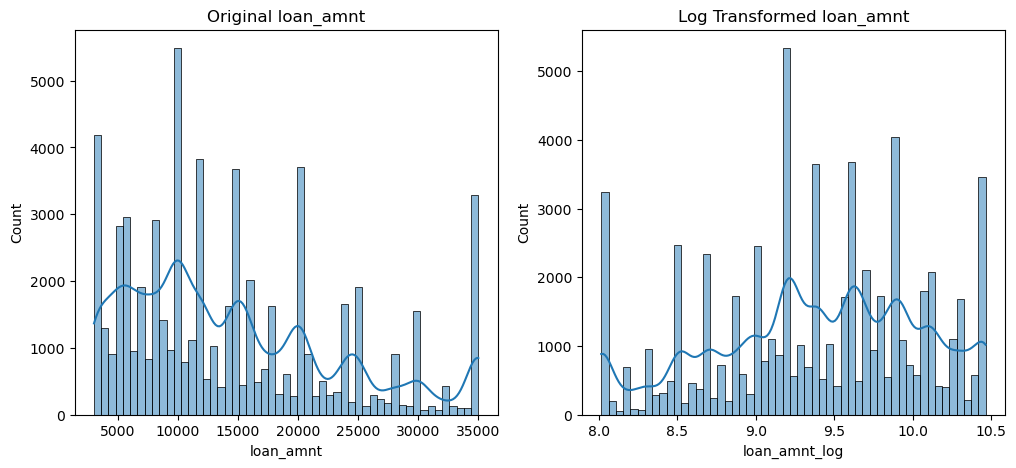

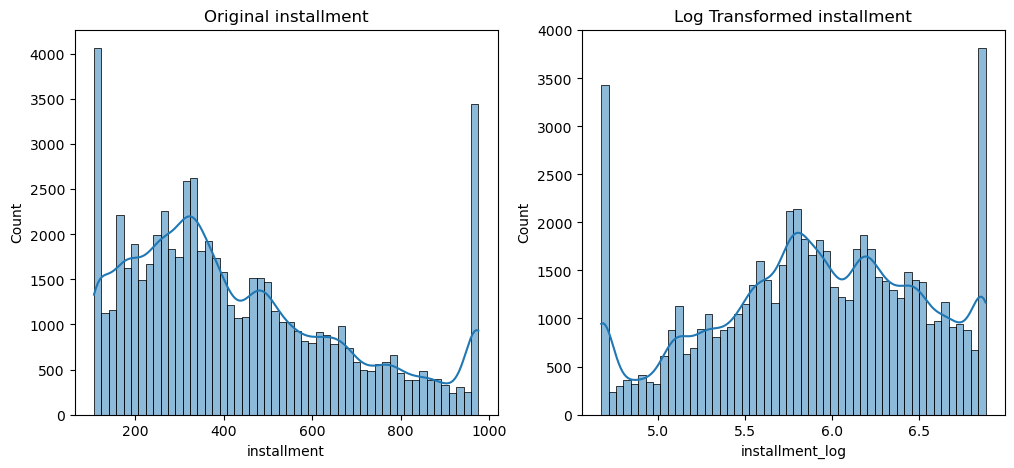

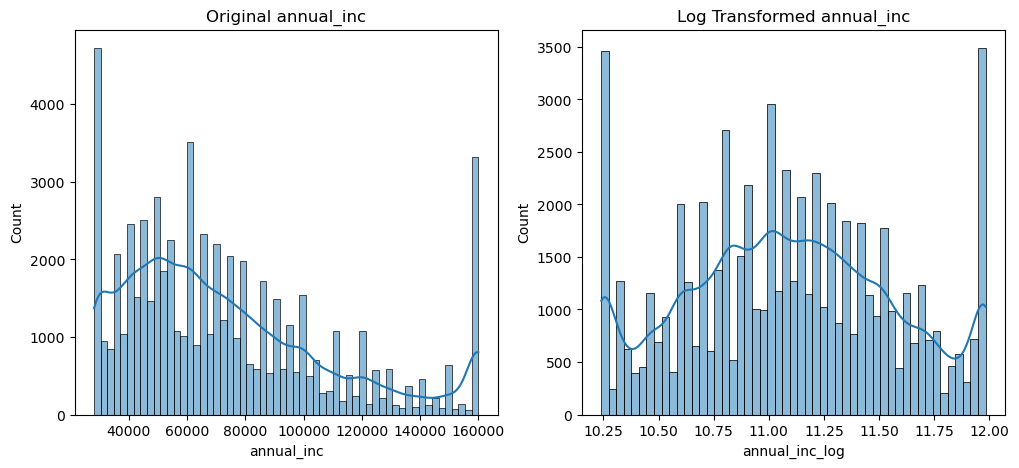

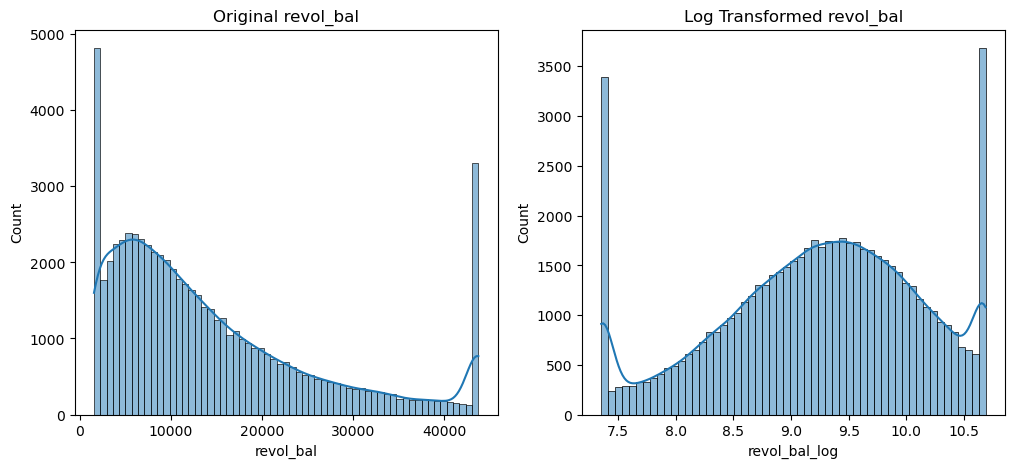

In [101]:
# Plot original vs. log-transformed columns
for col in ['loan_amnt', 'installment', 'annual_inc', 'revol_bal']:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df_winsorized[col], kde=True)
    plt.title(f'Original {col}')

    plt.subplot(1, 2, 2)
    sns.histplot(df_winsorized[col + '_log'], kde=True)
    plt.title(f'Log Transformed {col}')
    
    plt.show()

In [102]:
numerical_columns = [
    'loan_amnt_log', 'installment_log', 'annual_inc_log', 'revol_bal_log', 
    'dti', 'open_acc_sqrt', 'total_acc', 'emp_length', 'sub_grade_encoded', 
    'int_rate', 'revol_util'
]

In [103]:
# Initialize scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
robust_scaler = RobustScaler()

# Apply scalers
df_standard = df_winsorized.copy()
df_standard[numerical_columns] = standard_scaler.fit_transform(df_standard[numerical_columns])

df_minmax = df_winsorized.copy()
df_minmax[numerical_columns] = minmax_scaler.fit_transform(df_minmax[numerical_columns])

df_robust = df_winsorized.copy()
df_robust[numerical_columns] = robust_scaler.fit_transform(df_robust[numerical_columns])

# Check summary statistics to compare
print("StandardScaler Summary:")
df_standard[numerical_columns].describe().T

StandardScaler Summary:


count          mean       std       min       25%  \
loan_amnt_log      63689.0 -2.655234e-17  1.000008 -2.074870 -0.617339   
installment_log    63689.0 -5.712099e-17  1.000008 -2.039491 -0.654393   
annual_inc_log     63689.0  7.966816e-16  1.000008 -1.788736 -0.743832   
revol_bal_log      63689.0  1.660302e-15  1.000008 -2.126020 -0.636958   
dti                63689.0  2.043860e-16  1.000008 -1.634321 -0.784626   
open_acc_sqrt      63689.0 -1.352161e-16  1.000008 -1.541367 -0.692743   
total_acc          63689.0  4.590877e-17  1.000008 -1.515163 -0.771030   
emp_length         63689.0 -1.249522e-16  1.000008 -1.566889 -0.882441   
sub_grade_encoded  63689.0 -1.405712e-17  1.000008 -1.579545 -0.730907   
int_rate           63689.0 -2.978770e-17  1.000008 -1.491521 -0.791429   
revol_util         63689.0 -1.132379e-16  1.000008 -1.720098 -0.794689   

                        50%       75%       max  
loan_amnt_log      0.010597  0.783772  1.630818  
installment_log    0.030288  0.773776  1.628119  
annual_inc_log    -0.016097  0.715127  1.879919  
revol_bal_log      0.082703  0.737347  1.640974  
dti               -0.057365  0.743357  1.868530  
open_acc_sqrt      0.006657  0.615565  1.974772  
total_acc         -0.119914  0.624218  2.112483  
emp_length         0.212676  1.034013  1.034013  
sub_grade_encoded -0.051996  0.626915  1.984737  
int_rate          -0.086805  0.660867  2.101835  
revol_util         0.000912  0.800701  1.692611

In [104]:
print("MinMaxScaler Summary:")
df_minmax[numerical_columns].describe().T

MinMaxScaler Summary:


count      mean       std  min       25%       50%  \
loan_amnt_log      63689.0  0.559915  0.269858  0.0  0.393323  0.562775   
installment_log    63689.0  0.556082  0.272659  0.0  0.377657  0.564340   
annual_inc_log     63689.0  0.487573  0.272582  0.0  0.284819  0.483185   
revol_bal_log      63689.0  0.564381  0.265466  0.0  0.395292  0.586336   
dti                63689.0  0.466569  0.285484  0.0  0.242573  0.450192   
open_acc_sqrt      63689.0  0.438369  0.284405  0.0  0.241351  0.440262   
total_acc          63689.0  0.417671  0.275663  0.0  0.205128  0.384615   
emp_length         63689.0  0.602441  0.384485  0.0  0.263158  0.684211   
sub_grade_encoded  63689.0  0.443159  0.280564  0.0  0.238095  0.428571   
int_rate           63689.0  0.415078  0.278294  0.0  0.194830  0.390921   
revol_util         63689.0  0.504027  0.293025  0.0  0.271166  0.504294   

                        75%  max  
loan_amnt_log      0.771420  1.0  
installment_log    0.767057  1.0  
annual_inc_log     0.682502  1.0  
revol_bal_log      0.760120  1.0  
dti                0.678784  1.0  
open_acc_sqrt      0.613438  1.0  
total_acc          0.589744  1.0  
emp_length         1.000000  1.0  
sub_grade_encoded  0.619048  1.0  
int_rate           0.598991  1.0  
revol_util         0.738650  1.0

In [105]:
print("RobustScaler Summary:")
df_robust[numerical_columns].describe().T

RobustScaler Summary:


count      mean       std       min       25%  50%  \
loan_amnt_log      63689.0 -0.007564  0.713725 -1.488438 -0.448170  0.0   
installment_log    63689.0 -0.021207  0.700203 -1.449253 -0.479412  0.0   
annual_inc_log     63689.0  0.011033  0.685426 -1.215003 -0.498805  0.0   
revol_bal_log      63689.0 -0.060178  0.727646 -1.607157 -0.523655  0.0   
dti                63689.0  0.037543  0.654463 -1.032051 -0.475962  0.0   
open_acc_sqrt      63689.0 -0.005088  0.764352 -1.183225 -0.534583  0.0   
total_acc          63689.0  0.085945  0.716724 -1.000000 -0.466667  0.0   
emp_length         63689.0 -0.110973  0.521801 -0.928571 -0.571429  0.0   
sub_grade_encoded  63689.0  0.038294  0.736479 -1.125000 -0.500000  0.0   
int_rate           63689.0  0.059771  0.688570 -0.967239 -0.485179  0.0   
revol_util         63689.0 -0.000572  0.626811 -1.078740 -0.498688  0.0   

                        75%       max  
loan_amnt_log      0.551830  1.156382  
installment_log    0.520588  1.118796  
annual_inc_log     0.501195  1.299567  
revol_bal_log      0.476345  1.133861  
dti                0.524038  1.260417  
open_acc_sqrt      0.465417  1.504320  
total_acc          0.533333  1.600000  
emp_length         0.428571  0.428571  
sub_grade_encoded  0.500000  1.500000  
int_rate           0.514821  1.507020  
revol_util         0.501312  1.060367

In [106]:
df_minmax.head()

loan_amnt  installment  annual_inc       dti  open_acc  pub_rec  revol_bal  \
0     5000.0       162.49     55000.0  0.080741       7.0      1.0     6001.0   
1    14000.0       322.79     48000.0  0.677735      16.0      0.0    11894.0   
2     4000.0       131.89     46000.0  0.232436       5.0      1.0     3556.0   
3     7200.0       246.01     33000.0  0.198182      14.0      1.0     3466.0   
4    19500.0       697.86     99000.0  0.391821       6.0      0.0     3959.0   

   total_acc  emp_length  sub_grade_encoded  int_rate  revol_util  \
0   0.025641    1.000000           0.285714  0.252207    0.532515   
1   0.384615    1.000000           0.476190  0.447667    0.219632   
2   0.000000    1.000000           0.380952  0.315259    0.361963   
3   0.692308    0.578947           0.428571  0.472257    0.157055   
4   0.282051    0.157895           0.714286  0.679697    0.899387   

   loan_amnt_log  installment_log  annual_inc_log  revol_bal_log  \
0       0.205216         0.190746        0.387340       0.403612   
1       0.625736         0.500126        0.309237       0.609037   
2       0.114088         0.096923        0.284819       0.246493   
3       0.354138         0.377583        0.094265       0.238797   
4       0.761079         0.848448        0.724574       0.278725   

   revol_util_log  open_acc_sqrt  
0        3.981549       0.166921  
1        3.335770       0.718697  
2        3.681351       0.000000  
3        3.135494       0.613438  
4        4.424847       0.086957

## 7. Feature Engineering

Let's create a few features to help our model learn better.

In [107]:
def add_and_scale_features(df, scaler=None):
    """
    Adds new engineered features to the DataFrame and scales them using the provided scaler.
    Checks and handles potential issues like NaN, infinity, or extremely large values.

    Parameters:
    - df (pd.DataFrame): The DataFrame to which the new features will be added.
    - scaler (scaler object, optional): The scaler to use for scaling the new features (e.g., MinMaxScaler, StandardScaler, RobustScaler).
                                         If not provided, MinMaxScaler is used by default.
    
    Returns:
    - pd.DataFrame: The DataFrame with new features added and scaled.
    """
    # Handle potential division issues in the new features
    df['loan_amnt'] = df['loan_amnt'].replace(0, np.nan)  # Replace zero loan amounts with NaN to prevent extreme values
    df['total_acc'] = df['total_acc'].replace(0, 1)  # Replace zero total_acc with 1 to avoid division by zero
    df['open_acc'] = df['open_acc'].replace(0, 1)  # Replace zero open_acc with 1 to avoid division by zero

    # Create new features
    df['income_to_loan_ratio'] = df['annual_inc'] / (df['loan_amnt'] + 1)
    df['revol_bal_to_total_acc'] = df['revol_bal'] / (df['total_acc'] + 1)
    df['credit_age'] = df['emp_length'] / (df['open_acc'] + 1)

    # List of new feature columns
    new_features = ['income_to_loan_ratio', 'revol_bal_to_total_acc', 'credit_age']
    
    # Replace inf values with NaN and then fill NaN with a value (e.g., 0 or the median)
    df[new_features] = df[new_features].replace([np.inf, -np.inf], np.nan)
    df[new_features] = df[new_features].fillna(df[new_features].median())  # Replace with median or another value as needed

    # Initialize the scaler if not provided
    if scaler is None:
        scaler = MinMaxScaler()

    # Apply the scaler to the new features
    df[new_features] = scaler.fit_transform(df[new_features])
    
    # Return the modified DataFrame
    return df

In [108]:
df_minmax = add_and_scale_features(df_minmax, scaler=MinMaxScaler())
df_standard = add_and_scale_features(df_standard, scaler=StandardScaler())
df_robust = add_and_scale_features(df_robust, scaler=RobustScaler())

In [109]:
df_minmax.describe().T

count          mean           std           min  \
loan_amnt               63689.0  14538.125108   8766.126194   3025.000000   
installment             63689.0    432.549458    243.003012    106.280000   
annual_inc              63689.0  73289.107452  35504.849126  28000.000000   
dti                     63689.0      0.466569      0.285484      0.000000   
open_acc                63689.0     11.456437      4.793027      5.000000   
pub_rec                 63689.0      0.166073      0.372149      0.000000   
revol_bal               63689.0  14422.633971  11428.840402   1564.400000   
total_acc               63689.0      0.468292      0.285942      0.025641   
emp_length              63689.0      0.602441      0.384485      0.000000   
sub_grade_encoded       63689.0      0.443159      0.280564      0.000000   
int_rate                63689.0      0.415078      0.278294      0.000000   
revol_util              63689.0      0.504027      0.293025      0.000000   
loan_amnt_log           63689.0      0.559915      0.269858      0.000000   
installment_log         63689.0      0.556082      0.272659      0.000000   
annual_inc_log          63689.0      0.487573      0.272582      0.000000   
revol_bal_log           63689.0      0.564381      0.265466      0.000000   
revol_util_log          63689.0      3.790154      0.598045      2.322388   
open_acc_sqrt           63689.0      0.438369      0.284405      0.000000   
income_to_loan_ratio    63689.0      0.114563      0.101575      0.000000   
revol_bal_to_total_acc  63689.0      0.217607      0.183237      0.000000   
credit_age              63689.0      0.332665      0.258930      0.000000   

                                 25%           50%           75%  \
loan_amnt                7925.000000  12000.000000  20000.000000   
installment               246.050000    372.130000    582.870000   
annual_inc              46000.000000  65000.000000  92000.000000   
dti                         0.242573      0.450192      0.678784   
open_acc                    8.000000     11.000000     14.000000   
pub_rec                     0.000000      0.000000      0.000000   
revol_bal                5837.000000  11028.000000  19671.000000   
total_acc                   0.230769      0.410256      0.666667   
emp_length                  0.263158      0.684211      1.000000   
sub_grade_encoded           0.238095      0.428571      0.619048   
int_rate                    0.194830      0.390921      0.598991   
revol_util                  0.271166      0.504294      0.738650   
loan_amnt_log               0.393323      0.562775      0.771420   
installment_log             0.377657      0.564340      0.767057   
annual_inc_log              0.284819      0.483185      0.682502   
revol_bal_log               0.395292      0.586336      0.760120   
revol_util_log              3.475067      3.937691      4.254193   
open_acc_sqrt               0.241351      0.440262      0.613438   
income_to_loan_ratio        0.051842      0.081686      0.138255   
revol_bal_to_total_acc      0.080127      0.166999      0.304349   
credit_age                  0.112782      0.296053      0.500000   

                                  max  
loan_amnt                35000.000000  
installment                975.710000  
annual_inc              160000.000000  
dti                          1.000000  
open_acc                    22.000000  
pub_rec                      1.000000  
revol_bal                43725.400000  
total_acc                    1.000000  
emp_length                   1.000000  
sub_grade_encoded            1.000000  
int_rate                     1.000000  
revol_util                   1.000000  
loan_amnt_log                1.000000  
installment_log              1.000000  
annual_inc_log               1.000000  
revol_bal_log                1.000000  
revol_util_log               4.518522  
open_acc_sqrt                1.000000  
income_to_loan_ratio         1.000000  
revol_bal_to_total_acc       1.000

In [110]:
df_standard.describe().T

count          mean           std           min  \
loan_amnt               63689.0  1.453813e+04   8766.126194   3025.000000   
installment             63689.0  4.325495e+02    243.003012    106.280000   
annual_inc              63689.0  7.328911e+04  35504.849126  28000.000000   
dti                     63689.0  2.043860e-16      1.000008     -1.634321   
open_acc                63689.0  1.145644e+01      4.793027      5.000000   
pub_rec                 63689.0  1.660726e-01      0.372149      0.000000   
revol_bal               63689.0  1.442263e+04  11428.840402   1564.400000   
total_acc               63689.0  4.590877e-17      1.000008     -1.515163   
emp_length              63689.0 -1.249522e-16      1.000008     -1.566889   
sub_grade_encoded       63689.0 -1.405712e-17      1.000008     -1.579545   
int_rate                63689.0 -2.978770e-17      1.000008     -1.491521   
revol_util              63689.0 -1.132379e-16      1.000008     -1.720098   
loan_amnt_log           63689.0 -2.655234e-17      1.000008     -2.074870   
installment_log         63689.0 -5.712099e-17      1.000008     -2.039491   
annual_inc_log          63689.0  7.966816e-16      1.000008     -1.788736   
revol_bal_log           63689.0  1.660302e-15      1.000008     -2.126020   
revol_util_log          63689.0  3.790154e+00      0.598045      2.322388   
open_acc_sqrt           63689.0 -1.352161e-16      1.000008     -1.541367   
income_to_loan_ratio    63689.0 -8.925155e-18      1.000008     -1.127876   
revol_bal_to_total_acc  63689.0 -3.793191e-18      1.000008    -10.846438   
credit_age              63689.0 -5.578222e-18      1.000008     -2.589020   

                                 25%           50%           75%  \
loan_amnt                7925.000000  12000.000000  20000.000000   
installment               246.050000    372.130000    582.870000   
annual_inc              46000.000000  65000.000000  92000.000000   
dti                        -0.784626     -0.057365      0.743357   
open_acc                    8.000000     11.000000     14.000000   
pub_rec                     0.000000      0.000000      0.000000   
revol_bal                5837.000000  11028.000000  19671.000000   
total_acc                  -0.771030     -0.119914      0.624218   
emp_length                 -0.882441      0.212676      1.034013   
sub_grade_encoded          -0.730907     -0.051996      0.626915   
int_rate                   -0.791429     -0.086805      0.660867   
revol_util                 -0.794689      0.000912      0.800701   
loan_amnt_log              -0.617339      0.010597      0.783772   
installment_log            -0.654393      0.030288      0.773776   
annual_inc_log             -0.743832     -0.016097      0.715127   
revol_bal_log              -0.636958      0.082703      0.737347   
revol_util_log              3.475067      3.937691      4.254193   
open_acc_sqrt              -0.692743      0.006657      0.615565   
income_to_loan_ratio       -0.617492     -0.323676      0.233243   
revol_bal_to_total_acc     -0.132040     -0.052176      0.089691   
credit_age                 -0.753588      0.156413      0.808164   

                                  max  
loan_amnt                35000.000000  
installment                975.710000  
annual_inc              160000.000000  
dti                          1.868530  
open_acc                    22.000000  
pub_rec                      1.000000  
revol_bal                43725.400000  
total_acc                    2.112483  
emp_length                   1.034013  
sub_grade_encoded            1.984737  
int_rate                     2.101835  
revol_util                   1.692611  
loan_amnt_log                1.630818  
installment_log              1.628119  
annual_inc_log               1.879919  
revol_bal_log                1.640974  
revol_util_log               4.518522  
open_acc_sqrt                1.974772  
income_to_loan_ratio         8.717143  
revol_bal_to_total_acc      12.289

In [111]:
df_robust.describe().T

count          mean           std           min  \
loan_amnt               63689.0  14538.125108   8766.126194   3025.000000   
installment             63689.0    432.549458    243.003012    106.280000   
annual_inc              63689.0  73289.107452  35504.849126  28000.000000   
dti                     63689.0      0.037543      0.654463     -1.032051   
open_acc                63689.0     11.456437      4.793027      5.000000   
pub_rec                 63689.0      0.166073      0.372149      0.000000   
revol_bal               63689.0  14422.633971  11428.840402   1564.400000   
total_acc               63689.0      0.120472      0.735591     -1.000000   
emp_length              63689.0     -0.110973      0.521801     -0.928571   
sub_grade_encoded       63689.0      0.038294      0.736479     -1.125000   
int_rate                63689.0      0.059771      0.688570     -0.967239   
revol_util              63689.0     -0.000572      0.626811     -1.078740   
loan_amnt_log           63689.0     -0.007564      0.713725     -1.488438   
installment_log         63689.0     -0.021207      0.700203     -1.449253   
annual_inc_log          63689.0      0.011033      0.685426     -1.215003   
revol_bal_log           63689.0     -0.060178      0.727646     -1.607157   
revol_util_log          63689.0      3.790154      0.598045      2.322388   
open_acc_sqrt           63689.0     -0.005088      0.764352     -1.183225   
income_to_loan_ratio    63689.0      0.380466      1.175464     -0.945302   
revol_bal_to_total_acc  63689.0      0.474073      1.833179     -0.745405   
credit_age              63689.0     -0.137822      0.653888     -1.920455   

                                 25%           50%           75%  \
loan_amnt                7925.000000  12000.000000  20000.000000   
installment               246.050000    372.130000    582.870000   
annual_inc              46000.000000  65000.000000  92000.000000   
dti                        -0.475962      0.000000      0.524038   
open_acc                    8.000000     11.000000     14.000000   
pub_rec                     0.000000      0.000000      0.000000   
revol_bal                5837.000000  11028.000000  19671.000000   
total_acc                  -0.466667      0.066667      0.666667   
emp_length                 -0.571429      0.000000      0.428571   
sub_grade_encoded          -0.500000      0.000000      0.500000   
int_rate                   -0.485179      0.000000      0.514821   
revol_util                 -0.498688      0.000000      0.501312   
loan_amnt_log              -0.448170      0.000000      0.551830   
installment_log            -0.479412      0.000000      0.520588   
annual_inc_log             -0.498805      0.000000      0.501195   
revol_bal_log              -0.523655      0.000000      0.476345   
revol_util_log              3.475067      3.937691      4.254193   
open_acc_sqrt              -0.534583      0.000000      0.465417   
income_to_loan_ratio       -0.345368      0.000000      0.654632   
revol_bal_to_total_acc     -0.370994      0.000000      0.629006   
credit_age                 -0.590909      0.000000      0.409091   

                                  max  
loan_amnt                35000.000000  
installment                975.710000  
annual_inc              160000.000000  
dti                          1.260417  
open_acc                    22.000000  
pub_rec                      1.000000  
revol_bal                43725.400000  
total_acc                    1.600000  
emp_length                   0.428571  
sub_grade_encoded            1.500000  
int_rate                     1.507020  
revol_util                   1.060367  
loan_amnt_log                1.156382  
installment_log              1.118796  
annual_inc_log               1.299567  
revol_bal_log                1.133861  
revol_util_log               4.518522  
open_acc_sqrt                1.504320  
income_to_loan_ratio        10.627073  
revol_bal_to_total_acc      42.147

In [112]:
df_minmax_combined = pd.concat([df_minmax, categorical_features], axis=1)
df_standard_combined = pd.concat([df_standard, categorical_features], axis=1)
df_robust_combined = pd.concat([df_robust, categorical_features], axis=1)

In [113]:
categorical_features.head()

term  loan_status  home_MORTGAGE  home_OTHER  home_OWN  home_RENT  \
0    36            0           True       False     False      False   
1    60            0           True       False     False      False   
2    36            1          False       False     False       True   
3    36            0           True       False     False      False   
4    36            0          False       False     False       True   

   verification_Not Verified  verification_Source Verified  \
0                       True                         False   
1                      False                          True   
2                      False                         False   
3                       True                         False   
4                       True                         False   

   verification_Verified  purpose_car  purpose_credit_card  \
0                  False        False                 True   
1                  False        False                False   
2                   True        False                False   
3                  False        False                False   
4                  False        False                False   

   purpose_debt_consolidation  purpose_educational  purpose_home_improvement  \
0                       False                False                     False   
1                        True                False                     False   
2                       False                False                     False   
3                       False                False                      True   
4                        True                False                     False   

   purpose_house  purpose_major_purchase  purpose_medical  purpose_moving  \
0          False                   False            False           False   
1          False                   False            False           False   
2          False                   False            False            True   
3          False                   False            False           False   
4          False                   False            False           False   

   purpose_other  purpose_renewable_energy  purpose_small_business  \
0          False                     False                   False   
1          False                     False                   False   
2          False                     False                   False   
3          False                     False                   False   
4          False                     False                   False   

   purpose_vacation  purpose_wedding  
0             False            False  
1             False            False  
2             False            False  
3             False            False  
4             False            False

In [114]:
df_minmax_combined.head()

loan_amnt  installment  annual_inc       dti  open_acc  pub_rec  revol_bal  \
0     5000.0       162.49     55000.0  0.080741       7.0      1.0     6001.0   
1    14000.0       322.79     48000.0  0.677735      16.0      0.0    11894.0   
2     4000.0       131.89     46000.0  0.232436       5.0      1.0     3556.0   
3     7200.0       246.01     33000.0  0.198182      14.0      1.0     3466.0   
4    19500.0       697.86     99000.0  0.391821       6.0      0.0     3959.0   

   total_acc  emp_length  sub_grade_encoded  int_rate  revol_util  \
0   0.025641    1.000000           0.285714  0.252207    0.532515   
1   0.384615    1.000000           0.476190  0.447667    0.219632   
2   1.000000    1.000000           0.380952  0.315259    0.361963   
3   0.692308    0.578947           0.428571  0.472257    0.157055   
4   0.282051    0.157895           0.714286  0.679697    0.899387   

   loan_amnt_log  installment_log  annual_inc_log  revol_bal_log  \
0       0.205216         0.190746        0.387340       0.403612   
1       0.625736         0.500126        0.309237       0.609037   
2       0.114088         0.096923        0.284819       0.246493   
3       0.354138         0.377583        0.094265       0.238797   
4       0.761079         0.848448        0.724574       0.278725   

   revol_util_log  open_acc_sqrt  income_to_loan_ratio  \
0        3.981549       0.166921              0.195829   
1        3.335770       0.718697              0.050472   
2        3.681351       0.000000              0.205418   
3        3.135494       0.613438              0.072640   
4        4.424847       0.086957              0.082125   

   revol_bal_to_total_acc  credit_age  term  loan_status  home_MORTGAGE  \
0                0.121117    0.750000    36            0           True   
1                0.186569    0.352941    60            0           True   
2                0.023794    1.000000    36            1          False   
3                0.030248    0.231579    36            0           True   
4                0.055097    0.135338    36            0          False   

   home_OTHER  home_OWN  home_RENT  verification_Not Verified  \
0       False     False      False                       True   
1       False     False      False                      False   
2       False     False       True                      False   
3       False     False      False                       True   
4       False     False       True                       True   

   verification_Source Verified  verification_Verified  purpose_car  \
0                         False                  False        False   
1                          True                  False        False   
2                         False                   True        False   
3                         False                  False        False   
4                         False                  False        False   

   purpose_credit_card  purpose_debt_consolidation  purpose_educational  \
0                 True                       False                False   
1                False                        True                False   
2                False                       False                False   
3                False                       False                False   
4                False                        True                False   

   purpose_home_improvement  purpose_house  purpose_major_purchase  \
0                     False          False                   False   
1                     False          False                   False   
2                     False          False                   False   
3                      True          False                   False   
4                     False          False                   False   

   purpose_medical  purpose_moving  purpose_other  purpose_renewable_energy  \
0            False           False          False                     False   
1            False           False          

In [115]:
df_minmax_combined.shape

(63689, 44)

In [116]:
df_minmax_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63689 entries, 0 to 63688
Data columns (total 44 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   loan_amnt                     63689 non-null  float64
 1   installment                   63689 non-null  float64
 2   annual_inc                    63689 non-null  float64
 3   dti                           63689 non-null  float64
 4   open_acc                      63689 non-null  float64
 5   pub_rec                       63689 non-null  float64
 6   revol_bal                     63689 non-null  float64
 7   total_acc                     63689 non-null  float64
 8   emp_length                    63689 non-null  float64
 9   sub_grade_encoded             63689 non-null  float64
 10  int_rate                      63689 non-null  float64
 11  revol_util                    63689 non-null  float64
 12  loan_amnt_log                 63689 non-null  float64
 13  i

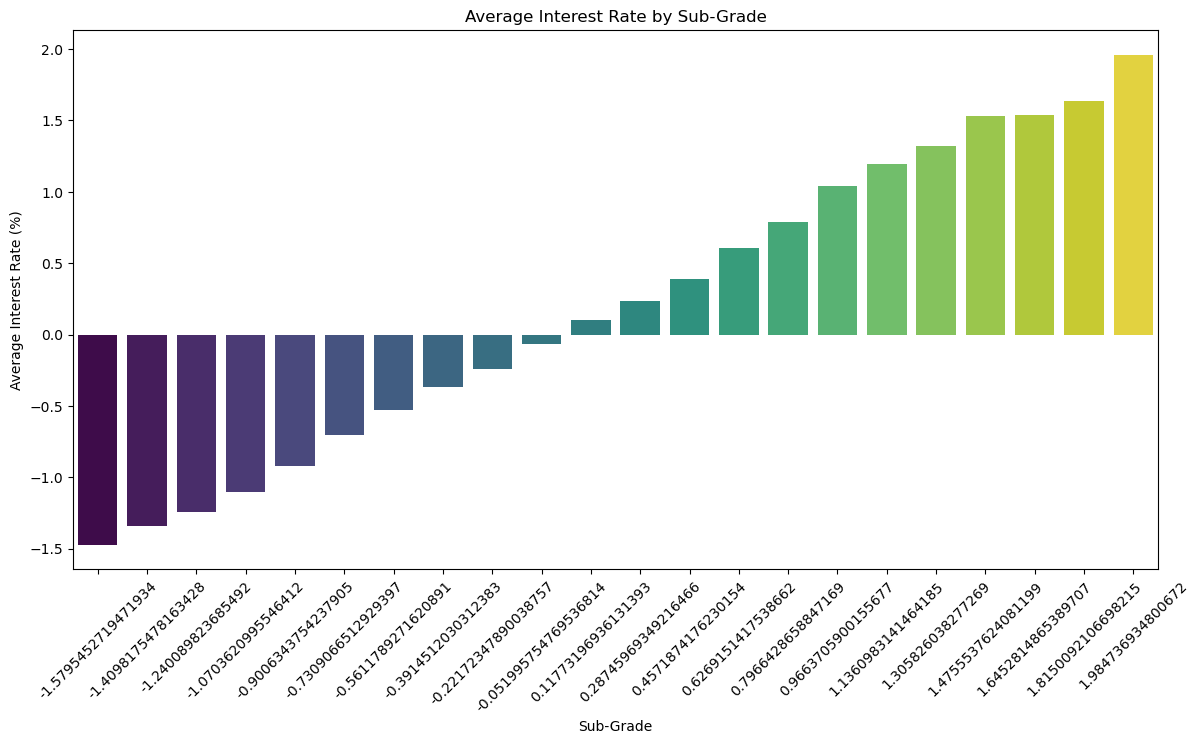

In [259]:
# Assuming df is your DataFrame with 'sub_grade' and 'int_rate'
plt.figure(figsize=(14, 7))

# Grouping data by 'sub_grade' and calculating the mean 'int_rate'
sub_grade_avg_int_rate = df_standard_combined.groupby('sub_grade_encoded')['int_rate'].mean().sort_index()

# Plotting the average interest rate for each sub-grade
sns.barplot(x=sub_grade_avg_int_rate.index, y=sub_grade_avg_int_rate.values, hue=sub_grade_avg_int_rate.index, palette='viridis', legend=False)
plt.title('Average Interest Rate by Sub-Grade')
plt.xlabel('Sub-Grade')
plt.ylabel('Average Interest Rate (%)')
plt.xticks(rotation=45)
plt.show();

## 8. Modelling

1. We'll split our data into train and test sets.
2. Handle the class imbalance using SMOTE
3. Create a baseline model
4. Evaluate
5. Carry out hyperparameter tuning
6. Experiment with other models
7. Repeat from step 4 until we're satisfied with our results

In [117]:
columns_to_drop = [
    'loan_amnt',            # Original column before log transformation
    'installment',          # Original column before log transformation
    'annual_inc',           # Original column before log transformation
    'revol_bal',            # Original column before log transformation
    'revol_util',           # Original column before log transformation
    'open_acc',             # Original column before square root transformation
    'loan_status'           # Target variable to be dropped for X
]

In [118]:
X = df_standard_combined.drop(columns=columns_to_drop)
y = df_standard_combined["loan_status"]

In [119]:
# First split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [120]:
for dframe in [X_train, X_test, y_train, y_test]:
    print(f"Shape: {dframe.shape}")

Shape: (50951, 37)
Shape: (12738, 37)
Shape: (50951,)
Shape: (12738,)


In [121]:
# Apply SMOTE on the training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [122]:
len(X_train_resampled), len(y_train_resampled), len(X_train), len(y_train)

(82028, 82028, 50951, 50951)

In [123]:
def model_evaluation_report(X_test, y_test, y_pred, y_prob):
    
    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) #classifier.predict_proba(X_test)[:,1])

    # Display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-Score: {f1}')
    print(f'ROC-AUC: {roc_auc}')
    print(f'Confusion Matrix:\n{cm}')

In [124]:
# Define the model (Logistic Regression)
log_reg = LogisticRegression(max_iter=500, solver="liblinear", random_state=42)

# Perform cross-validation on the training set
cv_scores = cross_val_score(log_reg, X_train_resampled, y_train_resampled, cv=5)

# Print the average cross-validation score
print(f'Cross-validation scores: {cv_scores}')
print(f'Average CV score: {cv_scores.mean()}')

Cross-validation scores: [0.59971961 0.74344752 0.77953188 0.76915575 0.77317891]
Average CV score: 0.7330067333250527


In [125]:
log_reg.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=500, random_state=42, solver='liblinear')

In [126]:
# Final evaluation using the test set
predictions = log_reg.predict(X_test)
predictions

array([0, 0, 1, ..., 0, 0, 0])

In [127]:
y_prob = log_reg.predict_proba(X_test)[:,1]

In [128]:
model_evaluation_report(X_test, y_test, predictions, y_prob)

Accuracy: 0.7395980530695556
Precision: 0.3568695652173913
Recall: 0.4113873295910184
F1-Score: 0.38219407710933134
ROC-AUC: 0.681847836604023
Confusion Matrix:
[[8395 1849]
 [1468 1026]]


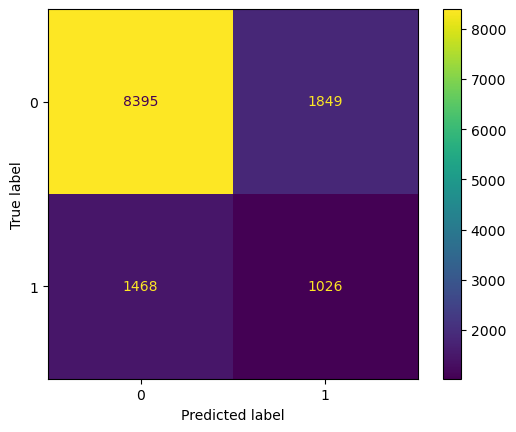

In [129]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, predictions), display_labels = [0, 1])
cm_display.plot()
plt.show()

In [130]:
def plot_roc_curves(models, X_test, y_test):
    """
    Plots ROC curves for multiple models on the same plot for comparison.
    
    Parameters:
    - models: A list of tuples, where each tuple contains the model and a label, e.g. (model, 'Model Name')
    - X_test: Test feature data
    - y_test: Test target data
    
    Returns:
    - A plot with ROC curves of all the models passed in the list
    """
    plt.figure(figsize=(10, 8))

    for model, label in models:
        # Get predicted probabilities for the positive class
        y_pred_prob = model.predict_proba(X_test)[:, 1]

        # Compute ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.plot(fpr, tpr, lw=2, label=f'{label} (area = {roc_auc:.2f})')

    # Plot the diagonal line (random prediction)
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

    # Set plot properties
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

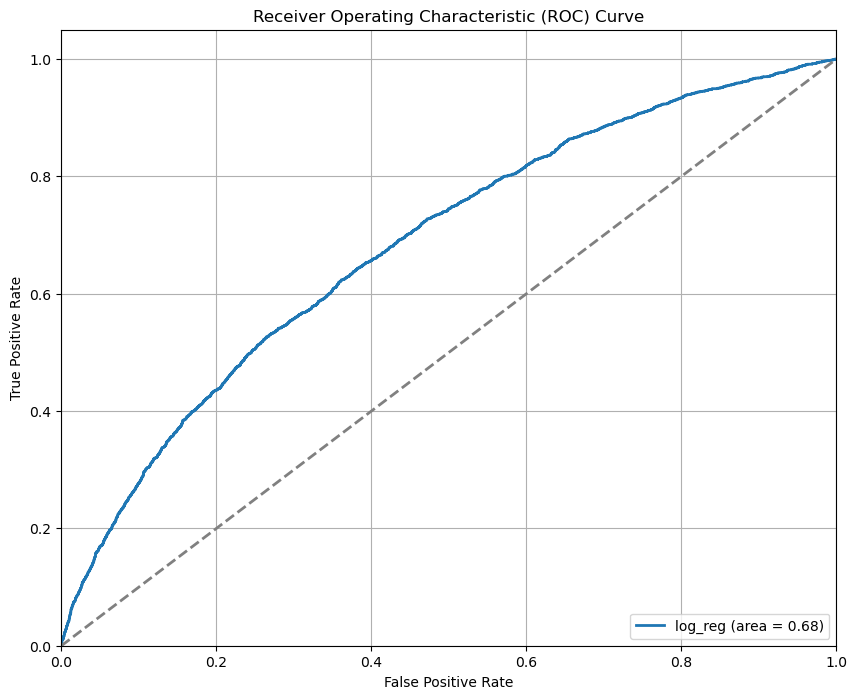

In [131]:
plot_roc_curves([(log_reg, "log_reg")], X_test, y_test)

In [132]:
# Initialize a Decision Tree Classifier with a max depth of 15 
decision_tree = DecisionTreeClassifier(max_depth=15, 
                                       random_state=42
                                    )

# Perform cross-validation on the training set
cv_scores = cross_val_score(decision_tree, X_train_resampled, y_train_resampled, cv=5)

# Print the average cross-validation score
print(f'Cross-validation scores: {cv_scores}')
print(f'Average CV score: {cv_scores.mean()}')

Cross-validation scores: [0.58807753 0.82622211 0.87565525 0.89155745 0.87656202]
Average CV score: 0.8116148740640714


In [133]:
# Fit the model
decision_tree.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(max_depth=15, random_state=42)

In [134]:
# Predict on the test set
y_pred = decision_tree.predict(X_test)
y_prob = decision_tree.predict_proba(X_test)

In [135]:
model_evaluation_report(X_test, y_test, y_pred, y_prob[:, 0])

Accuracy: 0.7585963259538389
Precision: 0.3253156945279615
Recall: 0.2169206094627105
F1-Score: 0.2602838585518403
ROC-AUC: 0.3672954685152997
Confusion Matrix:
[[9122 1122]
 [1953  541]]


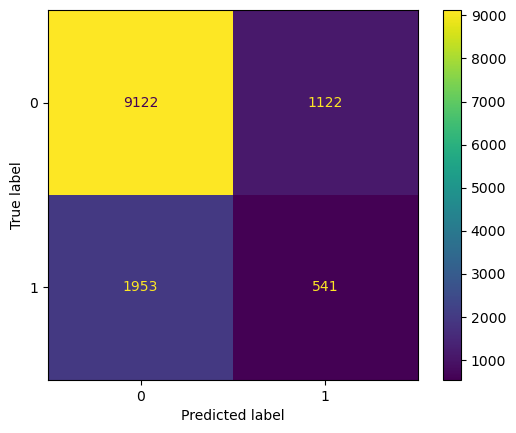

In [136]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), display_labels = [0, 1])
cm_display.plot()
plt.show()

In [137]:
# List to store AUC values
train_auc = []
test_auc = []

# Range of depths to evaluate
depth_range = np.arange(1, 11)

# Loop over each depth
for depth in depth_range:
    # Initialize Decision Tree with the current max depth
    decision_tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    
    # Fit the model on training data
    decision_tree.fit(X_train_resampled, y_train_resampled)
    
    # Predict probabilities for the ROC AUC calculation
    y_train_pred_prob = decision_tree.predict_proba(X_train_resampled)[:, 1]
    y_test_pred_prob = decision_tree.predict_proba(X_test)[:, 1]
    
    # Calculate ROC AUC for both training and test sets
    train_auc.append(roc_auc_score(y_train_resampled, y_train_pred_prob))
    test_auc.append(roc_auc_score(y_test, y_test_pred_prob))

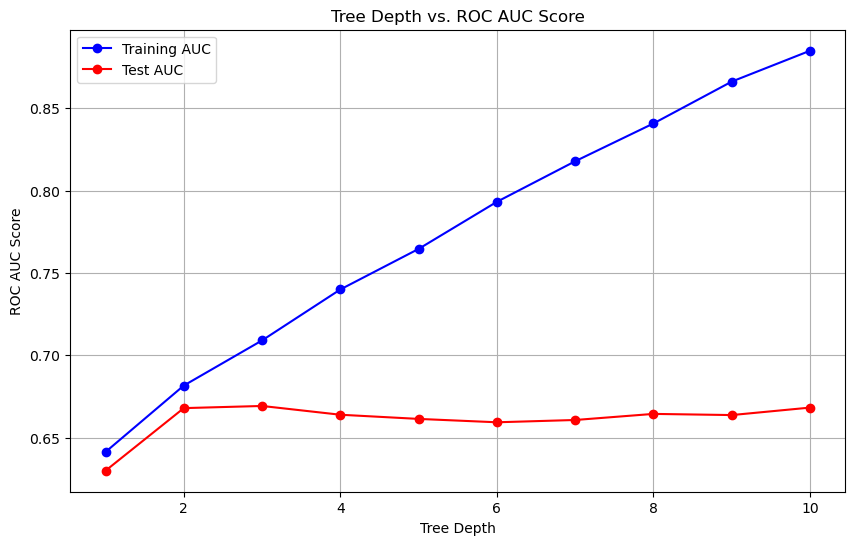

In [138]:
# Plotting the ROC AUC scores for training and validation sets
plt.figure(figsize=(10, 6))
plt.plot(depth_range, train_auc, label='Training AUC', marker='o', color='blue')
plt.plot(depth_range, test_auc, label='Test AUC', marker='o', color='red')

# Adding labels and title
plt.xlabel('Tree Depth')
plt.ylabel('ROC AUC Score')
plt.title('Tree Depth vs. ROC AUC Score')
plt.legend()
plt.grid(True)
plt.show()

From the above plot, it seems like our model is not generalising well. It's clearly overfitting.

Let's try an ensemble model and see if we get better results.

In [139]:
# Initialize the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [140]:
# Fit the model
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [141]:
# Make predictions
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

model_evaluation_report(X_test, y_test, y_pred, y_prob)

Accuracy: 0.783325482807348
Precision: 0.40059790732436473
Recall: 0.214915797914996
F1-Score: 0.2797494780793319
ROC-AUC: 0.6794804211090608
Confusion Matrix:
[[9442  802]
 [1958  536]]


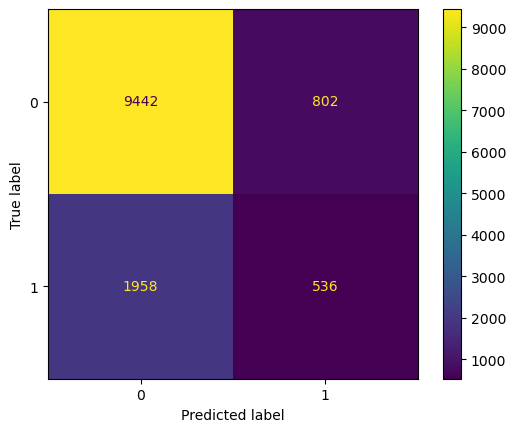

In [142]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), display_labels = [0, 1])
cm_display.plot()
plt.show()

### Feature Selection using RFE

In [143]:
# Initialize the Random Forest classifier
rf_2 = RandomForestClassifier(n_estimators=100, random_state=42)

In [144]:
# Apply Recursive Feature Elimination (RFE)
rfe = RFE(estimator=rf_2,
          n_features_to_select=10, # n_features_to_select = number of features to select
          step=5,                  # step=1 means remove one feature at a time
          verbose = 3)

# Fit RFE to the training data
rfe.fit(X_train_resampled, y_train_resampled)

Fitting estimator with 37 features.
Fitting estimator with 32 features.
Fitting estimator with 27 features.
Fitting estimator with 22 features.
Fitting estimator with 17 features.
Fitting estimator with 12 features.


RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10,
    step=5, verbose=3)

In [145]:
# Select the top features
selected_features = X_train_resampled.columns[rfe.support_]
print(selected_features)

Index(['dti', 'sub_grade_encoded', 'int_rate', 'loan_amnt_log',
       'annual_inc_log', 'revol_bal_log', 'revol_util_log', 'open_acc_sqrt',
       'income_to_loan_ratio', 'revol_bal_to_total_acc'],
      dtype='object')


In [146]:
# Train the Random Forest classifier on the selected features
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected.fit(X_train_resampled[selected_features], y_train_resampled)

RandomForestClassifier(random_state=42)

In [147]:
# Evaluate the model performance on the test set
y_pred_selected = rf_selected.predict(X_test[selected_features])
y_prob_selected = rf_selected.predict_proba(X_test[selected_features])[:,1]

In [148]:
model_evaluation_report(X_test[selected_features], y_test, y_pred_selected, y_prob_selected)

Accuracy: 0.7819908933898572
Precision: 0.39288417865253594
Recall: 0.20809943865276664
F1-Score: 0.27208387942332896
ROC-AUC: 0.6681218642038824
Confusion Matrix:
[[9442  802]
 [1975  519]]


In [149]:
importances = rf_selected.feature_importances_

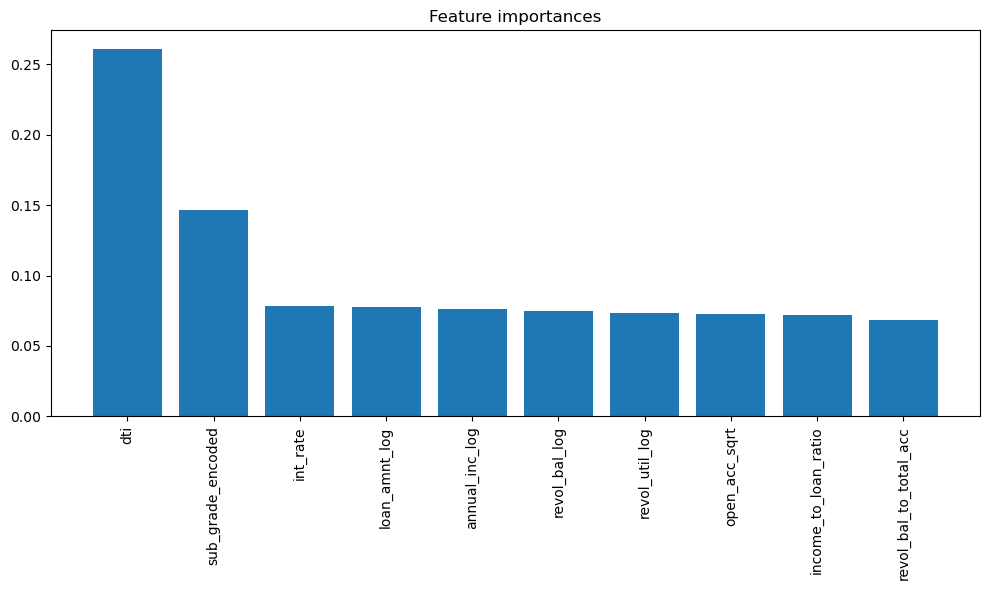

In [150]:
# Sort the array in descending order
indices = np.argsort(importances)[::-1]
# argsort > returns the indices of the importances array in ascending order.
# [::-1]  > reverses the array, making the sorting descending.
# It uses Python's slice notation, where the syntax is [start:stop:step]

col_labels = X_train_resampled[selected_features].columns

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train_resampled[selected_features].shape[1]), importances[indices], align="center")
plt.xticks(ticks = range(X_train_resampled[selected_features].shape[1])
           , labels = col_labels, rotation=90)
plt.tight_layout()
plt.show()

Let's try tuning some of the hyperparameters

In [270]:
# Define hyperparameters grid
param_grid = {
    'n_estimators': [50, 200],    # [50, 100, 200],
    'max_depth': [3, 10],      # [None, 10, 20, 30],
    'min_samples_split': [2]  # [2, 5, 10]
}

# Initialize Grid Search
grid_search = GridSearchCV(estimator=rf_selected,
                           param_grid=param_grid,
                           cv=2,
                           n_jobs=-1,
                           verbose=3)


In [271]:
# Fit Grid Search
grid_search.fit(X_train_resampled[selected_features], y_train_resampled)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 10], 'min_samples_split': [2],
                         'n_estimators': [50, 200]},
             verbose=3)

In [272]:
# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}


In [273]:
best_rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42
)

# Step 2: Fit the model on the training data
best_rf.fit(X_train_resampled[selected_features], y_train_resampled)

# Step 3: Predict on the test set
y_pred = best_rf.predict(X_test[selected_features])
y_prob = best_rf.predict_proba(X_test[selected_features])[:,1]

model_evaluation_report(X_test[selected_features], y_test, y_pred, y_prob)

Accuracy: 0.6850368974721306
Precision: 0.3154182879377432
Recall: 0.5200481154771451
F1-Score: 0.3926733272782319
ROC-AUC: 0.681403368866224
Confusion Matrix:
[[7429 2815]
 [1197 1297]]
[CV 2/2] END max_depth=3, min_samples_split=2, n_estimators=50;, score=0.657 total time=   1.2s
[CV 1/2] END max_depth=3, min_samples_split=2, n_estimators=50;, score=0.647 total time=   1.4s
[CV 2/2] END max_depth=10, min_samples_split=2, n_estimators=50;, score=0.793 total time=   3.0s
[CV 1/2] END max_depth=10, min_samples_split=2, n_estimators=50;, score=0.731 total time=   3.3s
[CV 2/2] END max_depth=3, min_samples_split=2, n_estimators=200;, score=0.655 total time=   4.1s
[CV 1/2] END max_depth=3, min_samples_split=2, n_estimators=200;, score=0.647 total time=   4.6s
[CV 1/2] END max_depth=10, min_samples_split=2, n_estimators=200;, score=0.721 total time=  11.6s
[CV 2/2] END max_depth=10, min_samples_split=2, n_estimators=200;, score=0.787 total time=  10.1s


### Visualising SHAP Values

In [151]:
# SHAP TreeExplainer for RandomForestClassifier
rf_explainer = shap.TreeExplainer(rf_selected)
rf_shap_values = rf_explainer.shap_values(X_test)

# Check SHAP values' shape to confirm
print(f'RF SHAP values shape: {rf_shap_values[1].shape}')

RF SHAP values shape: (37, 2)


In [152]:
# Initialize JS visualization for interactive plots
shap.initjs()

In [153]:
observation_index = 7
# Step 1 - calculate expected value of positive class
# This is baseline or average prediction of the model for the positive class before any specific features for an observation are considered
expected_value_positive_class = rf_explainer.expected_value[1]
print("expected_value_positive_class:", expected_value_positive_class)

# Step 2 - SHAP plot for a specific observation (e.g., the first row in the test set)
shap.force_plot(expected_value_positive_class
                ,  rf_shap_values[observation_index][:, 1] # shap_values_positive_class
                , X_test.iloc[observation_index])

expected_value_positive_class: 0.5001928609743013


In [154]:
# Create a function to update SHAP visualizations based on selected observation
def update_shap_plot(observation_index):
    # Clear the previous output to avoid stacking multiple force plots
    clear_output(wait=True)
    
    # Re-display the slider (since clearing the output also clears the slider)
    display(observation_slider)
    
    feature_names = col_labels
    
    # Display SHAP force plot for the selected observation
    display(shap.force_plot(
            expected_value_positive_class
                , rf_shap_values[observation_index][:, 1] 
                , X_test.iloc[observation_index]
                , feature_names = feature_names
           ))

In [155]:
# Create a slider to select the observation (0 to len(X_test)-1)
observation_slider = widgets.IntSlider(
    value=0, min=0, max=len(X_test)-1, step=1, description='Observation:', continuous_update=True)

# Use the interactive function to update the SHAP plot when the slider value changes
observation_slider.observe(lambda change: update_shap_plot(change['new']), names='value')

# Display the slider and force plot
display(observation_slider)

# Call update_shap_plot to display the initial SHAP plot
update_shap_plot(0)

IntSlider(value=0, description='Observation:', max=12737)

Let's try CatBoost Classifier

In [156]:
# Initialize the CatBoostClassifier with an overfitting detector
cb = CatBoostClassifier(
    iterations=500,      # Maximum number of boosting iterations
    learning_rate=0.05,  # Learning rate
    eval_metric='AUC',   # Metric to monitor
    early_stopping_rounds=20,  # Stop if no improvement after X iterations
    od_type='Iter',            # Overfitting detection type (detect after fixed number of non-improving iterations)
    random_seed=42,
    verbose=100                # Print log every X iterations
)

# Train the model with training and validation data
cb.fit(
    X_train_resampled, y_train_resampled,
    eval_set=(X_test, y_test),  # Validation set for monitoring overfitting
    use_best_model=True,        # Use the best model from the iterations
    plot=True                   # Plot the learning curve
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6300619	best: 0.6300619 (0)	total: 66.8ms	remaining: 33.3s
100:	test: 0.6911267	best: 0.6911267 (100)	total: 697ms	remaining: 2.75s
200:	test: 0.6955184	best: 0.6955184 (200)	total: 1.37s	remaining: 2.03s
300:	test: 0.6980254	best: 0.6980254 (300)	total: 1.97s	remaining: 1.3s
400:	test: 0.6999645	best: 0.6999796 (396)	total: 2.59s	remaining: 639ms
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7000273127
bestIteration = 408

Shrink model to first 409 iterations.


In [157]:
# Make predictions
cb_y_pred = cb.predict(X_test)
cb_y_prob = cb.predict_proba(X_test)[:, 1]

model_evaluation_report(X_test, y_test, cb_y_pred, cb_y_prob)

Accuracy: 0.8051499450463181
Precision: 0.5120967741935484
Recall: 0.10184442662389735
F1-Score: 0.16989966555183947
ROC-AUC: 0.7000273127196017
Confusion Matrix:
[[10002   242]
 [ 2240   254]]


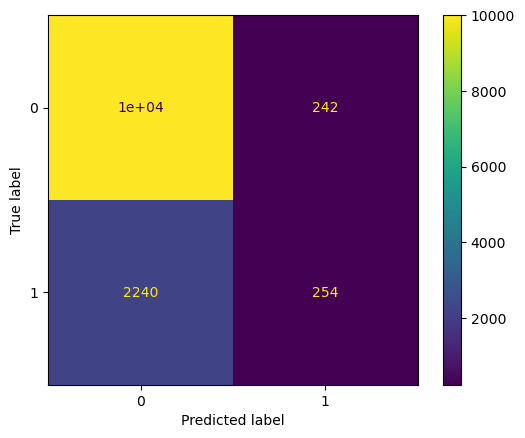

In [158]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, cb_y_pred), display_labels = [0, 1])
cm_display.plot()
plt.show()

In [159]:
# Initialize the CatBoostClassifier with an overfitting detector
cb2 = CatBoostClassifier(
    iterations=500,      # Maximum number of boosting iterations
    learning_rate=0.05,  # Learning rate
    eval_metric='AUC',   # Metric to monitor
    early_stopping_rounds=20,  # Stop if no improvement after X iterations
    od_type='Iter',            # Overfitting detection type (detect after fixed number of non-improving iterations)
    random_seed=42,
    verbose=100                # Print log every X iterations
)

# Train the model with training and validation data
cb2.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),  # Validation set for monitoring overfitting
    use_best_model=True,        # Use the best model from the iterations
    plot=True                   # Plot the learning curve
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6682906	best: 0.6682906 (0)	total: 5.31ms	remaining: 2.65s
100:	test: 0.7031478	best: 0.7032293 (98)	total: 481ms	remaining: 1.9s
200:	test: 0.7057137	best: 0.7057137 (200)	total: 964ms	remaining: 1.43s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7061462935
bestIteration = 228

Shrink model to first 229 iterations.


In [160]:
# Make predictions
cb2_y_pred = cb2.predict(X_test)
cb2_y_prob = cb2.predict_proba(X_test)[:, 1]

model_evaluation_report(X_test, y_test, cb2_y_pred, cb2_y_prob)

Accuracy: 0.8066415449835139
Precision: 0.5771144278606966
Recall: 0.046511627906976744
F1-Score: 0.08608534322820037
ROC-AUC: 0.7061462934705925
Confusion Matrix:
[[10159    85]
 [ 2378   116]]


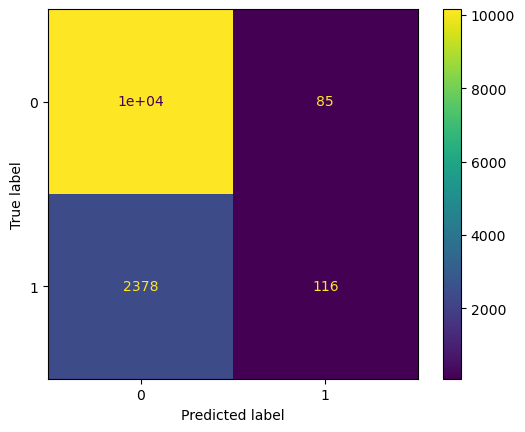

In [161]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, cb2_y_pred), display_labels = [0, 1])
cm_display.plot()
plt.show()

In [278]:
# Save the model as a pickle in a file
joblib.dump(cb2, 'catboost_clf.pkl')

['catboost_clf.pkl']

In [279]:
# Load the model from the file
catboost_clf = joblib.load('catboost_clf.pkl')

In [277]:
loaded_pred = catboost_clf.predict(X_test)
loaded_prob = catboost_clf.predict_proba(X_test)[:, 1]

model_evaluation_report(X_test, y_test, loaded_pred, loaded_prob)

Accuracy: 0.8066415449835139
Precision: 0.5771144278606966
Recall: 0.046511627906976744
F1-Score: 0.08608534322820037
ROC-AUC: 0.7061462934705925
Confusion Matrix:
[[10159    85]
 [ 2378   116]]


As we can see the loaded model produces the same results as `cb2` above. Therefore, the model has been saved and loaded successfully!

In [162]:
# Initializing the CatBoostClassifier with common base parameters
# cb3 = CatBoostClassifier(
#     iterations=1000,           # Set a high number of iterations for fine-tuning
#     learning_rate=0.01,        # Start with a low learning rate for better generalization
#     eval_metric='AUC',         # Metric to optimize
#     early_stopping_rounds=50,  # Stop early if no improvement
#     random_seed=42,            # Ensure reproducibility
#     verbose=100                # Print progress every 100 iterations
# )

# # Setting up the hyperparameter grid for tuning
# param_grid = {
#     'depth': [4, 6, 8],                # Tree depth for tuning
#     'l2_leaf_reg': [3, 5, 7, 9],       # L2 regularization
#     'bagging_temperature': [0, 0.5, 1], # Bagging temperature for regularization
#     'rsm': [0.8, 0.9, 1.0],            # Random subspace method (feature sampling)
#     'border_count': [128, 254],        # Number of splits for numeric features
# }

# # Initialize GridSearchCV to find the best parameters
# grid_search = GridSearchCV(
#     estimator=cb3,
#     param_grid=param_grid,
#     scoring='roc_auc',          # Metric for scoring in GridSearchCV
#     cv=3,                       # Use 3-fold cross-validation
#     verbose=3                   # Verbosity for output during search
# )

# # Fitting the model with training data
# grid_search.fit(X_train_resampled, y_train_resampled, eval_set=(X_test, y_test), use_best_model=True)

# # Display the best parameters found by GridSearchCV
# print("Best parameters found: ", grid_search.best_params_)

# # Train the best model using these parameters
# best_cb = grid_search.best_estimator_

# # Evaluate the model performance on the test set
# best_cb_y_pred = best_cb.predict(X_test)
# best_cb_y_prob = best_cb.predict_proba(X_test)[:, 1]

In [163]:
# Make predictions

# model_evaluation_report(X_test, y_test, best_cb_y_pred, best_cb_y_prob)

In [164]:
# cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, best_cb_y_pred), display_labels = [0, 1])
# cm_display.plot()
# plt.show()

### Deep Learning with Tensorflow (Neural Networks)

In [165]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from scikeras.wrappers import KerasClassifier
from keras_tuner.tuners import RandomSearch
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight

2024-11-03 19:18:45.083913: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-03 19:18:45.124786: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730661525.148201  102493 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730661525.154462  102493 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-03 19:18:45.189437: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [166]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [204]:
X = df_standard_combined.drop(columns=columns_to_drop)
y = df_standard_combined["loan_status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [205]:
# Ensure y_train is a numpy array
y_train = np.array(y_train)

# Step 1: Calculate class weights
# Ensure y_train is a numpy array for compute_class_weight to work properly
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),  # Automatically detect class labels
    y=y_train
)

# Convert the class weights to a dictionary format
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [206]:
input_dim = (X_train_resampled.shape[1],)
input_dim_unbalanced = (X_train.shape[1],)

In [207]:
# Set the random seed
tf.random.set_seed(42)

# 1. Create the model using the Sequential API
nn = tf.keras.Sequential([
    Input(shape=(input_dim)),  # Ensure the shape is correctly passed
    Dense(16, activation=relu),
    Dense(8, activation=relu),
    Dense(1, activation=sigmoid)
])

# 2. Compile the model
nn.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy', Precision(), Recall(), AUC()]  # Use the metric functions
)

# 3. Fit the model
history = nn.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5298 - auc_10: 0.5401 - loss: 0.7092 - precision_10: 0.5250 - recall_10: 0.6732 - val_accuracy: 0.6539 - val_auc_10: 0.6782 - val_loss: 0.6264 - val_precision_10: 0.3034 - val_recall_10: 0.5922
Epoch 2/10
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6292 - auc_10: 0.6806 - loss: 0.6417 - precision_10: 0.6243 - recall_10: 0.6495 - val_accuracy: 0.6678 - val_auc_10: 0.6953 - val_loss: 0.6056 - val_precision_10: 0.3149 - val_recall_10: 0.5926
Epoch 3/10
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6447 - auc_10: 0.7005 - loss: 0.6288 - precision_10: 0.6411 - recall_10: 0.6579 - val_accuracy: 0.6729 - val_auc_10: 0.6969 - val_loss: 0.6003 - val_precision_10: 0.3183 - val_recall_10: 0.5878
Epoch 4/10
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6518 - auc_10: 0.7110 - loss: 0.6215 - precision_10: 0.6475 - recall_10: 0.6670 - val_accuracy: 0.6740 - val_auc_10: 0.6968 - val_loss: 0.5986 - v

In [208]:
# Make predictions and evaluate
nn_y_prob = nn.predict(X_test)
nn_y_pred = (nn_y_prob > 0.5)
model_evaluation_report(X_test, y_test, nn_y_pred, nn_y_prob)

399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
Accuracy: 0.7025435704192181
Precision: 0.3334190892719321
Recall: 0.5196471531676022
F1-Score: 0.40620592383638926
ROC-AUC: 0.69031838066964
Confusion Matrix:
[[7653 2591]
 [1198 1296]]


In [209]:
def plot_training_vs_overfitting(history):
    """Plot training and validation accuracy to detect overfitting (when gap between 2 is detected)"""
    import matplotlib.pyplot as plt

    # Plot accuracy
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

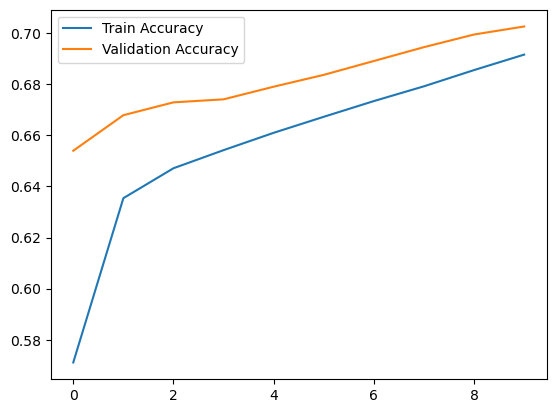

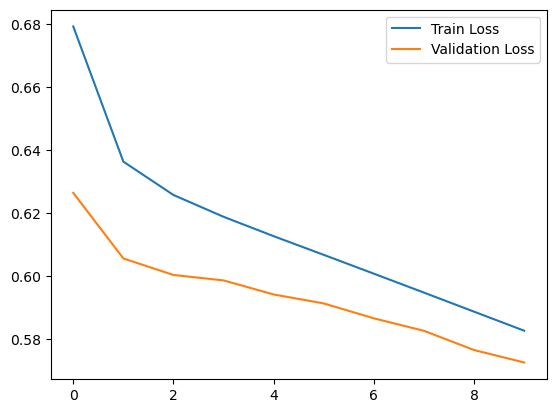

In [210]:
plot_training_vs_overfitting(history)

In [211]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Watch the val_accuracy
    patience=15,  # Stop if no improvement after 15 epochs
    restore_best_weights=True  # Restore the model weights at the best epoch
)

In [212]:
tf.random.set_seed(42)

# 1. Create the model using the Sequential API
nn2 = tf.keras.Sequential([
    Input(shape=(input_dim)),  # Ensure the shape is correctly passed
    Dense(16, activation=relu),
    Dropout(0.2),
    Dense(8, activation=relu),
    Dropout(0.2),
    Dense(1, activation=sigmoid)
])

# 2. Compile the model
nn2.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy', Precision(), Recall(), AUC()]  # Use the metric functions
)

# 3. Fit the model
history_2 = nn2.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4924 - auc_11: 0.4760 - loss: 2.1447 - precision_11: 0.4784 - recall_11: 0.2092 - val_accuracy: 0.7564 - val_auc_11: 0.4818 - val_loss: 0.6579 - val_precision_11: 0.2103 - val_recall_11: 0.0886
Epoch 2/50
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5107 - auc_11: 0.5138 - loss: 0.8912 - precision_11: 0.5108 - recall_11: 0.5146 - val_accuracy: 0.6715 - val_auc_11: 0.6466 - val_loss: 0.6657 - val_precision_11: 0.3006 - val_recall_11: 0.5112
Epoch 3/50
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5427 - auc_11: 0.5511 - loss: 0.7436 - precision_11: 0.5368 - recall_11: 0.6249 - val_accuracy: 0.6165 - val_auc_11: 0.6736 - val_loss: 0.6716 - val_precision_11: 0.2849 - val_recall_11: 0.6347
Epoch 4/50
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5628 - auc_11: 0.5907 - loss: 0.6965 - precision_11: 0.5493 - recall_11: 0.7024 - val_accuracy: 0.6126 - val_auc_11: 0.6809 - val_loss: 0.6665 - v

In [213]:
# Make predictions and evaluate
nn2_y_prob = nn2.predict(X_test)
nn2_y_pred = (nn2_y_prob > 0.5)
model_evaluation_report(X_test, y_test, nn2_y_pred, nn2_y_prob)

399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
Accuracy: 0.7563981786779714
Precision: 0.21027592768791628
Recall: 0.08861267040898156
F1-Score: 0.12468265162200282
ROC-AUC: 0.4817984678261016
Confusion Matrix:
[[9414  830]
 [2273  221]]


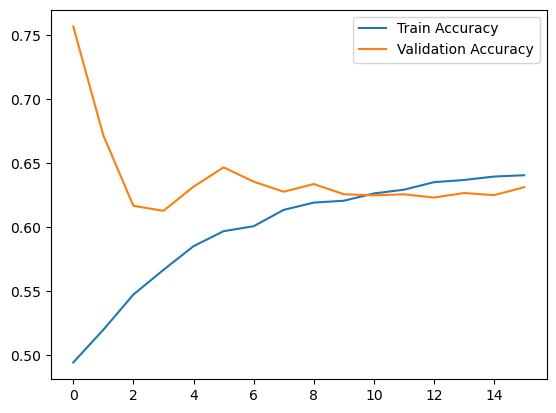

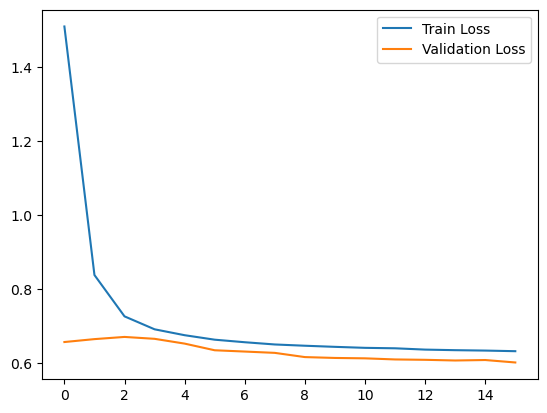

In [214]:
plot_training_vs_overfitting(history_2)

In [215]:
tf.random.set_seed(42)

# 1. Create the model using the Sequential API
nn3 = tf.keras.Sequential([
    Input(shape=(input_dim)),  # Ensure the shape is correctly passed
    Dense(100, activation=relu),
    Dropout(0.2),
    Dense(32, activation=relu),
    Dropout(0.2),
    Dense(16, activation=relu),
    Dropout(0.2),
    Dense(1, activation=sigmoid)
])

# 2. Compile the model
nn3.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy', Precision(), Recall(), AUC()]  # Use the metric functions
)

# Create a learning rate calllback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

# 3. Fit the model
history_3 = nn3.fit(X_train_resampled, y_train_resampled, epochs=30, batch_size=64, validation_data=(X_test, y_test), callbacks=[lr_scheduler])

Epoch 1/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5016 - auc_12: 0.5029 - loss: 0.9497 - precision_12: 0.5018 - recall_12: 0.5274 - val_accuracy: 0.2021 - val_auc_12: 0.6635 - val_loss: 0.7110 - val_precision_12: 0.1967 - val_recall_12: 0.9972 - learning_rate: 1.0000e-04
Epoch 2/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5230 - auc_12: 0.5410 - loss: 0.6982 - precision_12: 0.5198 - recall_12: 0.6089 - val_accuracy: 0.2713 - val_auc_12: 0.6745 - val_loss: 0.7079 - val_precision_12: 0.2081 - val_recall_12: 0.9703 - learning_rate: 1.1220e-04
Epoch 3/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5563 - auc_12: 0.5873 - loss: 0.6832 - precision_12: 0.5511 - recall_12: 0.6103 - val_accuracy: 0.5483 - val_auc_12: 0.6925 - val_loss: 0.6523 - val_precision_12: 0.2716 - val_recall_12: 0.7771 - learning_rate: 1.2589e-04
Epoch 4/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6047 - auc_12: 0.6464 - loss: 0.6593 - precision_12: 0.5938 - 

In [216]:
# Make predictions and evaluate
nn3_y_prob = nn3.predict(X_test)
nn3_y_pred = (nn3_y_prob > 0.5)
model_evaluation_report(X_test, y_test, nn3_y_pred, nn3_y_prob)

399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.7658188098602606
Precision: 0.3825084094185488
Recall: 0.3191659983961508
F1-Score: 0.34797814207650274
ROC-AUC: 0.6826562586599874
Confusion Matrix:
[[8959 1285]
 [1698  796]]


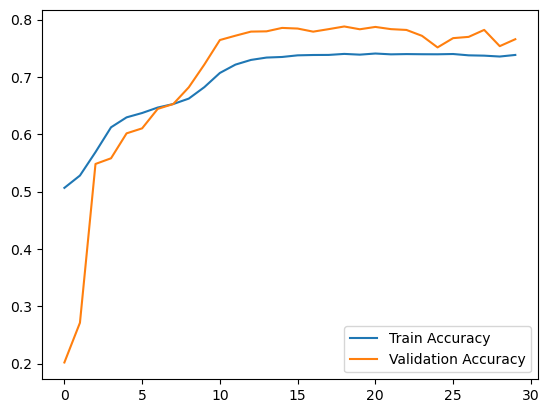

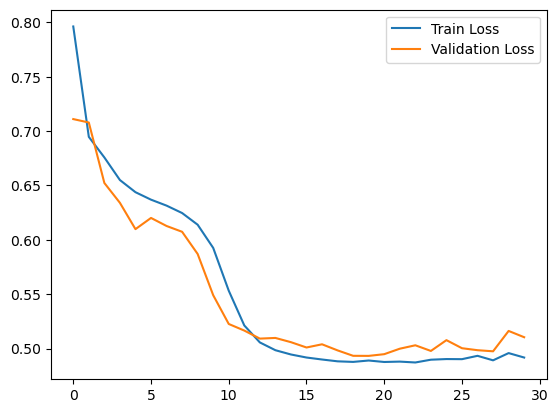

In [217]:
plot_training_vs_overfitting(history_3)

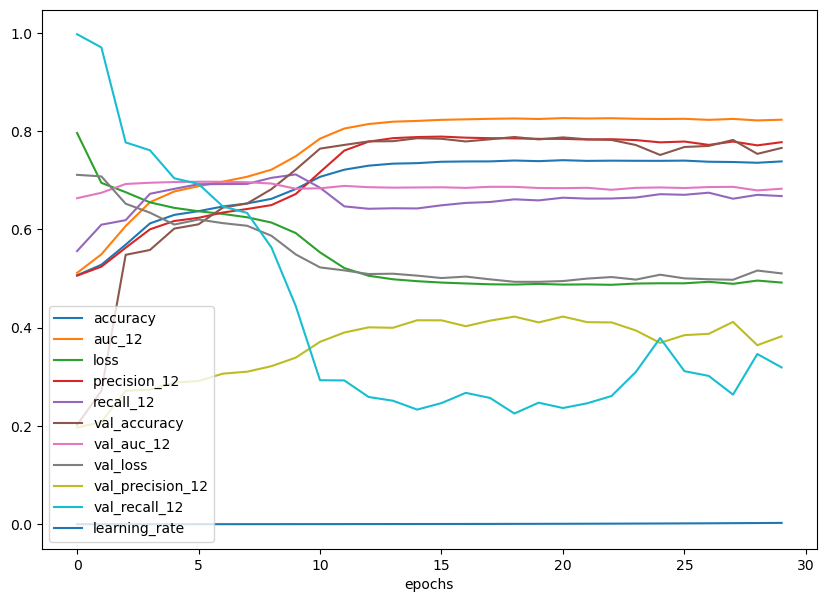

In [218]:
# Checkout the history
pd.DataFrame(history_3.history).plot(figsize=(10,7), xlabel="epochs");

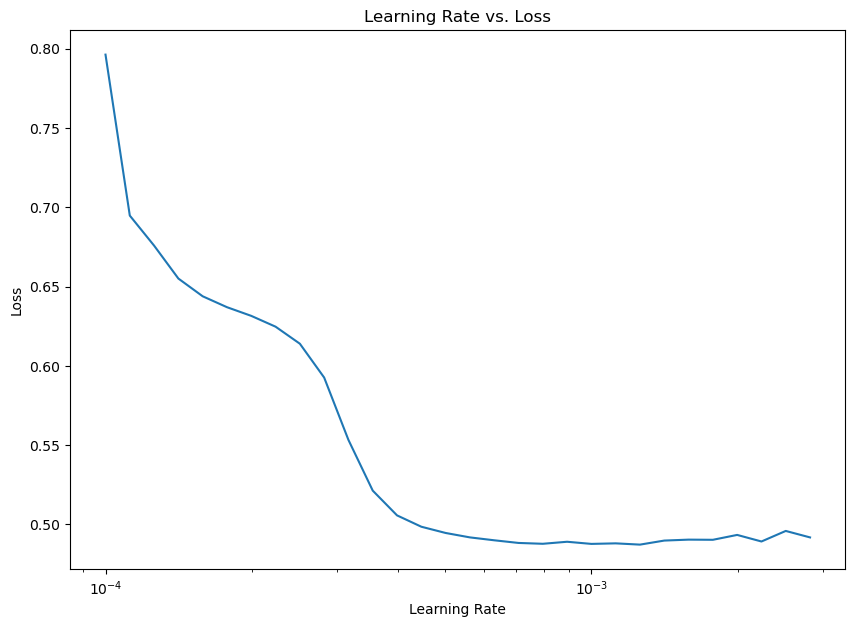

In [219]:
epochs = len(history_3.history["loss"])

# Generate learning rates for the number of epochs
lrs = 1e-4 * (10 ** (tf.range(epochs)/20))

# Plot the learning rate vs. loss
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history_3.history["loss"])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate vs. Loss")
plt.show()

In [220]:
# Define focal loss function
# def focal_loss(gamma=2., alpha=0.25):
#     def focal_loss_fixed(y_true, y_pred):
#         y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
#         cross_entropy = -y_true * K.log(y_pred)
#         loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
#         return K.mean(loss, axis=-1)
#     return focal_loss_fixed

In [221]:
tf.random.set_seed(42)

# 1. Create the model using the Sequential API
nn4 = tf.keras.Sequential([
    Input(shape=(input_dim)),  # Ensure the shape is correctly passed
    Dense(128, activation=relu), # additional layer added
    Dropout(0.2),
    Dense(16, activation=relu),
    Dropout(0.2),
    Dense(8, activation=relu),
    Dense(1, activation=sigmoid)
])

# 2. Compile the model
nn4.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # adjusted to best learning rate from plot above
    metrics=['accuracy', Precision(), Recall(), AUC()]  # Use the metric functions
)

# 3. Fit the model

history_4 = nn4.fit(X_train_resampled, y_train_resampled, epochs=30, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping]) # removed lr_scheduler and put back early_stopping callback

Epoch 1/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5650 - auc_13: 0.5983 - loss: 0.6870 - precision_13: 0.5642 - recall_13: 0.5614 - val_accuracy: 0.6763 - val_auc_13: 0.6946 - val_loss: 0.5863 - val_precision_13: 0.3174 - val_recall_13: 0.5678
Epoch 2/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6538 - auc_13: 0.7165 - loss: 0.6168 - precision_13: 0.6423 - recall_13: 0.6953 - val_accuracy: 0.6573 - val_auc_13: 0.6832 - val_loss: 0.6017 - val_precision_13: 0.3034 - val_recall_13: 0.5790
Epoch 3/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7075 - auc_13: 0.7880 - loss: 0.5468 - precision_13: 0.7247 - recall_13: 0.6710 - val_accuracy: 0.7626 - val_auc_13: 0.6818 - val_loss: 0.5214 - val_precision_13: 0.3716 - val_recall_13: 0.3075
Epoch 4/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7319 - auc_13: 0.8163 - loss: 0.5019 - precision_13: 0.7712 - recall_13: 0.6597 - val_accuracy: 0.7801 - val_auc_13: 0.6832 - val_loss: 0.5020 - v

In [222]:
# Make predictions and evaluate
nn4_y_prob = nn4.predict(X_test)
nn4_y_pred = (nn4_y_prob > 0.5)
model_evaluation_report(X_test, y_test, nn4_y_pred, nn4_y_prob)

399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.7801067671533993
Precision: 0.3998695368558382
Recall: 0.2457898957497995
F1-Score: 0.30444499627514277
ROC-AUC: 0.683353930730121
Confusion Matrix:
[[9324  920]
 [1881  613]]


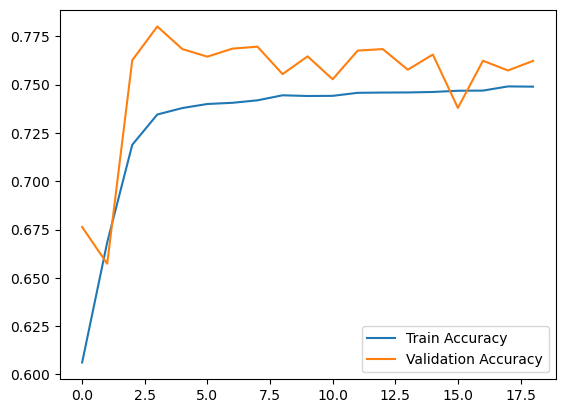

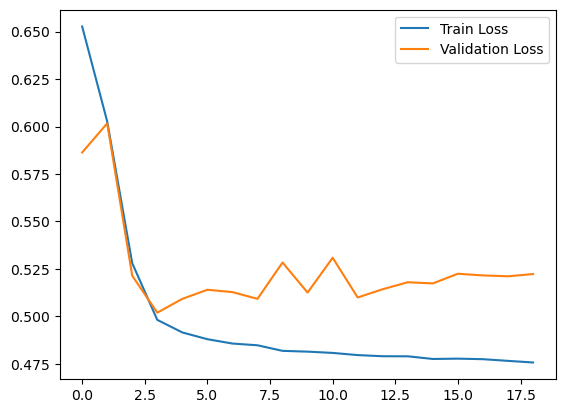

In [223]:
plot_training_vs_overfitting(history_4)

In [224]:
tf.random.set_seed(42)

# 1. Create the model using the Sequential API
nn5 = tf.keras.Sequential([
    Input(shape=(input_dim)),  # Ensure the shape is correctly passed
    Dense(128, activation=relu), # increased to 128 neurons and removed dropout layer below
    Dense(64, activation=relu), # additional layer
    Dense(32, activation=relu), # additional layer
    Dense(16, activation=relu),
    Dense(8, activation=relu),
    Dense(1, activation=sigmoid)
])

# 2. Compile the model
nn5.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # adjusted to best learning rate from plot above
    metrics=['accuracy', Precision(), Recall(), AUC()]  # Use the metric functions
)

# 3. Fit the model
history_5 = nn5.fit(X_train_resampled, y_train_resampled, epochs=30, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping]) # removed lr_scheduler and put back early_stopping callback

Epoch 1/30
1270/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6391 - auc_14: 0.6960 - loss: 0.6291 - precision_14: 0.6269 - recall_14: 0.6890

2024-11-03 21:27:11.177811: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_282', 12 bytes spill stores, 12 bytes spill loads



1282/1282 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6394 - auc_14: 0.6964 - loss: 0.6289 - precision_14: 0.6270 - recall_14: 0.6890 - val_accuracy: 0.5362 - val_auc_14: 0.6744 - val_loss: 0.8048 - val_precision_14: 0.2630 - val_recall_14: 0.7598
Epoch 2/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7233 - auc_14: 0.8072 - loss: 0.5156 - precision_14: 0.7483 - recall_14: 0.6736 - val_accuracy: 0.7732 - val_auc_14: 0.6868 - val_loss: 0.5014 - val_precision_14: 0.3959 - val_recall_14: 0.3011
Epoch 3/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7347 - auc_14: 0.8211 - loss: 0.4929 - precision_14: 0.7710 - recall_14: 0.6682 - val_accuracy: 0.7708 - val_auc_14: 0.6865 - val_loss: 0.5014 - val_precision_14: 0.3864 - val_recall_14: 0.2899
Epoch 4/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7376 - auc_14: 0.8236 - loss: 0.4893 - precision_14: 0.7816 - recall_14: 0.6600 - val_accuracy: 0.7520 - val_auc_14: 0.6864 - val_loss: 0.5244 - val_precisio

In [225]:
# Make predictions and evaluate
nn5_y_prob = nn5.predict(X_test)
nn5_y_pred = (nn5_y_prob > 0.5)
model_evaluation_report(X_test, y_test, nn5_y_pred, nn5_y_prob)

399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.5361909247919611
Precision: 0.2630483064963909
Recall: 0.7598235765838012
F1-Score: 0.3908022272633533
ROC-AUC: 0.6744405628565175
Confusion Matrix:
[[4935 5309]
 [ 599 1895]]


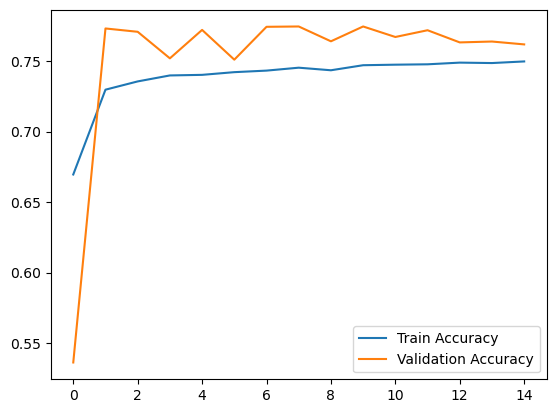

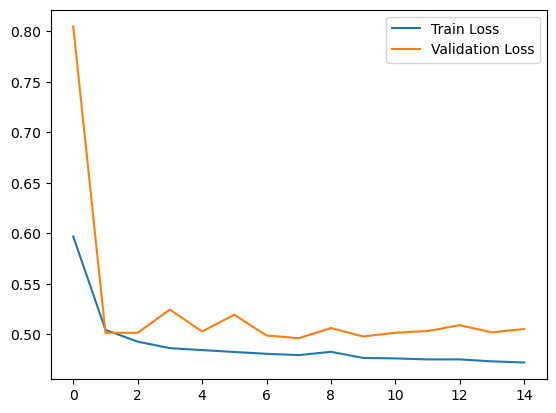

In [226]:
plot_training_vs_overfitting(history_5)

In [227]:
tf.random.set_seed(42)

# 1. Create the model using the Sequential API
nn6 = tf.keras.Sequential([
    Input(shape=(input_dim)),  # Ensure the shape is correctly passed
    Dense(100, activation=relu, kernel_regularizer=l2(0.01)), # added l2 regularizer to prevent overfitting
    Dense(64, activation=relu), # additional layer
    Dense(32, activation=relu), # additional layer
    Dense(16, activation=relu),
    Dense(8, activation=relu),
    Dense(1, activation=sigmoid)
])

# 2. Compile the model
nn6.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # adjusted to best learning rate from plot above
    metrics=['accuracy', Precision(), Recall(), AUC()]  # Use the metric functions
)

# 3. Fit the model
history_6 = nn6.fit(X_train_resampled, y_train_resampled, epochs=30, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6042 - auc_15: 0.6592 - loss: 0.7822 - precision_15: 0.5854 - recall_15: 0.7696 - val_accuracy: 0.4853 - val_auc_15: 0.6864 - val_loss: 0.8538 - val_precision_15: 0.2518 - val_recall_15: 0.8260
Epoch 2/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6879 - auc_15: 0.7563 - loss: 0.6033 - precision_15: 0.6905 - recall_15: 0.6822 - val_accuracy: 0.5608 - val_auc_15: 0.6798 - val_loss: 0.7808 - val_precision_15: 0.2708 - val_recall_15: 0.7346
Epoch 3/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7098 - auc_15: 0.7892 - loss: 0.5644 - precision_15: 0.7259 - recall_15: 0.6748 - val_accuracy: 0.5644 - val_auc_15: 0.6820 - val_loss: 0.7788 - val_precision_15: 0.2708 - val_recall_15: 0.7237
Epoch 4/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7165 - auc_15: 0.8013 - loss: 0.5424 - precision_15: 0.7424 - recall_15: 0.6638 - val_accuracy: 0.6393 - val_auc_15: 0.6849 - val_loss: 0.6636 - v

In [228]:
# Make predictions and evaluate
nn6_y_prob = nn6.predict(X_test)
nn6_y_pred = (nn6_y_prob > 0.5)
model_evaluation_report(X_test, y_test, nn6_y_pred, nn6_y_prob)

399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.4853195164075993
Precision: 0.25177218284038133
Recall: 0.8259823576583801
F1-Score: 0.3859123267141251
ROC-AUC: 0.6863326728388665
Confusion Matrix:
[[4122 6122]
 [ 434 2060]]


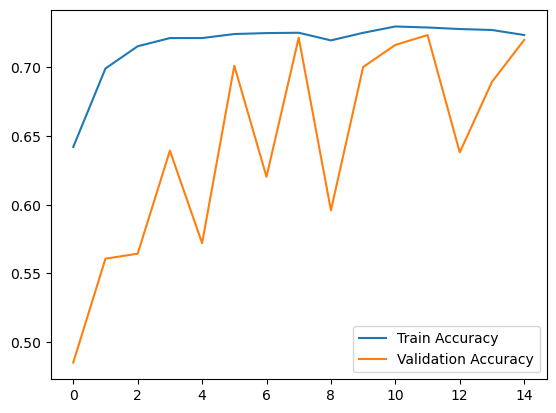

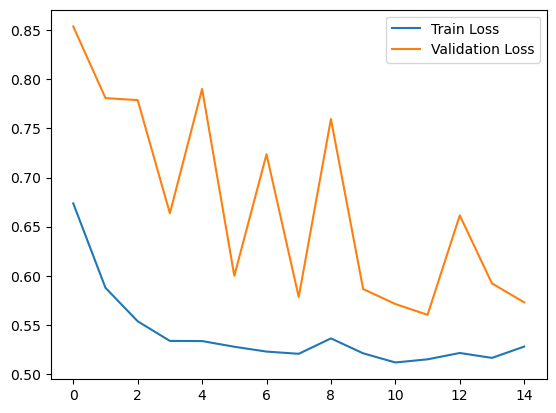

In [229]:
plot_training_vs_overfitting(history_6)

In [230]:
tf.random.set_seed(42)

# 1. Create the model using the Sequential API
nn7 = tf.keras.Sequential([
    Input(shape=(input_dim)),
    Dense(100, activation=relu),
    Dense(100, activation=relu),
    Dense(100, activation=relu),
    Dense(64, activation=relu),
    Dense(32, activation=relu),
    Dense(16, activation=relu),
    Dense(8, activation=relu),
    Dense(1, activation=sigmoid)
])

# 2. Compile the model
nn7.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), # now using SGD optimizer
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

# 3. Fit the model
history_7 = nn7.fit(X_train_resampled, y_train_resampled, epochs=30, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/30


2024-11-03 21:28:51.231265: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_92', 44 bytes spill stores, 44 bytes spill loads

2024-11-03 21:28:51.295681: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_483', 80 bytes spill stores, 80 bytes spill loads



1263/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5802 - auc_16: 0.6222 - loss: 0.6762 - precision_16: 0.5635 - recall_16: 0.7509

2024-11-03 21:28:55.551736: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_92', 68 bytes spill stores, 68 bytes spill loads

2024-11-03 21:28:55.932943: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_483', 64 bytes spill stores, 64 bytes spill loads

2024-11-03 21:28:56.042180: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_483', 80 bytes spill stores, 80 bytes spill loads



1282/1282 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5806 - auc_16: 0.6225 - loss: 0.6760 - precision_16: 0.5639 - recall_16: 0.7501 - val_accuracy: 0.2555 - val_auc_16: 0.6795 - val_loss: 0.9540 - val_precision_16: 0.2059 - val_recall_16: 0.9808
Epoch 2/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6300 - auc_16: 0.6802 - loss: 0.6431 - precision_16: 0.6225 - recall_16: 0.6622 - val_accuracy: 0.3749 - val_auc_16: 0.6820 - val_loss: 0.8441 - val_precision_16: 0.2289 - val_recall_16: 0.9254
Epoch 3/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6383 - auc_16: 0.6927 - loss: 0.6339 - precision_16: 0.6293 - recall_16: 0.6748 - val_accuracy: 0.3792 - val_auc_16: 0.6858 - val_loss: 0.8570 - val_precision_16: 0.2299 - val_recall_16: 0.9238
Epoch 4/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6431 - auc_16: 0.6998 - loss: 0.6288 - precision_16: 0.6299 - recall_16: 0.6955 - val_accuracy: 0.3989 - val_auc_16: 0.6895 - val_loss: 0.8451 - val_precisi

In [231]:
# Make predictions and evaluate
nn7_y_prob = nn7.predict(X_test)
nn7_y_pred = (nn7_y_prob > 0.5)
model_evaluation_report(X_test, y_test, nn7_y_pred, nn7_y_prob)

399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.2554561155597425
Precision: 0.20585759973068507
Recall: 0.9807538091419407
F1-Score: 0.3402893711741792
ROC-AUC: 0.679589644588637
Confusion Matrix:
[[ 808 9436]
 [  48 2446]]


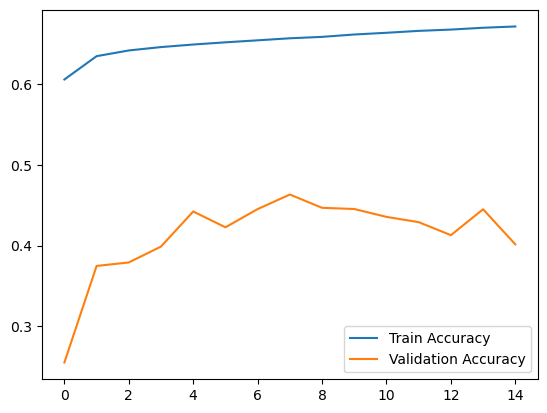

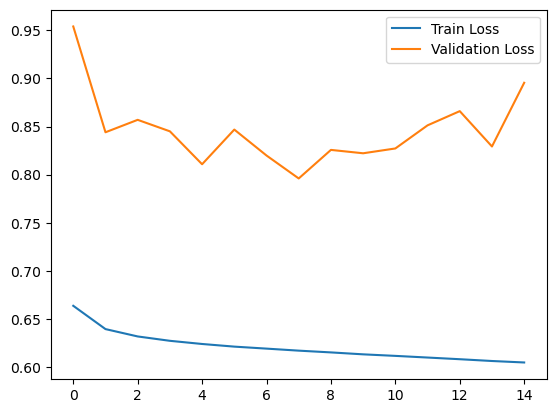

In [232]:
plot_training_vs_overfitting(history_7)

In [233]:
tf.random.set_seed(42)

# 1. Create the model using the Sequential API
nn8 = tf.keras.Sequential([
    Input(shape=(input_dim)),
    Dense(100, activation="swish", kernel_regularizer=l2(0.01)),
    Dense(100, activation="swish"),
    Dense(100, activation="swish"),
    Dense(100, activation="swish"),
    Dense(8, activation="swish"),
    Dense(1, activation=sigmoid)
])

# 2. Compile the model
nn8.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

# 3. Fit the model
history_8 = nn8.fit(X_train_resampled, y_train_resampled, epochs=30, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5012 - auc_17: 0.5031 - loss: 0.7186 - precision_17: 0.5021 - recall_17: 0.4026 - val_accuracy: 0.8042 - val_auc_17: 0.5000 - val_loss: 0.7493 - val_precision_17: 0.0000e+00 - val_recall_17: 0.0000e+00
Epoch 2/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4982 - auc_17: 0.4967 - loss: 0.7139 - precision_17: 0.4768 - recall_17: 0.4195 - val_accuracy: 0.8042 - val_auc_17: 0.5000 - val_loss: 0.6786 - val_precision_17: 0.0000e+00 - val_recall_17: 0.0000e+00
Epoch 3/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4961 - auc_17: 0.4965 - loss: 0.6935 - precision_17: 0.4821 - recall_17: 0.4174 - val_accuracy: 0.8042 - val_auc_17: 0.5000 - val_loss: 0.6783 - val_precision_17: 0.0000e+00 - val_recall_17: 0.0000e+00
Epoch 4/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4961 - auc_17: 0.4964 - loss: 0.6933 - precision_17: 0.4824 - recall_17: 0.4231 - val_accuracy: 0.8042 - val_auc_17: 0.500

In [234]:
# Make predictions and evaluate
nn8_y_prob = nn8.predict(X_test)
nn8_y_pred = (nn8_y_prob > 0.5)
model_evaluation_report(X_test, y_test, nn8_y_pred, nn8_y_prob)

399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.8042078819280892
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
ROC-AUC: 0.5
Confusion Matrix:
[[10244     0]
 [ 2494     0]]


/home/cheydb/anaconda3/envs/dsif-acc/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


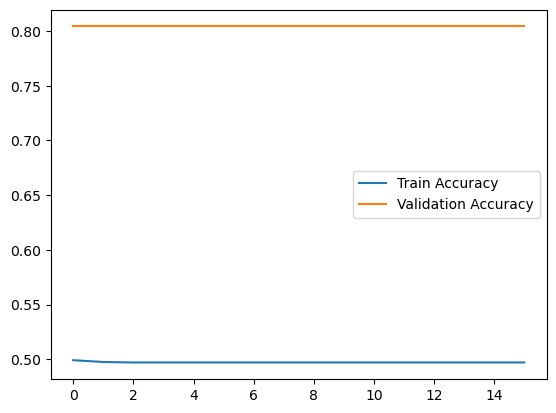

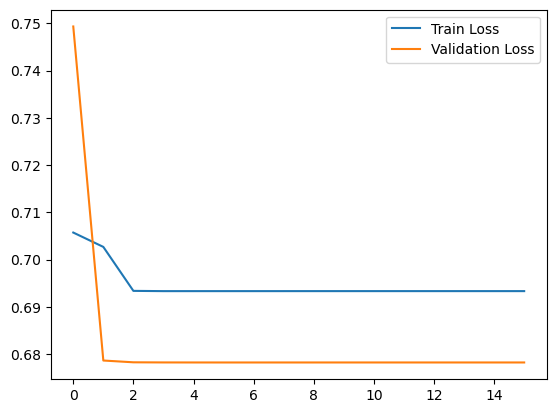

In [235]:
plot_training_vs_overfitting(history_8)

In [236]:
tf.random.set_seed(42)

# 1. Create the model using the Sequential API
nn9 = tf.keras.Sequential([
    Input(shape=(input_dim)),
    Dense(100, activation="elu"),
    Dense(64, activation="elu"),
    Dense(32, activation="elu"),
    Dense(16, activation="elu"),
    Dense(8, activation="elu"),
    Dense(1, activation=sigmoid)
])

# 2. Compile the model
nn9.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

# 3. Fit the model
history_9 = nn9.fit(X_train_resampled, y_train_resampled, epochs=30, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6556 - auc_18: 0.7172 - loss: 0.6148 - precision_18: 0.6565 - recall_18: 0.6530 - val_accuracy: 0.6860 - val_auc_18: 0.6905 - val_loss: 0.5842 - val_precision_18: 0.3222 - val_recall_18: 0.5473
Epoch 2/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7223 - auc_18: 0.8081 - loss: 0.5110 - precision_18: 0.7536 - recall_18: 0.6612 - val_accuracy: 0.7215 - val_auc_18: 0.6907 - val_loss: 0.5435 - val_precision_18: 0.3426 - val_recall_18: 0.4599
Epoch 3/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7262 - auc_18: 0.8130 - loss: 0.5051 - precision_18: 0.7568 - recall_18: 0.6671 - val_accuracy: 0.7714 - val_auc_18: 0.6891 - val_loss: 0.5072 - val_precision_18: 0.3976 - val_recall_18: 0.3256
Epoch 4/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7317 - auc_18: 0.8170 - loss: 0.4987 - precision_18: 0.7765 - recall_18: 0.6512 - val_accuracy: 0.7248 - val_auc_18: 0.6880 - val_loss: 0.5401 - v

In [237]:
# Make predictions and evaluate
nn9_y_prob = nn9.predict(X_test)
nn9_y_pred = (nn9_y_prob > 0.5)
model_evaluation_report(X_test, y_test, nn9_y_pred, nn9_y_prob)

399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.6859789605903596
Precision: 0.32223796033994334
Recall: 0.5473135525260625
F1-Score: 0.40564635958395245
ROC-AUC: 0.6904639075992456
Confusion Matrix:
[[7373 2871]
 [1129 1365]]


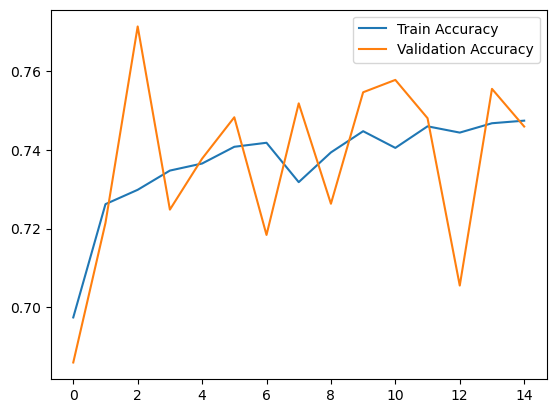

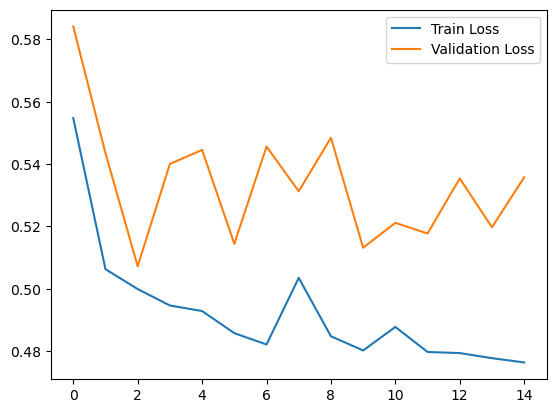

In [238]:
plot_training_vs_overfitting(history_9)

In [239]:
tf.random.set_seed(42)

# 1. Create the model using the Sequential API
nn10 = tf.keras.Sequential([
    Input(shape=(input_dim)),
    Dense(100, activation="selu"),
    Dense(100, activation="selu"),
    Dense(100, activation="selu"),
    Dense(100, activation="selu"),
    Dense(100, activation="selu"),
    Dense(100, activation="selu"),
    Dense(100, activation="selu"),
    Dense(100, activation="selu"),
    Dense(100, activation="selu"),
    Dense(100, activation="selu"),
    Dense(100, activation="selu"),
    Dense(100, activation="selu"),
    Dense(64, activation="selu"),
    Dense(32, activation="selu"),
    Dense(16, activation="selu"),
    Dense(8, activation="selu"),
    Dense(1, activation=sigmoid)
])

# 2. Compile the model
nn10.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

# 3. Fit the model
history_10 = nn10.fit(X_train_resampled, y_train_resampled, epochs=30, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5361 - auc_19: 0.5548 - loss: 0.9064 - precision_19: 0.5353 - recall_19: 0.5388 - val_accuracy: 0.8042 - val_auc_19: 0.5000 - val_loss: 0.6333 - val_precision_19: 0.0000e+00 - val_recall_19: 0.0000e+00
Epoch 2/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5012 - auc_19: 0.5010 - loss: 0.6942 - precision_19: 0.4972 - recall_19: 0.5020 - val_accuracy: 0.8042 - val_auc_19: 0.5000 - val_loss: 0.6342 - val_precision_19: 0.0000e+00 - val_recall_19: 0.0000e+00
Epoch 3/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5021 - auc_19: 0.5016 - loss: 0.6944 - precision_19: 0.4994 - recall_19: 0.5199 - val_accuracy: 0.8042 - val_auc_19: 0.5000 - val_loss: 0.6378 - val_precision_19: 0.0000e+00 - val_recall_19: 0.0000e+00
Epoch 4/30
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5019 - auc_19: 0.5017 - loss: 0.6946 - precision_19: 0.5001 - recall_19: 0.5276 - val_accuracy: 0.8042 - val_auc_19: 0.50

In [240]:
# Make predictions and evaluate
nn10_y_prob = nn10.predict(X_test)
nn10_y_pred = (nn10_y_prob > 0.5)
model_evaluation_report(X_test, y_test, nn10_y_pred, nn10_y_prob)

399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.8042078819280892
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
ROC-AUC: 0.37630551511836136
Confusion Matrix:
[[10244     0]
 [ 2494     0]]


/home/cheydb/anaconda3/envs/dsif-acc/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


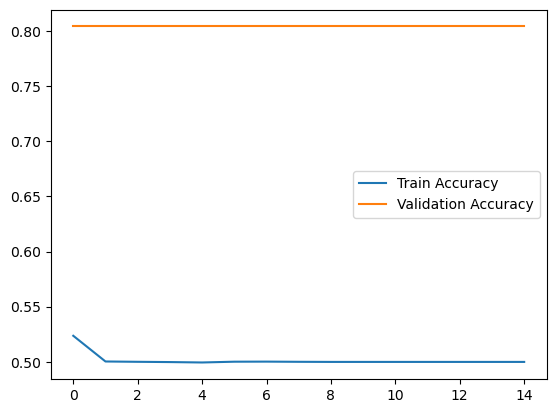

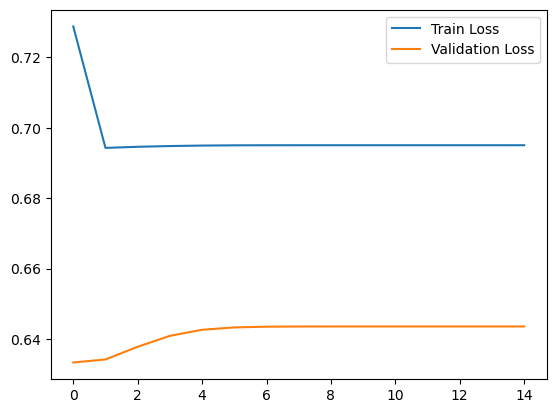

In [241]:
plot_training_vs_overfitting(history_10)

In [242]:
# Define the build_model function for Keras Tuner
# def build_model(hp):
#     model = keras.Sequential()
#     for i in range(hp.Int('num_layers', 2, 20)):
#         model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
#                                activation='relu'))
#     model.add(layers.Dense(1, activation='sigmoid'))
#     model.compile(
#         optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
#         loss='binary_crossentropy',
#         metrics=['accuracy'])
#     return model

In [243]:
# tuner = RandomSearch(                   # The tuner uses the build_model function defined earlier as its model-building function,
#     build_model,                        # and searches for the best hyperparameters based on validation accuracy.
#     objective='val_accuracy',
#     max_trials=3,
#     executions_per_trial=2)
# tuner.search(X_train_resampled, y_train_resampled, epochs=10, validation_data=(X_test, y_test))

# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]                # Storing my best hyperparameters in the best_hps variable.

In [244]:
# def create_model(num_layers, num_nodes, activation):
#     nn11 = keras.Sequential()
#     for i in range(num_layers):
#         if i==0:                                                           # checks whether the current layer is the first layer of the model.
#             nn11.add(layers.Dense(num_nodes[i], input_dim=X_train.shape[1]))
#             nn11.add(layers.Activation(activation))
#             nn11.add(layers.Dropout(0.3))
#         else:
#             nn11.add(layers.Dense(num_nodes[i]))
#             nn11.add(layers.Activation(activation))
#             nn11.add(layers.Dropout(0.3))       
#     nn11.add(layers.Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))
#     nn11.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return nn11

# # Generate a list of integers for the number of nodes in each layer
# num_nodes = [best_hps.get('units_' + str(i)) for i in range(best_hps.get('num_layers'))]

# nn11 = KerasClassifier(
#     build_fn=create_model,
#     num_layers=best_hps.get('num_layers'),
#     num_nodes=num_nodes,
#     activation='relu'
# )

In [245]:
# Fit the Keras Classifier model with the optimal hyperparameters
# history_11= nn11.fit(X_train_resampled, y_train_resampled, epochs=20, validation_data=(X_test, y_test))

In [246]:
# Make predictions and evaluate
# nn11_y_prob = nn11.predict(X_test)
# nn11_y_pred = (nn11_y_prob > 0.5)
# model_evaluation_report(X_test, y_test, nn11_y_pred, nn11_y_prob)

In [247]:
def evaluate_models(models, X_test, y_test, model_names=None):
    """
    Evaluate a list of fitted neural network models and plot their performance metrics.

    Args:
    models (list): A list of fitted neural network models.
    X_test (numpy.array or pandas.DataFrame): Test features.
    y_test (numpy.array or pandas.Series): True labels for test set.
    model_names (list): List of model names for labeling the plots (optional).

    Returns:
    None: Plots evaluation metrics for comparison.
    """
    metrics = ['Accuracy', 'Precision', 'Recall', 'AUC']
    results = {metric: [] for metric in metrics}

    # Evaluate each model
    for model in models:
        # Get predictions
        y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Convert probabilities to class labels
        y_pred_proba = model.predict(X_test)  # For AUC, keep the probabilities

        # Calculate metrics
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)

        # Store the results
        results['Accuracy'].append(acc)
        results['Precision'].append(precision)
        results['Recall'].append(recall)
        results['AUC'].append(auc)

    # Set up model names if not provided
    if model_names is None:
        model_names = [f'Model {i+1}' for i in range(len(models))]

    # Plot the results
    plt.figure(figsize=(12, 8))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)  # 2x2 grid for 4 metrics
        plt.bar(model_names, results[metric])
        plt.title(metric)
        plt.xlabel("Models")
        plt.ylabel(metric)

    plt.tight_layout()
    plt.show()

In [248]:
models = [nn, nn2, nn3, nn4, nn5, nn6, nn7, nn8, nn9, nn10]

In [249]:
model_names =['nn', 'nn2', 'nn3', 'nn4', 'nn5', 'nn6', 'nn7', 'nn8', 'nn9', 'nn10']

399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
119/399 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step

/home/cheydb/anaconda3/envs/dsif-acc/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/home/cheydb/anaconda3/envs/dsif-acc/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


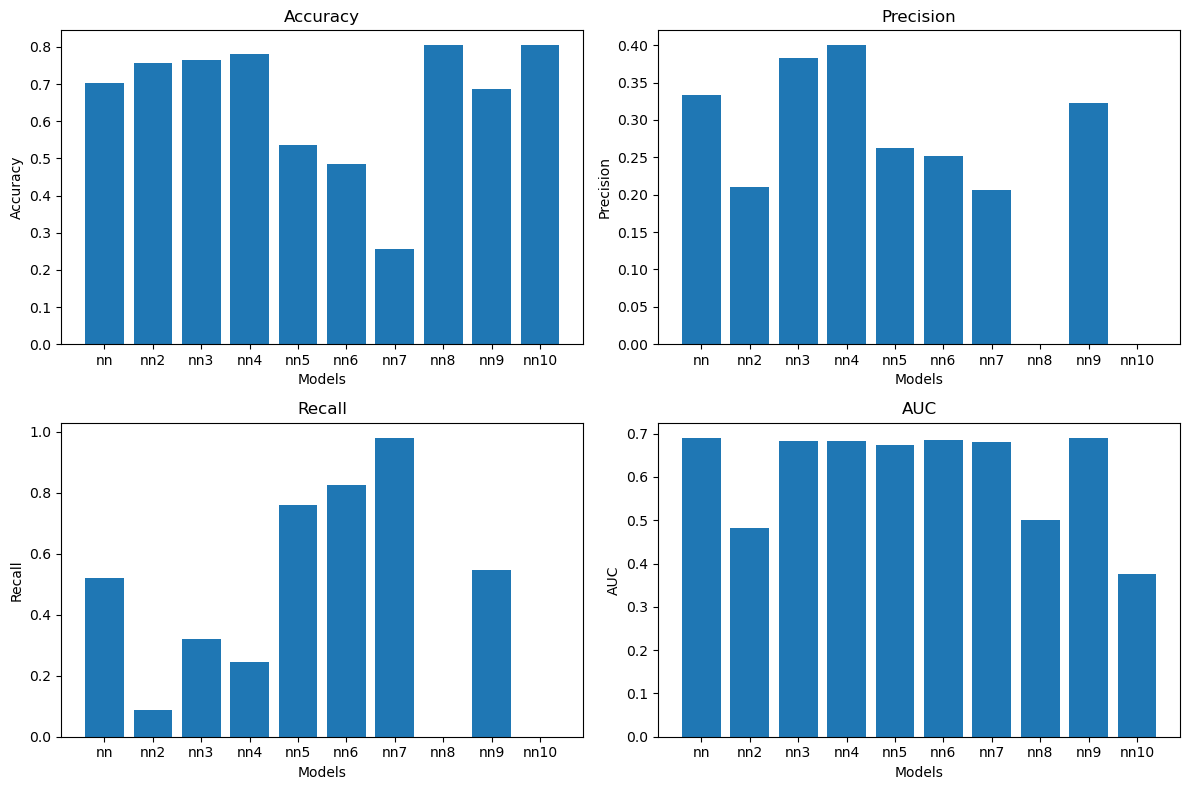

In [250]:
evaluate_models(models, X_test, y_test, model_names=model_names)

## 8. Summary

- We started out with 100,000 samples and 143 features.
- We conducted univariate, bivariate and multivariate analysis on these features to gain insights into the data.
- We were limited in our domain knowledge due to lack of an SME. As a result, assumptions had to be made and certain decisions which may have impacted the quality of the dataset had to be taken. For example, features with more than 50% missing values were dropped as we had no way of gaining a better understanding of what this means and whether it was by design or not.
- For numerical features, either the mode or median were used to impute missing values where applicable.
- Out of the 143 original features, 37 were chosen, which includes 3 features that were engineered by combining features together. (This does not include the target).
- These features were selected by dropping one feature out of feature pairs with very high correlation (above 0.9 or below -0.9), dropping features with more than 50% missing values (as mentioned above), dropping features that are determined post-loan issuance or after acquiring a "Charged Off" status (this was done to meet the business requirements i.e a model that can predict loan defaults with the intention of using it accept or reject loan applications, other reasons for dropping columns include (but are not limited to) irrelevancy, redundancy, low variability (constant).
- There was quite a big imbalance between the target variable classes. 51258:12431 = 4.12:1 = 80.5% Fully Paid, 19.5% Charged Off.
- SMOTE was used to handle this imbalance.
- Models used were: LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, CatboostClassifier and Feed Forward Neural Networks.
- SHAP was used for interpretability and through RFE we gained an understanding of the most important features.
- CatboostClassifier produced the best results - Accuracy:0.81, Precision:0.58, Recall:0.05, F1-Score:0.09, ROC-AUC:0.71 rounded to 2 decimal places.
- Our best model did not meet the evaluation metrics required for this model to be productionised.

## 9. Conclusion
The best model does not meet the needs and criteria of the business with regards to the evaluation results. Despite attempts to make up for the class imbalance, the models were not able to distinguish between the two classes with a heavy bias towards "Fully Paid". From my understanding of the business, this could cost the Lending Club a lot of money as false negatives i.e predicting that the person will not default on the loan when in actual fact they will costs the business more than predicting that they will default on the loan when in actual fact they won't. For this reason, the model cannot be used by the business as intended.



## 10. Insights

1. Over 20% of the data had more than 50% of the values missing.
2. About 90% of people who were "Charged Off" did not have a hardship plan.
3. People with one of more public records of bankruptcies are more likely to be "Charged Off" on their loan.
4. The original data contains a lot of redundant features.
5. The original data contains a lot of features that are post-loan issuance but have a status of "Current".
6. The higher the grade/sub-grade the more likely a customer is to default on their loan.
7. Debt-to-income ratio was the most important feature in determining whether someone would default on a loan or not.

## 11. Recommended Actions (Next steps) - based on key insights above

1. I'm not sure what the reason for the missing values is but that data could prove valuable in building a robust and accurate model. If the missing values are a result of customers not filling out certain parts of forms, then those fields should be made mandatory or a default value should be placed there that best describes the meaning of a blank field. This will lead to beter data quality, which can lead to better model accuracy, which means better decision making and money savings through determining whether someone will be "Charged Off" or not.
2. More effort should go into setting up a hardship plan for people who either have a significant dip in their fico_score or fall into the late category to prevent customers from getting to the "Charged Off" stage.
3. Interest rates should be closely tied to the number of bankruptcies so that even if a customers loan is "Charged Off", we can still break even or people with one or more bankruptcies should need to provide some form of collateral or have a guarantor to minimise the risk.
4. Proper implementation of ETL/ELT pipelines including data validation, data redundacy check etc. should be carried out to improve the quality of the data. The better the quality of the data, the better the model can learn.
5. As it stands the current best model cannot be used to predict loan defaults without the business incurring a massive loss. However, the post-loan issuance data/features can be used to build a model for early detection/signals of defaults so that the necessary actions can be taken to help prevent the loan from defaulting such as initiating a hardship plan or providing customers with financial advice to help them stay on track with monthly installments.
6. Interest rates should be highly determined by grade/sub-grade since number of defaults goes up linearly with grade/sub-grade.
7. Customers with high debt-to-income ratio should be checked thoroughly, looking and public records of bankruptcies or high credit stress can help with making more informed decisions on whether to accept a loan application or not.